In [6]:
from sklearn.preprocessing import StandardScaler

from IPython.display import Image
#from sklearn.model_selection import KFold
#from sklearn.linear_model import LogisticRegression

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score

import missingno as msno

from lightgbm import LGBMClassifier
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, Binarizer, KBinsDiscretizer

from statsmodels.stats.outliers_influence import variance_inflation_factor

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import cross_val_predict
from patsy import dmatrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, mean_absolute_error
from sklearn.model_selection import GridSearchCV, cross_val_score


import xgboost as xgb
from lightgbm import LGBMClassifier
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

from warnings import filterwarnings
import warnings

%matplotlib inline
%config Inlinebackend.figure_format = 'retina'

# 한글 폰트 설정
mpl.rc('font', family='malgun gothic')

# 시각화 차트에 음수설정
mpl.rc('axes', unicode_minus = False)

# 오류경고
warnings.filterwarnings('ignore')


import seaborn as sns

# 차트 스타일지정     글꼴                    음수처리                        눈금
sns.set(font = 'malgun ghthic', rc={'axes.unicode_minus':False}, style = 'darkgrid')
plt.rc('figure', figsize=(10, 8))


In [7]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

mpl.rc('font', family = 'D2coding')
mpl.rc('axes', unicode_minus=False)

sns.set(font="malgun gothic", rc={"axes.unicode_minus":False}, style='darkgrid')
plt.rc('figure', figsize=( 10, 8))

warnings.filterwarnings('ignore')

# User Function

In [8]:
def get_f1(model_name, target, pred) :
    print(model_name, 'Macro f1 socre : ', f1_score(target, pred, average='macro'))
    
def get_f1_score(target, pred) :
    print('Macro f1 socre : ', f1_score(target, pred, average='macro'))
    
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test , pred)
    rmse = np.sqrt(mse)
    print('{0} 로그 변환된 RMSE: {1}'.format(model.__class__.__name__,np.round(rmse, 3)))
    return rmse

def get_rmses(models):
    rmses = [ ]
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

In [9]:
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve, classification_report

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import Binarizer


# 평가지표 분류
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {:.4f}, 정밀도 : {:.4f}, 재현율 : {:.4f}, F1 : {:.4f}, AUC : {:.4f}'.
          format(accuracy, precision, recall, f1, roc_auc))

# 재현율과 정밀도의 시각화
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize = (10, 7))
    plt.rc('font', family = 'D2coding')
    threshold_boundary = thresholds.shape[0]
    a = thresholds[precisions[0:threshold_boundary] == recalls[0:threshold_boundary]]
    loc = np.where(thresholds == a[0])[0][0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle = '--', label = 'precision')
    plt.plot(thresholds, recalls[0:threshold_boundary], label = 'recall')
    plt.scatter(thresholds[loc], precisions[loc], c = 'black', s = 60)
    plt.text(0.02 + thresholds[loc], precisions[loc], '임계값 : {:.3f}'.format(thresholds[loc]), size = 15)
    
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1), 2), size = 15)
    plt.xlabel('Threshold value', size = 15); plt.ylabel('Precision and Recall value', size = 15)
    plt.legend()
    plt.rc('legend', fontsize = 15)
    plt.rc('ytick', labelsize = 15)
    plt.show()
    

# 임계값 조정 함수
def get_clf_eval_thres(y_test, pred_po, threshold, f1_show=False, auc_show=False):
    eval_df = pd.DataFrame()
    
    for thres in threshold:
        # threshold에 따른 예측 분류 값
        binarizer = Binarizer(threshold = thres)
        binarizer.fit(pred_po)
        thres_pred = binarizer.transform(pred_po)
        
        # 평가지표  
        accuracy = accuracy_score(y_test, thres_pred)
        precision = precision_score(y_test, thres_pred)
        recall = recall_score(y_test, thres_pred)
        f1 = f1_score(y_test, thres_pred)
        auc = roc_auc_score(y_test, pred_po)
        
        # 데이터 프레임 형태
        eval_lst = np.array([accuracy, precision, recall, f1, auc]).reshape(-1,1)
        temp = pd.DataFrame(eval_lst, columns=[thres], 
                            index = ["정확도", "정밀도", "재현율", "F1스코어", "AUC"])
        eval_df = pd.concat([eval_df,temp], axis=1)
        
    eval_df.columns.names = ["임계값"]
    
    if f1_show == False:
        eval_df.drop("F1스코어", axis=0, inplace=True)
        
    if auc_show == False:
        eval_df.drop("AUC", axis=0, inplace=True)
        
    return round(eval_df, 4)


def get_acc(data, target) :
    pred_X = grid_clf.predict(data)

    print('train accuracy score :', accuracy_score(target, pred_X))

In [10]:
data = pd.read_csv('C:/k_digital/source/data/open/train.csv')
test = pd.read_csv('C:/k_digital/source/data/open/test.csv')

In [11]:
data['FOPTIMETHGLY'].value_counts()

0.0     1954
1.0     1834
2.0       90
3.0        8
13.0       1
7.0        1
5.0        1
10.0       1
Name: FOPTIMETHGLY, dtype: int64

# 데이터 탐색 및 전처리(EDA)

## 데이터 유형 확인

In [12]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14095 entries, 0 to 14094
Data columns (total 54 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   14095 non-null  object 
 1   COMPONENT_ARBITRARY  14095 non-null  object 
 2   ANONYMOUS_1          14095 non-null  int64  
 3   YEAR                 14095 non-null  int64  
 4   SAMPLE_TRANSFER_DAY  14095 non-null  int64  
 5   ANONYMOUS_2          14095 non-null  int64  
 6   AG                   14095 non-null  int64  
 7   AL                   14095 non-null  int64  
 8   B                    14095 non-null  int64  
 9   BA                   14095 non-null  int64  
 10  BE                   14095 non-null  int64  
 11  CA                   14095 non-null  int64  
 12  CD                   12701 non-null  float64
 13  CO                   14095 non-null  int64  
 14  CR                   14095 non-null  int64  
 15  CU                   14095 non-null 

## profiling

In [13]:
#!pip install pandas_profiling

import pandas_profiling
profile_report = pandas_profiling.ProfileReport(data)
profile_report

## 결측치 확인
- U를 2개의 그룹으로 합친 다음에 결측치를 0으로 대체 
- 결측치 0으로 바꾸기

In [14]:
# 비율로 확인 
missing_value = data.isna().sum()
total = data.shape[0]
ratio = round(missing_value/total,2)
print(round(missing_value/total,2))
ratio.sort_values(ascending=False).head(17).index
#  ['U4', 'U6', 'U14', 'U20', 'U50', 'U100', 'U75', 'U25', 'V100', 'FH2O',
#        'FOXID', 'FUEL', 'FOPTIMETHGLY', 'FSO4', 'FTBN', 'SOOTPERCENTAGE',
#        'FNOX'] --> 결측치 70% 이상 

ID                     0.00
COMPONENT_ARBITRARY    0.00
ANONYMOUS_1            0.00
YEAR                   0.00
SAMPLE_TRANSFER_DAY    0.00
ANONYMOUS_2            0.00
AG                     0.00
AL                     0.00
B                      0.00
BA                     0.00
BE                     0.00
CA                     0.00
CD                     0.10
CO                     0.00
CR                     0.00
CU                     0.00
FH2O                   0.72
FNOX                   0.72
FOPTIMETHGLY           0.72
FOXID                  0.72
FSO4                   0.72
FTBN                   0.72
FE                     0.00
FUEL                   0.72
H2O                    0.00
K                      0.16
LI                     0.00
MG                     0.00
MN                     0.00
MO                     0.00
NA                     0.00
NI                     0.00
P                      0.00
PB                     0.00
PQINDEX                0.00
S                   

Index(['U4', 'U6', 'U14', 'U20', 'U50', 'U100', 'U75', 'U25', 'V100', 'FH2O',
       'FOXID', 'FUEL', 'FOPTIMETHGLY', 'FSO4', 'FTBN', 'SOOTPERCENTAGE',
       'FNOX'],
      dtype='object')

In [15]:
data['FOPTIMETHGLY'].value_counts()

0.0     1954
1.0     1834
2.0       90
3.0        8
13.0       1
7.0        1
5.0        1
10.0       1
Name: FOPTIMETHGLY, dtype: int64

In [16]:
# 결측치 시각화 
# plt.figure(figsize=(10,15))
# msno.matrix(data.sample(250))
# plt.show()

In [12]:
# bar
# msno.bar(data)

In [13]:
#한 변수의 유무가 다른 변수의 존재에 얼마나 강하게 영향을 미치는지입니다.
# 결측치가 너무 많아서 "1"로 뜬 것 같다. 
# msno.heatmap(data)

## 결측치 확인 

In [20]:
# 'U20', 'U50', 'U100','U75', 'U25', 'FOPTIMETHGLY','V100' 삭제 
data = data[['ANONYMOUS_1','AL','CA','FE','B','P','S','PQINDEX','V40','MO','ZN','FTBN',
     'SI','CU','ANONYMOUS_2','SAMPLE_TRANSFER_DAY','MG','NA','CR','BA','U4','TI','PB','NI','SN',
     'K','MN','U20','COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL']]

In [25]:
data['U20'].value_counts()

4.0       150
2.0       139
3.0       108
5.0       101
1.0       101
         ... 
257.0       1
247.0       1
143.0       1
113.0       1
2565.0      1
Name: U20, Length: 275, dtype: int64

In [15]:
# Y_LABEL확인
# data['Y_LABEL'].value_counts()

In [16]:
# 결측치 확인 
# data.isna().sum()

In [22]:
# 결측치 "0"으로 채우기 
feature = ['K','U4']
for i in feature:
    data[i].fillna(0, inplace=True)    

In [18]:
# data['FUEL'].value_counts()

In [19]:
# 결측치 확인 --> 결측치 없음. * FUEL, FTBN은 아직 결측치 존재 . 
# data.isna().sum()

### FTBN

In [20]:
# sns.boxplot(data['FTBN'])
# plt.show()

In [21]:
# data.FTBN.plot()

In [22]:
# 결측치를 뭘로 채우지?
# data['FTBN'].describe()

In [23]:
# data['FTBN'].value_counts()

In [24]:
# data.head(3)

## YEAR, COMPONENT로 groupby 이용해 target값 분석. FUEL

0         True
1        False
2        False
3         True
4         True
         ...  
14090     True
14091     True
14092     True
14093    False
14094    False
Name: U20, Length: 14095, dtype: bool

In [26]:
missing_value_mana = [ 'U20',   'FTBN']
for i in missing_value_mana:
    print(i, '\n' ,data[data[i].isna()==True]['Y_LABEL'].value_counts(), '\n-----------------------------')

U20 
 0    10782
1      997
Name: Y_LABEL, dtype: int64 
-----------------------------
FTBN 
 0    9314
1     891
Name: Y_LABEL, dtype: int64 
-----------------------------


## IterativeImputer

In [27]:
FTBN = pd.DataFrame(data['FTBN'])
# FTBN

In [28]:
FTBN = pd.DataFrame(data['FTBN'])
FTBN
# 결측값을 예측을 통해 채워넣음 
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

imputer = IterativeImputer(random_state=100)
FTBN_imputed = imputer.fit_transform(FTBN)

# describe()를 하기위해 dataframe으로 바꿔줌 
FTBN_imputed = pd.DataFrame(FTBN_imputed)
# FTBN_imputed.describe()

In [29]:
FTBN_imputed = pd.DataFrame(FTBN_imputed)
# FTBN_imputed.describe()

In [32]:
# iterative impute 하기 전.
# data['FTBN'].describe()

## 결측치 많은 애들 heatmap

In [30]:
data['FTBN'] = FTBN_imputed

In [33]:
data['U20'] = data['U20'].fillna(0)

In [34]:
data['U20']

0           0.0
1           4.0
2           3.0
3           0.0
4           0.0
          ...  
14090       0.0
14091       0.0
14092       0.0
14093       8.0
14094    2565.0
Name: U20, Length: 14095, dtype: float64

<AxesSubplot:>

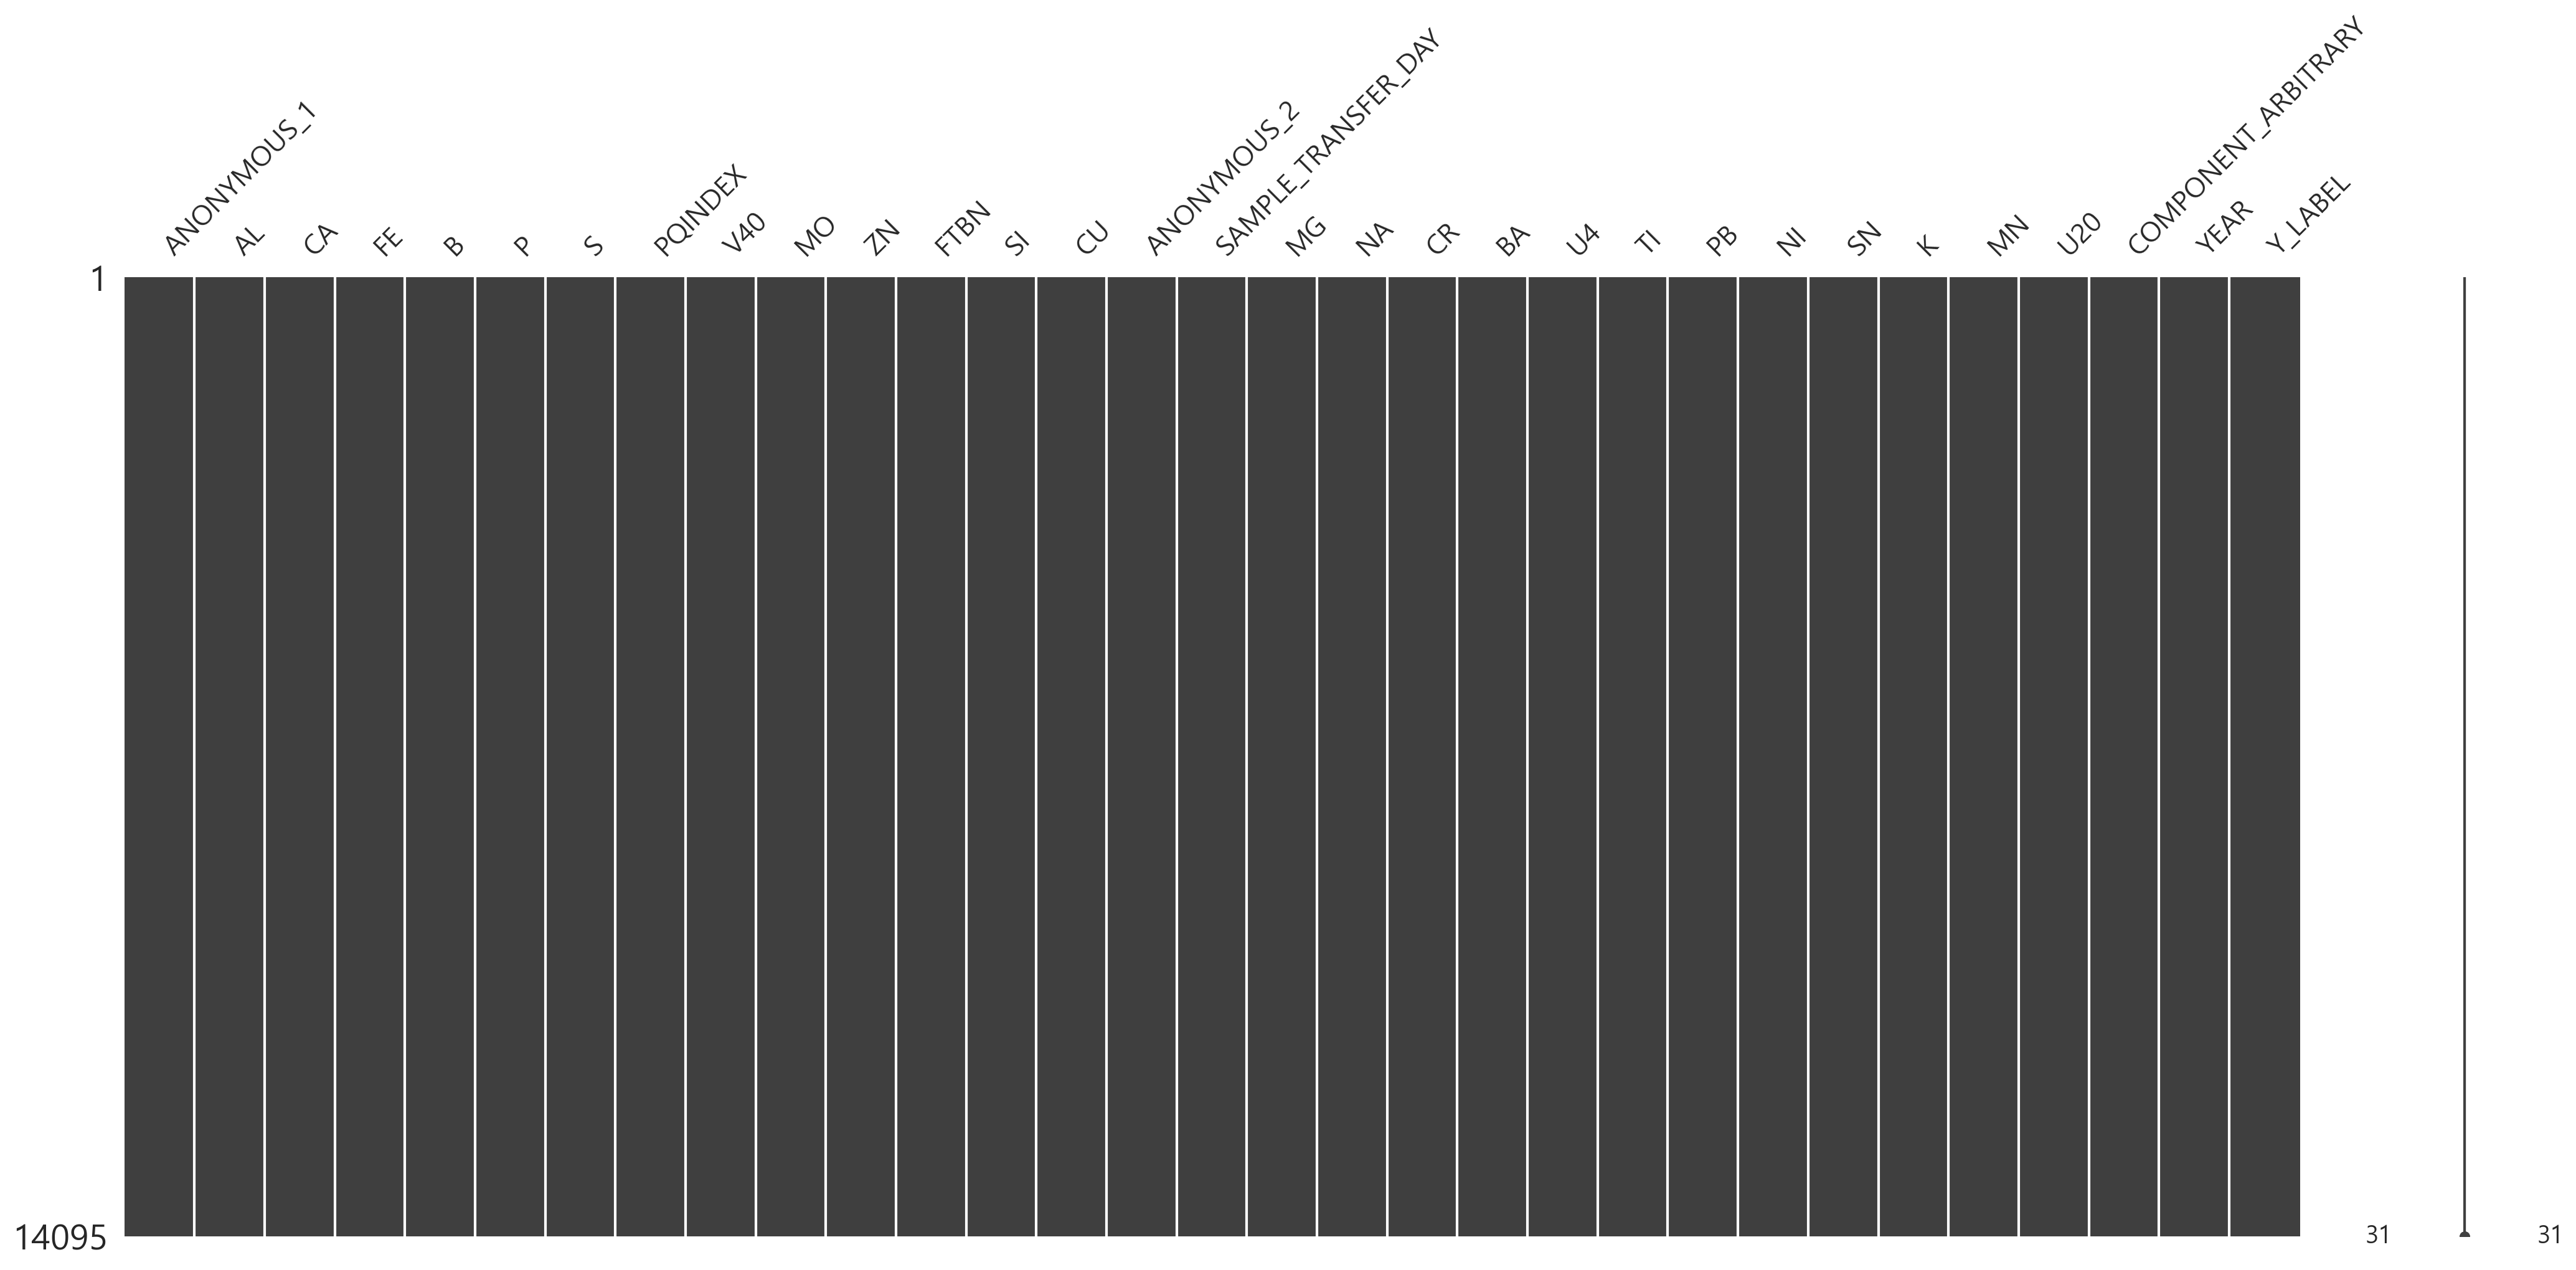

In [35]:
msno.matrix(data)

# 데이터 스케일링

In [38]:
# data.columns

In [36]:
categorical_features = ['COMPONENT_ARBITRARY', 'YEAR']

In [37]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in categorical_features:    
    data[col] = le.fit_transform(data[col])

In [39]:
data

,ANONYMOUS_1,AL,CA,FE,B,P,S,PQINDEX,V40,MO,...,TI,PB,NI,SN,K,MN,U20,COMPONENT_ARBITRARY,YEAR,Y_LABEL
0,1486,3,3059,888,93,1951,21370,8504,154.0,1,...,5,0,6,2,27.0,16,0.0,2,4,0
1,1350,2,2978,2,19,572,1117,19,44.0,0,...,0,2,0,0,0.0,0,4.0,1,14,0
2,2415,110,17,4,1,328,1334,17,72.6,0,...,0,0,0,1,0.0,0,3.0,1,8,1
3,7389,8,1960,37,3,906,21774,44,133.3,0,...,0,1,0,1,0.0,1,0.0,2,3,0
4,3954,1,71,71,157,309,18470,217,133.1,0,...,0,0,0,0,0.0,0,0.0,2,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,1616,2,6,23,201,477,22000,35,135.4,0,...,0,0,0,0,1.0,0,0.0,2,7,0
14091,2784,3,2945,12,85,1163,5494,9,117.5,224,...,0,1,0,0,4.0,0,0.0,0,6,0
14092,1788,6,13,415,0,1175,9640,645,54.0,10,...,0,1,1,0,0.0,7,0.0,2,1,0
14093,2498,2,2244,19,4,441,1313,11,44.3,1,...,0,1,0,0,0.0,0,8.0,1,2,0


In [40]:
data.drop(['COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL'], axis = 1).columns

Index(['ANONYMOUS_1', 'AL', 'CA', 'FE', 'B', 'P', 'S', 'PQINDEX', 'V40', 'MO',
       'ZN', 'FTBN', 'SI', 'CU', 'ANONYMOUS_2', 'SAMPLE_TRANSFER_DAY', 'MG',
       'NA', 'CR', 'BA', 'U4', 'TI', 'PB', 'NI', 'SN', 'K', 'MN', 'U20'],
      dtype='object')

In [92]:
data['COMPONENT_ARBITRARY'].value_counts()

2    7050
0    3890
1    2316
3     839
Name: COMPONENT_ARBITRARY, dtype: int64

# 컬럼제거 바로가기

In [41]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer

ss = StandardScaler()
scaled = ss.fit_transform(data.drop(['COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL'], axis = 1))
columns = data.drop(['COMPONENT_ARBITRARY', 'YEAR', 'Y_LABEL'], axis = 1).columns

scaled = pd.DataFrame(scaled, columns = columns)
# scaled.head()

In [43]:
scaled

,ANONYMOUS_1,AL,CA,FE,B,P,S,PQINDEX,V40,MO,...,CR,BA,U4,TI,PB,NI,SN,K,MN,U20
0,-0.393763,-0.111628,1.141962,1.331290,0.281646,1.845136,1.001652,5.293270,0.899892,-0.384284,...,0.339245,-0.238453,-0.171264,0.622282,-0.160812,1.384414,0.302478,1.669706,1.186914,-0.118804
1,-0.426022,-0.123127,1.087302,-0.330406,-0.437686,-0.598302,-1.170187,-0.259244,-1.317376,-0.400998,...,-0.115388,-0.238453,-0.085911,-0.102635,0.033010,-0.191804,-0.252439,-0.210453,-0.250456,-0.067218
2,-0.173409,1.118753,-0.910846,-0.326655,-0.612659,-1.030643,-1.146917,-0.260552,-0.740886,-0.400998,...,-0.080416,0.105735,2.240286,-0.102635,-0.160812,-0.191804,0.025019,-0.210453,-0.250456,-0.080114
3,1.006399,-0.054133,0.400333,-0.264764,-0.593217,-0.006490,1.044975,-0.242884,0.482642,-0.400998,...,-0.115388,-0.238453,-0.171264,-0.102635,-0.063901,-0.191804,0.025019,-0.210453,-0.160621,-0.118804
4,0.191634,-0.134626,-0.874406,-0.200996,0.903771,-1.064309,0.690669,-0.129674,0.478611,-0.400998,...,-0.115388,-0.238453,-0.171264,-0.102635,-0.160812,-0.191804,-0.252439,-0.210453,-0.250456,-0.118804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,-0.362928,-0.123127,-0.918269,-0.291021,1.331482,-0.766631,1.069210,-0.248773,0.524972,-0.400998,...,-0.115388,0.105735,-0.171264,-0.102635,-0.160812,-0.191804,-0.252439,-0.140817,-0.250456,-0.118804
14091,-0.085884,-0.111628,1.065033,-0.311651,0.203880,0.448886,-0.700817,-0.265787,0.164162,3.342831,...,-0.115388,-0.238453,-0.171264,-0.102635,-0.063901,-0.191804,-0.252439,0.068089,-0.250456,-0.118804
14092,-0.322130,-0.077131,-0.913545,0.444177,-0.622379,0.470148,-0.256220,0.150406,-1.115806,-0.233862,...,0.024499,0.105735,-0.171264,-0.102635,-0.063901,0.070899,-0.252439,-0.210453,0.378393,-0.118804
14093,-0.153722,-0.123127,0.591983,-0.298523,-0.583497,-0.830419,-1.149169,-0.264479,-1.311328,-0.384284,...,-0.115388,-0.238453,0.937623,-0.102635,-0.063901,-0.191804,-0.252439,-0.210453,-0.250456,-0.015631


## log

In [44]:
for i in range(len(data2.columns)):
    data2.iloc[:, i] = np.log1p(data2.iloc[:, i])

In [45]:
onehot = data[['COMPONENT_ARBITRARY', 'YEAR']]
scaled = pd.concat([onehot, scaled], axis = 1)
scaled

,COMPONENT_ARBITRARY,YEAR,ANONYMOUS_1,AL,CA,FE,B,P,S,PQINDEX,...,CR,BA,U4,TI,PB,NI,SN,K,MN,U20
0,2,4,-0.393763,-0.111628,1.141962,1.331290,0.281646,1.845136,1.001652,5.293270,...,0.339245,-0.238453,-0.171264,0.622282,-0.160812,1.384414,0.302478,1.669706,1.186914,-0.118804
1,1,14,-0.426022,-0.123127,1.087302,-0.330406,-0.437686,-0.598302,-1.170187,-0.259244,...,-0.115388,-0.238453,-0.085911,-0.102635,0.033010,-0.191804,-0.252439,-0.210453,-0.250456,-0.067218
2,1,8,-0.173409,1.118753,-0.910846,-0.326655,-0.612659,-1.030643,-1.146917,-0.260552,...,-0.080416,0.105735,2.240286,-0.102635,-0.160812,-0.191804,0.025019,-0.210453,-0.250456,-0.080114
3,2,3,1.006399,-0.054133,0.400333,-0.264764,-0.593217,-0.006490,1.044975,-0.242884,...,-0.115388,-0.238453,-0.171264,-0.102635,-0.063901,-0.191804,0.025019,-0.210453,-0.160621,-0.118804
4,2,8,0.191634,-0.134626,-0.874406,-0.200996,0.903771,-1.064309,0.690669,-0.129674,...,-0.115388,-0.238453,-0.171264,-0.102635,-0.160812,-0.191804,-0.252439,-0.210453,-0.250456,-0.118804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,2,7,-0.362928,-0.123127,-0.918269,-0.291021,1.331482,-0.766631,1.069210,-0.248773,...,-0.115388,0.105735,-0.171264,-0.102635,-0.160812,-0.191804,-0.252439,-0.140817,-0.250456,-0.118804
14091,0,6,-0.085884,-0.111628,1.065033,-0.311651,0.203880,0.448886,-0.700817,-0.265787,...,-0.115388,-0.238453,-0.171264,-0.102635,-0.063901,-0.191804,-0.252439,0.068089,-0.250456,-0.118804
14092,2,1,-0.322130,-0.077131,-0.913545,0.444177,-0.622379,0.470148,-0.256220,0.150406,...,0.024499,0.105735,-0.171264,-0.102635,-0.063901,0.070899,-0.252439,-0.210453,0.378393,-0.118804
14093,1,2,-0.153722,-0.123127,0.591983,-0.298523,-0.583497,-0.830419,-1.149169,-0.264479,...,-0.115388,-0.238453,0.937623,-0.102635,-0.063901,-0.191804,-0.252439,-0.210453,-0.250456,-0.015631


In [47]:
# plt.figure(figsize = (28, 28))
# sns.heatmap(scaled.corr(), annot = True, fmt = '0.1f', cmap = 'Blues')

In [48]:
scaled

,ANONYMOUS_1,SAMPLE_TRANSFER_DAY,ANONYMOUS_2,AG,AL,B,BA,BE,CA,CD,...,SI,SN,SOOTPERCENTAGE,TI,U14,U6,U4,V,V40,ZN
0,-0.393763,-0.051413,-0.340760,-0.150214,-0.111628,0.281646,-0.238453,-0.041491,1.141962,-0.070651,...,2.006643,0.302478,-0.384137,0.622282,-0.129231,-0.130716,-0.171264,-0.10655,0.899892,-0.966002
1,-0.426022,3.715319,-0.022576,-0.150214,-0.123127,-0.437686,-0.238453,-0.041491,1.087302,-0.070651,...,-0.179489,-0.252439,-0.384137,-0.102635,-0.107725,-0.096483,-0.085911,-0.10655,-1.317376,0.119147
2,-0.173409,-0.479451,-0.340760,-0.150214,1.118753,-0.612659,0.105735,-0.041491,-0.910846,-0.070651,...,-0.179489,0.025019,-0.384137,-0.102635,0.010557,1.654031,2.240286,-0.10655,-0.740886,-0.332215
3,1.006399,-0.479451,-0.340760,-0.150214,-0.054133,-0.593217,-0.238453,-0.041491,0.400333,-0.070651,...,-0.174370,0.025019,-0.384137,-0.102635,-0.129231,-0.130716,-0.171264,-0.10655,0.482642,-1.093888
4,0.191634,-0.308236,-0.340760,-0.150214,-0.134626,0.903771,-0.238453,-0.041491,-0.874406,-0.070651,...,-0.169250,-0.252439,-0.384137,-0.102635,-0.129231,-0.130716,-0.171264,-0.10655,0.478611,-0.866326
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14090,-0.362928,0.034194,-0.340760,-0.150214,-0.123127,1.331482,0.105735,-0.041491,-0.918269,-0.070651,...,-0.169250,-0.252439,-0.384137,-0.102635,-0.129231,-0.130716,-0.171264,-0.10655,0.524972,-1.076961
14091,-0.085884,-0.479451,-0.340760,-0.150214,-0.111628,0.203880,-0.238453,-0.041491,1.065033,-0.070651,...,-0.153891,-0.252439,0.529687,-0.102635,-0.129231,-0.130716,-0.171264,-0.10655,0.164162,1.540935
14092,-0.322130,0.119802,0.295608,-0.150214,-0.077131,-0.622379,0.105735,-0.041491,-0.913545,-0.070651,...,-0.087334,-0.252439,-0.384137,-0.102635,-0.129231,-0.130716,-0.171264,-0.10655,-1.115806,1.339703
14093,-0.153722,0.975877,0.295608,-0.150214,-0.123127,-0.583497,-0.238453,-0.041491,0.591983,-0.070651,...,-0.179489,-0.252439,-0.384137,-0.102635,0.229201,0.126829,0.937623,-0.10655,-1.311328,0.119147


## train, test 세트 분리

In [46]:
from sklearn.model_selection import train_test_split


X_train, X_test, y_train, y_test = train_test_split(scaled, data['Y_LABEL'], test_size = 0.2, random_state = 2022, stratify = data['Y_LABEL'])

In [47]:
from imblearn.under_sampling import NearMiss

nearmiss=NearMiss()
under_X,under_y = nearmiss.fit_resample(X_train, y_train)
print("NearMiss 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
print('NearMiss 적용 후 학습용 피처/레이블 데이터 세트 :', under_X.shape, under_y.shape)
print('NearMiss 적용 후 값의 분포 :\n',pd.Series(under_y).value_counts())

NearMiss 적용 전 학습용 피처/레이블 데이터 세트 :  (11276, 30) (11276,)
NearMiss 적용 후 학습용 피처/레이블 데이터 세트 : (1924, 30) (1924,)
NearMiss 적용 후 값의 분포 :
 0    962
1    962
Name: Y_LABEL, dtype: int64


In [48]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_over, y_train_over = smote.fit_resample(X_train, y_train)
print("SMOTE 적용 전 학습용 피처/레이블 데이터 세트 : ", X_train.shape, y_train.shape)
print('SMOTE 적용 후 학습용 피처/레이블 데이터 세트 :', X_train_over.shape, y_train_over.shape)
print('SMOTE 적용 후 값의 분포 :\n',pd.Series(y_train_over).value_counts())

SMOTE 적용 전 학습용 피처/레이블 데이터 세트 :  (11276, 30) (11276,)
SMOTE 적용 후 학습용 피처/레이블 데이터 세트 : (20628, 30) (20628,)
SMOTE 적용 후 값의 분포 :
 0    10314
1    10314
Name: Y_LABEL, dtype: int64


# 분류

## hyperopt

In [49]:
#!pip install hyperopt

In [50]:
from hyperopt import hp

In [55]:
def get_clf_eval(y_test, pred = None, pred_proba = None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    print('정확도 : {:.4f}, 정밀도 : {:.4f}, 재현율 : {:.4f}, F1 : {:.4f}, AUC : {:.4f}'.
          format(accuracy, precision, recall, f1, roc_auc))
    print('Macro f1 socre : ', f1_score(y_test, pred, average='macro'))


def get_model_train_eval(model, ftr_train = None, ftr_test = None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred = model.predict(ftr_test)
    pred_proba = model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [56]:
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size = 0.1, stratify=y_train, random_state=2022)

lgbm_search_space = {
    'num_leaves':hp.quniform('num_leaves', 31, 64, 1),
    'max_depth':hp.quniform('max_depth', 1, 169, 1),                  ## 정수형 하이퍼 파라미터 => quniform 사용
    'min_child_weight':hp.quniform('min_child_weight', 60, 100, 1),     ## 정수형 하이퍼 파라미터 => quniform 사용
    'learning_rate':hp.uniform('learning_rate', 0.01, 1.0),
    'subsample':hp.uniform('subsample', 0.7, 1),
}

In [57]:
from sklearn.model_selection import cross_val_score
from hyperopt import STATUS_OK
from sklearn.model_selection import KFold

def objective_func(search_space):

    lgbm_clf = LGBMClassifier(
    n_estimators=100,
    max_depth=int(search_space['max_depth']),                ## int형으로 형변환 필요
    min_child_weight=int(search_space['min_child_weight']),  ## int형으로 형변환 필요
    learning_rate=search_space['learning_rate'], 
    subsample=search_space['subsample'],
    num_leaves=int(search_space['num_leaves']),
      #eval_metric='logloss' => 불균형 데이터셋이므로 성능 평가 지표를 roc-auc로 설정
            )

      ## XGBoost와 LightGBM에서는 cross_val_score()를 적용하면 early stopping 지원 불가, KFold 방식으로 직접 구현해야 함
      ## 3개의 k-fold 방식으로 평가된 roc-auc 지표를 담는 list
    roc_auc_list = []

  ## 3개의 k-fold 방식 적용
    kf = KFold(n_splits=3)

    for tr_index, val_index in kf.split(X_train):

        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        lgbm_clf.fit(
            X_tr, y_tr,
            early_stopping_rounds=30,
            eval_metric='auc',
            eval_set=[(X_tr, y_tr), (X_val, y_val)]
    )

        score = roc_auc_score(
            y_val,
            lgbm_clf.predict_proba(X_val)[:, 1]
    )

        roc_auc_list.append(score)

    return (-1) * np.mean(roc_auc_list)


In [58]:
## 3) fmin()을 사용하여 최적 하이퍼 파라미터 찾기

from hyperopt import fmin, tpe, Trials

trials = Trials()

best = fmin(
    fn=objective_func,
    space=lgbm_search_space,
    algo=tpe.suggest,
    max_evals=30,  ## 30번 만큼 반복하며 최적의 하이퍼 파라미터 찾음
    trials=trials,
)

best

[1]	training's auc: 0.820931	training's binary_logloss: 0.248542	valid_1's auc: 0.813041	valid_1's binary_logloss: 0.245527
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.859821	training's binary_logloss: 0.209619	valid_1's auc: 0.847646	valid_1's binary_logloss: 0.207047
[3]	training's auc: 0.863138	training's binary_logloss: 0.191348	valid_1's auc: 0.851142	valid_1's binary_logloss: 0.190179
[4]	training's auc: 0.867874	training's binary_logloss: 0.182475	valid_1's auc: 0.852945	valid_1's binary_logloss: 0.181798
[5]	training's auc: 0.880587	training's binary_logloss: 0.176872	valid_1's auc: 0.86082	valid_1's binary_logloss: 0.176882
[6]	training's auc: 0.888157	training's binary_logloss: 0.174095	valid_1's auc: 0.866597	valid_1's binary_logloss: 0.175282
[7]	training's auc: 0.890366	training's binary_logloss: 0.17156	valid_1's auc: 0.868113	valid_1's binary_logloss: 0.173435
[8]	training's

[65]	training's auc: 0.918496	training's binary_logloss: 0.14993	valid_1's auc: 0.881891	valid_1's binary_logloss: 0.165525
[66]	training's auc: 0.918751	training's binary_logloss: 0.149824	valid_1's auc: 0.882073	valid_1's binary_logloss: 0.165449
[67]	training's auc: 0.918922	training's binary_logloss: 0.149677	valid_1's auc: 0.882134	valid_1's binary_logloss: 0.165406
[68]	training's auc: 0.919057	training's binary_logloss: 0.149474	valid_1's auc: 0.881923	valid_1's binary_logloss: 0.16551
[69]	training's auc: 0.919384	training's binary_logloss: 0.149333	valid_1's auc: 0.881915	valid_1's binary_logloss: 0.165482
[70]	training's auc: 0.91957	training's binary_logloss: 0.149096	valid_1's auc: 0.881723	valid_1's binary_logloss: 0.165604
[71]	training's auc: 0.919833	training's binary_logloss: 0.148972	valid_1's auc: 0.882244	valid_1's binary_logloss: 0.16544
[72]	training's auc: 0.92015	training's binary_logloss: 0.148809	valid_1's auc: 0.882601	valid_1's binary_logloss: 0.165383
[73]	

[27]	training's auc: 0.9047	training's binary_logloss: 0.155524	valid_1's auc: 0.884655	valid_1's binary_logloss: 0.173451
[28]	training's auc: 0.904751	training's binary_logloss: 0.155316	valid_1's auc: 0.885133	valid_1's binary_logloss: 0.17316
[29]	training's auc: 0.905489	training's binary_logloss: 0.154912	valid_1's auc: 0.884971	valid_1's binary_logloss: 0.173212
[30]	training's auc: 0.90586	training's binary_logloss: 0.154706	valid_1's auc: 0.884672	valid_1's binary_logloss: 0.173316
[31]	training's auc: 0.906164	training's binary_logloss: 0.154494	valid_1's auc: 0.884705	valid_1's binary_logloss: 0.173187
[32]	training's auc: 0.907028	training's binary_logloss: 0.15428	valid_1's auc: 0.884834	valid_1's binary_logloss: 0.173216
[33]	training's auc: 0.907077	training's binary_logloss: 0.154023	valid_1's auc: 0.884908	valid_1's binary_logloss: 0.173216
[34]	training's auc: 0.90743	training's binary_logloss: 0.153649	valid_1's auc: 0.884097	valid_1's binary_logloss: 0.173318
[35]	t

[2]	training's auc: 0.861045	training's binary_logloss: 0.209758	valid_1's auc: 0.850318	valid_1's binary_logloss: 0.207954
[3]	training's auc: 0.862048	training's binary_logloss: 0.19249	valid_1's auc: 0.853025	valid_1's binary_logloss: 0.189693
[4]	training's auc: 0.865064	training's binary_logloss: 0.183748	valid_1's auc: 0.85328	valid_1's binary_logloss: 0.18133
[5]	training's auc: 0.874957	training's binary_logloss: 0.178835	valid_1's auc: 0.863922	valid_1's binary_logloss: 0.177197
[6]	training's auc: 0.879123	training's binary_logloss: 0.176739	valid_1's auc: 0.865815	valid_1's binary_logloss: 0.175424
[7]	training's auc: 0.881882	training's binary_logloss: 0.174323	valid_1's auc: 0.86805	valid_1's binary_logloss: 0.17402
[8]	training's auc: 0.884838	training's binary_logloss: 0.172359	valid_1's auc: 0.870689	valid_1's binary_logloss: 0.172076
[9]	training's auc: 0.886727	training's binary_logloss: 0.171327	valid_1's auc: 0.872665	valid_1's binary_logloss: 0.171555
[10]	training

[67]	training's auc: 0.917027	training's binary_logloss: 0.152244	valid_1's auc: 0.885036	valid_1's binary_logloss: 0.163562
[68]	training's auc: 0.917068	training's binary_logloss: 0.152107	valid_1's auc: 0.885552	valid_1's binary_logloss: 0.163528
[69]	training's auc: 0.917212	training's binary_logloss: 0.15199	valid_1's auc: 0.885317	valid_1's binary_logloss: 0.163497
[70]	training's auc: 0.917307	training's binary_logloss: 0.151823	valid_1's auc: 0.88412	valid_1's binary_logloss: 0.163672
[71]	training's auc: 0.917636	training's binary_logloss: 0.151658	valid_1's auc: 0.884401	valid_1's binary_logloss: 0.163635
[72]	training's auc: 0.917979	training's binary_logloss: 0.151474	valid_1's auc: 0.884292	valid_1's binary_logloss: 0.163757
[73]	training's auc: 0.918126	training's binary_logloss: 0.151335	valid_1's auc: 0.884	valid_1's binary_logloss: 0.163962
[74]	training's auc: 0.918673	training's binary_logloss: 0.15122	valid_1's auc: 0.884135	valid_1's binary_logloss: 0.163858
[75]	t

[42]	training's auc: 0.912266	training's binary_logloss: 0.161463	valid_1's auc: 0.88031	valid_1's binary_logloss: 0.17867
[43]	training's auc: 0.913056	training's binary_logloss: 0.161241	valid_1's auc: 0.879634	valid_1's binary_logloss: 0.178541
[44]	training's auc: 0.913342	training's binary_logloss: 0.160999	valid_1's auc: 0.879897	valid_1's binary_logloss: 0.178551
[45]	training's auc: 0.91407	training's binary_logloss: 0.160599	valid_1's auc: 0.880574	valid_1's binary_logloss: 0.178652
[46]	training's auc: 0.914845	training's binary_logloss: 0.160376	valid_1's auc: 0.881218	valid_1's binary_logloss: 0.178084
Early stopping, best iteration is:                                                                                     
[16]	training's auc: 0.895004	training's binary_logloss: 0.171978	valid_1's auc: 0.881115	valid_1's binary_logloss: 0.175272
[1]	training's auc: 0.81277	training's binary_logloss: 0.269227	valid_1's auc: 0.817041	valid_1's binary_logloss: 0.267953
Training u

[58]	training's auc: 0.921233	training's binary_logloss: 0.15177	valid_1's auc: 0.87422	valid_1's binary_logloss: 0.186989
Early stopping, best iteration is:                                                                                     
[28]	training's auc: 0.905417	training's binary_logloss: 0.161502	valid_1's auc: 0.880227	valid_1's binary_logloss: 0.184746
[1]	training's auc: 0.82231	training's binary_logloss: 0.274028	valid_1's auc: 0.811301	valid_1's binary_logloss: 0.282786
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.863668	training's binary_logloss: 0.186993	valid_1's auc: 0.85425	valid_1's binary_logloss: 0.185644
[3]	training's auc: 0.874057	training's binary_logloss: 0.182776	valid_1's auc: 0.863591	valid_1's binary_logloss: 0.180686
[4]	training's auc: 0.882623	training's binary_logloss: 0.177787	valid_1's auc: 0.874075	valid_1's binary_logloss: 0.175997
[5]	training's auc

[4]	training's auc: 0.882465	training's binary_logloss: 0.170355	valid_1's auc: 0.868455	valid_1's binary_logloss: 0.17153
[5]	training's auc: 0.888734	training's binary_logloss: 0.167124	valid_1's auc: 0.872424	valid_1's binary_logloss: 0.169864
[6]	training's auc: 0.891702	training's binary_logloss: 0.16446	valid_1's auc: 0.874659	valid_1's binary_logloss: 0.168495
[7]	training's auc: 0.89356	training's binary_logloss: 0.163086	valid_1's auc: 0.874464	valid_1's binary_logloss: 0.168658
[8]	training's auc: 0.894745	training's binary_logloss: 0.162268	valid_1's auc: 0.875322	valid_1's binary_logloss: 0.168391
[9]	training's auc: 0.8958	training's binary_logloss: 0.161572	valid_1's auc: 0.874488	valid_1's binary_logloss: 0.168905
[10]	training's auc: 0.89676	training's binary_logloss: 0.160351	valid_1's auc: 0.874425	valid_1's binary_logloss: 0.168288
[11]	training's auc: 0.897984	training's binary_logloss: 0.159399	valid_1's auc: 0.874074	valid_1's binary_logloss: 0.168981
[12]	trainin

[14]	training's auc: 0.902653	training's binary_logloss: 0.154205	valid_1's auc: 0.883101	valid_1's binary_logloss: 0.172697
[15]	training's auc: 0.904508	training's binary_logloss: 0.153491	valid_1's auc: 0.884005	valid_1's binary_logloss: 0.17235
[16]	training's auc: 0.905151	training's binary_logloss: 0.15308	valid_1's auc: 0.885002	valid_1's binary_logloss: 0.171807
[17]	training's auc: 0.906297	training's binary_logloss: 0.152704	valid_1's auc: 0.885253	valid_1's binary_logloss: 0.171935
[18]	training's auc: 0.906858	training's binary_logloss: 0.152049	valid_1's auc: 0.88678	valid_1's binary_logloss: 0.17109
[19]	training's auc: 0.908226	training's binary_logloss: 0.151494	valid_1's auc: 0.887333	valid_1's binary_logloss: 0.171059
[20]	training's auc: 0.910001	training's binary_logloss: 0.151043	valid_1's auc: 0.885747	valid_1's binary_logloss: 0.17181
[21]	training's auc: 0.910684	training's binary_logloss: 0.150381	valid_1's auc: 0.884164	valid_1's binary_logloss: 0.172224
[22]	

[27]	training's auc: 0.912001	training's binary_logloss: 0.152888	valid_1's auc: 0.883232	valid_1's binary_logloss: 0.162514
[28]	training's auc: 0.912738	training's binary_logloss: 0.152382	valid_1's auc: 0.882864	valid_1's binary_logloss: 0.162727
[29]	training's auc: 0.913034	training's binary_logloss: 0.151983	valid_1's auc: 0.883248	valid_1's binary_logloss: 0.162475
[30]	training's auc: 0.913426	training's binary_logloss: 0.151584	valid_1's auc: 0.883298	valid_1's binary_logloss: 0.162627
[31]	training's auc: 0.913938	training's binary_logloss: 0.151186	valid_1's auc: 0.882939	valid_1's binary_logloss: 0.162646
[32]	training's auc: 0.914687	training's binary_logloss: 0.150764	valid_1's auc: 0.883254	valid_1's binary_logloss: 0.162646
[33]	training's auc: 0.915631	training's binary_logloss: 0.150516	valid_1's auc: 0.8826	valid_1's binary_logloss: 0.162705
[34]	training's auc: 0.91605	training's binary_logloss: 0.150249	valid_1's auc: 0.882516	valid_1's binary_logloss: 0.162873
[35

[16]	training's auc: 0.892965	training's binary_logloss: 0.169684	valid_1's auc: 0.879487	valid_1's binary_logloss: 0.170743
[17]	training's auc: 0.893687	training's binary_logloss: 0.169218	valid_1's auc: 0.8808	valid_1's binary_logloss: 0.170231
[18]	training's auc: 0.894074	training's binary_logloss: 0.168595	valid_1's auc: 0.881181	valid_1's binary_logloss: 0.169663
[19]	training's auc: 0.894495	training's binary_logloss: 0.168235	valid_1's auc: 0.881737	valid_1's binary_logloss: 0.169509
[20]	training's auc: 0.895261	training's binary_logloss: 0.167743	valid_1's auc: 0.881878	valid_1's binary_logloss: 0.169531
[21]	training's auc: 0.895804	training's binary_logloss: 0.16749	valid_1's auc: 0.882258	valid_1's binary_logloss: 0.169577
[22]	training's auc: 0.896093	training's binary_logloss: 0.167269	valid_1's auc: 0.882661	valid_1's binary_logloss: 0.169473
[23]	training's auc: 0.896495	training's binary_logloss: 0.167042	valid_1's auc: 0.883535	valid_1's binary_logloss: 0.169057
[24

[81]	training's auc: 0.91409	training's binary_logloss: 0.157388	valid_1's auc: 0.88682	valid_1's binary_logloss: 0.168343
[82]	training's auc: 0.91412	training's binary_logloss: 0.157288	valid_1's auc: 0.886347	valid_1's binary_logloss: 0.16863
[83]	training's auc: 0.91387	training's binary_logloss: 0.157113	valid_1's auc: 0.886126	valid_1's binary_logloss: 0.16859
[84]	training's auc: 0.914231	training's binary_logloss: 0.15701	valid_1's auc: 0.885833	valid_1's binary_logloss: 0.168787
[85]	training's auc: 0.914475	training's binary_logloss: 0.156811	valid_1's auc: 0.886205	valid_1's binary_logloss: 0.168566
[86]	training's auc: 0.914777	training's binary_logloss: 0.156708	valid_1's auc: 0.886307	valid_1's binary_logloss: 0.168439
[87]	training's auc: 0.914561	training's binary_logloss: 0.156564	valid_1's auc: 0.886444	valid_1's binary_logloss: 0.168464
[88]	training's auc: 0.914917	training's binary_logloss: 0.156358	valid_1's auc: 0.886547	valid_1's binary_logloss: 0.168555
[89]	tr

[43]	training's auc: 0.904382	training's binary_logloss: 0.159241	valid_1's auc: 0.882698	valid_1's binary_logloss: 0.177685
[44]	training's auc: 0.90456	training's binary_logloss: 0.159135	valid_1's auc: 0.882857	valid_1's binary_logloss: 0.17777
[45]	training's auc: 0.905021	training's binary_logloss: 0.158983	valid_1's auc: 0.883362	valid_1's binary_logloss: 0.177549
[46]	training's auc: 0.905162	training's binary_logloss: 0.158836	valid_1's auc: 0.883767	valid_1's binary_logloss: 0.177363
[47]	training's auc: 0.905193	training's binary_logloss: 0.158645	valid_1's auc: 0.884209	valid_1's binary_logloss: 0.177117
[48]	training's auc: 0.905571	training's binary_logloss: 0.158484	valid_1's auc: 0.884748	valid_1's binary_logloss: 0.176882
[49]	training's auc: 0.906275	training's binary_logloss: 0.158205	valid_1's auc: 0.884505	valid_1's binary_logloss: 0.177049
[50]	training's auc: 0.906764	training's binary_logloss: 0.158028	valid_1's auc: 0.884152	valid_1's binary_logloss: 0.17707
[51

[49]	training's auc: 0.904056	training's binary_logloss: 0.163345	valid_1's auc: 0.879811	valid_1's binary_logloss: 0.171512
[50]	training's auc: 0.904248	training's binary_logloss: 0.163195	valid_1's auc: 0.88047	valid_1's binary_logloss: 0.171511
[51]	training's auc: 0.904681	training's binary_logloss: 0.162946	valid_1's auc: 0.87968	valid_1's binary_logloss: 0.171699
[52]	training's auc: 0.905193	training's binary_logloss: 0.162791	valid_1's auc: 0.881029	valid_1's binary_logloss: 0.171252
[53]	training's auc: 0.905275	training's binary_logloss: 0.162665	valid_1's auc: 0.880233	valid_1's binary_logloss: 0.171587
[54]	training's auc: 0.905405	training's binary_logloss: 0.162477	valid_1's auc: 0.879508	valid_1's binary_logloss: 0.171847
[55]	training's auc: 0.905838	training's binary_logloss: 0.162356	valid_1's auc: 0.88087	valid_1's binary_logloss: 0.171443
[56]	training's auc: 0.905939	training's binary_logloss: 0.162247	valid_1's auc: 0.88045	valid_1's binary_logloss: 0.171473
[57]

[29]	training's auc: 0.911174	training's binary_logloss: 0.153666	valid_1's auc: 0.88308	valid_1's binary_logloss: 0.164339
[30]	training's auc: 0.911639	training's binary_logloss: 0.153227	valid_1's auc: 0.882134	valid_1's binary_logloss: 0.164735
[31]	training's auc: 0.912407	training's binary_logloss: 0.152956	valid_1's auc: 0.882021	valid_1's binary_logloss: 0.164976
[32]	training's auc: 0.912947	training's binary_logloss: 0.152734	valid_1's auc: 0.882333	valid_1's binary_logloss: 0.164586
[33]	training's auc: 0.913415	training's binary_logloss: 0.15241	valid_1's auc: 0.881338	valid_1's binary_logloss: 0.165191
[34]	training's auc: 0.913923	training's binary_logloss: 0.152189	valid_1's auc: 0.882622	valid_1's binary_logloss: 0.164859
[35]	training's auc: 0.91453	training's binary_logloss: 0.151975	valid_1's auc: 0.883327	valid_1's binary_logloss: 0.164619
[36]	training's auc: 0.914996	training's binary_logloss: 0.151711	valid_1's auc: 0.882586	valid_1's binary_logloss: 0.164984
[37

[22]	training's auc: 0.905058	training's binary_logloss: 0.15452	valid_1's auc: 0.88789	valid_1's binary_logloss: 0.172975
[23]	training's auc: 0.905242	training's binary_logloss: 0.154104	valid_1's auc: 0.887264	valid_1's binary_logloss: 0.17293
[24]	training's auc: 0.905876	training's binary_logloss: 0.153558	valid_1's auc: 0.88614	valid_1's binary_logloss: 0.173156
[25]	training's auc: 0.9066	training's binary_logloss: 0.153002	valid_1's auc: 0.886209	valid_1's binary_logloss: 0.173255
[26]	training's auc: 0.907787	training's binary_logloss: 0.152576	valid_1's auc: 0.886673	valid_1's binary_logloss: 0.173053
[27]	training's auc: 0.909225	training's binary_logloss: 0.151918	valid_1's auc: 0.888167	valid_1's binary_logloss: 0.172651
[28]	training's auc: 0.90991	training's binary_logloss: 0.151676	valid_1's auc: 0.888158	valid_1's binary_logloss: 0.17249
[29]	training's auc: 0.910749	training's binary_logloss: 0.151109	valid_1's auc: 0.88866	valid_1's binary_logloss: 0.172124
[30]	trai

[43]	training's auc: 0.913543	training's binary_logloss: 0.152619	valid_1's auc: 0.876982	valid_1's binary_logloss: 0.166481
[44]	training's auc: 0.913803	training's binary_logloss: 0.152418	valid_1's auc: 0.876472	valid_1's binary_logloss: 0.166808
[45]	training's auc: 0.914062	training's binary_logloss: 0.152214	valid_1's auc: 0.87804	valid_1's binary_logloss: 0.166316
[46]	training's auc: 0.914525	training's binary_logloss: 0.152047	valid_1's auc: 0.877354	valid_1's binary_logloss: 0.166564
[47]	training's auc: 0.915122	training's binary_logloss: 0.151856	valid_1's auc: 0.877718	valid_1's binary_logloss: 0.166348
[48]	training's auc: 0.915828	training's binary_logloss: 0.151502	valid_1's auc: 0.878347	valid_1's binary_logloss: 0.166209
[49]	training's auc: 0.916755	training's binary_logloss: 0.151113	valid_1's auc: 0.877868	valid_1's binary_logloss: 0.166546
[50]	training's auc: 0.917182	training's binary_logloss: 0.150864	valid_1's auc: 0.878334	valid_1's binary_logloss: 0.166262
[

[40]	training's auc: 0.919294	training's binary_logloss: 0.15182	valid_1's auc: 0.880161	valid_1's binary_logloss: 0.169474
[41]	training's auc: 0.920022	training's binary_logloss: 0.151566	valid_1's auc: 0.879714	valid_1's binary_logloss: 0.169766
[42]	training's auc: 0.922001	training's binary_logloss: 0.15079	valid_1's auc: 0.87971	valid_1's binary_logloss: 0.169842
[43]	training's auc: 0.921885	training's binary_logloss: 0.150412	valid_1's auc: 0.880256	valid_1's binary_logloss: 0.169542
[44]	training's auc: 0.922408	training's binary_logloss: 0.15003	valid_1's auc: 0.880687	valid_1's binary_logloss: 0.169669
[45]	training's auc: 0.922625	training's binary_logloss: 0.149399	valid_1's auc: 0.879989	valid_1's binary_logloss: 0.170039
[46]	training's auc: 0.923695	training's binary_logloss: 0.149074	valid_1's auc: 0.879799	valid_1's binary_logloss: 0.170211
[47]	training's auc: 0.924891	training's binary_logloss: 0.148753	valid_1's auc: 0.879562	valid_1's binary_logloss: 0.169987
[48]

[42]	training's auc: 0.924439	training's binary_logloss: 0.14487	valid_1's auc: 0.880866	valid_1's binary_logloss: 0.179945
[43]	training's auc: 0.925069	training's binary_logloss: 0.144661	valid_1's auc: 0.881086	valid_1's binary_logloss: 0.179908
[44]	training's auc: 0.925022	training's binary_logloss: 0.144429	valid_1's auc: 0.881735	valid_1's binary_logloss: 0.179477
[45]	training's auc: 0.926228	training's binary_logloss: 0.144193	valid_1's auc: 0.880431	valid_1's binary_logloss: 0.18019
[46]	training's auc: 0.926205	training's binary_logloss: 0.144016	valid_1's auc: 0.881635	valid_1's binary_logloss: 0.179762
[47]	training's auc: 0.926496	training's binary_logloss: 0.143825	valid_1's auc: 0.880807	valid_1's binary_logloss: 0.179561
[48]	training's auc: 0.926887	training's binary_logloss: 0.143538	valid_1's auc: 0.87937	valid_1's binary_logloss: 0.180705
[49]	training's auc: 0.927071	training's binary_logloss: 0.143342	valid_1's auc: 0.879317	valid_1's binary_logloss: 0.180491
Ear

[56]	training's auc: 0.922972	training's binary_logloss: 0.149121	valid_1's auc: 0.877942	valid_1's binary_logloss: 0.172347
[57]	training's auc: 0.923084	training's binary_logloss: 0.148979	valid_1's auc: 0.877476	valid_1's binary_logloss: 0.172533
[58]	training's auc: 0.923472	training's binary_logloss: 0.148823	valid_1's auc: 0.87851	valid_1's binary_logloss: 0.172033
[59]	training's auc: 0.923737	training's binary_logloss: 0.148498	valid_1's auc: 0.876404	valid_1's binary_logloss: 0.172828
[60]	training's auc: 0.924475	training's binary_logloss: 0.148219	valid_1's auc: 0.876677	valid_1's binary_logloss: 0.172766
[61]	training's auc: 0.924856	training's binary_logloss: 0.147918	valid_1's auc: 0.876901	valid_1's binary_logloss: 0.173356
[62]	training's auc: 0.925323	training's binary_logloss: 0.147632	valid_1's auc: 0.878349	valid_1's binary_logloss: 0.172406
[63]	training's auc: 0.925468	training's binary_logloss: 0.147279	valid_1's auc: 0.878005	valid_1's binary_logloss: 0.172163
[

[42]	training's auc: 0.909423	training's binary_logloss: 0.162127	valid_1's auc: 0.882834	valid_1's binary_logloss: 0.173327
[43]	training's auc: 0.909934	training's binary_logloss: 0.162	valid_1's auc: 0.883916	valid_1's binary_logloss: 0.172929
[44]	training's auc: 0.91024	training's binary_logloss: 0.161706	valid_1's auc: 0.883626	valid_1's binary_logloss: 0.173153
[45]	training's auc: 0.910295	training's binary_logloss: 0.161597	valid_1's auc: 0.883427	valid_1's binary_logloss: 0.173251
[46]	training's auc: 0.910819	training's binary_logloss: 0.161331	valid_1's auc: 0.884433	valid_1's binary_logloss: 0.173043
[47]	training's auc: 0.911109	training's binary_logloss: 0.161069	valid_1's auc: 0.884171	valid_1's binary_logloss: 0.173103
[48]	training's auc: 0.911161	training's binary_logloss: 0.160962	valid_1's auc: 0.884152	valid_1's binary_logloss: 0.17313
[49]	training's auc: 0.911291	training's binary_logloss: 0.160893	valid_1's auc: 0.883605	valid_1's binary_logloss: 0.173406
[50]	

[53]	training's auc: 0.912237	training's binary_logloss: 0.157133	valid_1's auc: 0.880935	valid_1's binary_logloss: 0.181082
[54]	training's auc: 0.912334	training's binary_logloss: 0.156961	valid_1's auc: 0.880621	valid_1's binary_logloss: 0.181147
Early stopping, best iteration is:                                                                                     
[24]	training's auc: 0.898923	training's binary_logloss: 0.163838	valid_1's auc: 0.881599	valid_1's binary_logloss: 0.18022
[1]	training's auc: 0.804953	training's binary_logloss: 0.251973	valid_1's auc: 0.791354	valid_1's binary_logloss: 0.253759
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.85319	training's binary_logloss: 0.198495	valid_1's auc: 0.833846	valid_1's binary_logloss: 0.199424
[3]	training's auc: 0.864883	training's binary_logloss: 0.188589	valid_1's auc: 0.848487	valid_1's binary_logloss: 0.188713
[4]	training's 

[62]	training's auc: 0.914275	training's binary_logloss: 0.159563	valid_1's auc: 0.877323	valid_1's binary_logloss: 0.174247
[63]	training's auc: 0.914444	training's binary_logloss: 0.159386	valid_1's auc: 0.877596	valid_1's binary_logloss: 0.17417
[64]	training's auc: 0.914499	training's binary_logloss: 0.159307	valid_1's auc: 0.876965	valid_1's binary_logloss: 0.174426
[65]	training's auc: 0.914615	training's binary_logloss: 0.159217	valid_1's auc: 0.876783	valid_1's binary_logloss: 0.174509
[66]	training's auc: 0.91513	training's binary_logloss: 0.159069	valid_1's auc: 0.876944	valid_1's binary_logloss: 0.174215
[67]	training's auc: 0.915365	training's binary_logloss: 0.15888	valid_1's auc: 0.876217	valid_1's binary_logloss: 0.174495
[68]	training's auc: 0.915453	training's binary_logloss: 0.158772	valid_1's auc: 0.876762	valid_1's binary_logloss: 0.17414
[69]	training's auc: 0.915982	training's binary_logloss: 0.158528	valid_1's auc: 0.875895	valid_1's binary_logloss: 0.174674
[70]

[35]	training's auc: 0.879752	training's binary_logloss: 0.18729	valid_1's auc: 0.869416	valid_1's binary_logloss: 0.183057
[36]	training's auc: 0.879702	training's binary_logloss: 0.186968	valid_1's auc: 0.869399	valid_1's binary_logloss: 0.182688
[37]	training's auc: 0.880118	training's binary_logloss: 0.186515	valid_1's auc: 0.870289	valid_1's binary_logloss: 0.182322
[38]	training's auc: 0.880427	training's binary_logloss: 0.186012	valid_1's auc: 0.870612	valid_1's binary_logloss: 0.181926
[39]	training's auc: 0.880914	training's binary_logloss: 0.185608	valid_1's auc: 0.87089	valid_1's binary_logloss: 0.181606
[40]	training's auc: 0.881059	training's binary_logloss: 0.185321	valid_1's auc: 0.871358	valid_1's binary_logloss: 0.181274
[41]	training's auc: 0.881876	training's binary_logloss: 0.184812	valid_1's auc: 0.871625	valid_1's binary_logloss: 0.180746
[42]	training's auc: 0.881969	training's binary_logloss: 0.184472	valid_1's auc: 0.872249	valid_1's binary_logloss: 0.180483
[4

[100]	training's auc: 0.891317	training's binary_logloss: 0.175075	valid_1's auc: 0.878559	valid_1's binary_logloss: 0.173566
Did not meet early stopping. Best iteration is:                                                                        
[100]	training's auc: 0.891317	training's binary_logloss: 0.175075	valid_1's auc: 0.878559	valid_1's binary_logloss: 0.173566
[1]	training's auc: 0.798675	training's binary_logloss: 0.280714	valid_1's auc: 0.802114	valid_1's binary_logloss: 0.290896
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.799133	training's binary_logloss: 0.274896	valid_1's auc: 0.803887	valid_1's binary_logloss: 0.284585
[3]	training's auc: 0.809749	training's binary_logloss: 0.268481	valid_1's auc: 0.814882	valid_1's binary_logloss: 0.277565
[4]	training's auc: 0.816895	training's binary_logloss: 0.261831	valid_1's auc: 0.821924	valid_1's binary_logloss: 0.27032
[5]	training'

[62]	training's auc: 0.880599	training's binary_logloss: 0.176617	valid_1's auc: 0.884295	valid_1's binary_logloss: 0.185606
[63]	training's auc: 0.880819	training's binary_logloss: 0.176467	valid_1's auc: 0.884291	valid_1's binary_logloss: 0.185525
[64]	training's auc: 0.881192	training's binary_logloss: 0.176293	valid_1's auc: 0.884715	valid_1's binary_logloss: 0.185354
[65]	training's auc: 0.881639	training's binary_logloss: 0.176001	valid_1's auc: 0.884576	valid_1's binary_logloss: 0.185175
[66]	training's auc: 0.881722	training's binary_logloss: 0.175815	valid_1's auc: 0.884817	valid_1's binary_logloss: 0.184941
[67]	training's auc: 0.881923	training's binary_logloss: 0.175683	valid_1's auc: 0.884918	valid_1's binary_logloss: 0.184874
[68]	training's auc: 0.882039	training's binary_logloss: 0.175537	valid_1's auc: 0.884947	valid_1's binary_logloss: 0.184702
[69]	training's auc: 0.882326	training's binary_logloss: 0.175387	valid_1's auc: 0.885207	valid_1's binary_logloss: 0.184556


[24]	training's auc: 0.873328	training's binary_logloss: 0.193932	valid_1's auc: 0.855909	valid_1's binary_logloss: 0.193793
[25]	training's auc: 0.873424	training's binary_logloss: 0.192853	valid_1's auc: 0.856605	valid_1's binary_logloss: 0.192757
[26]	training's auc: 0.87437	training's binary_logloss: 0.191823	valid_1's auc: 0.858232	valid_1's binary_logloss: 0.191815
[27]	training's auc: 0.874693	training's binary_logloss: 0.190929	valid_1's auc: 0.858366	valid_1's binary_logloss: 0.190978
[28]	training's auc: 0.874893	training's binary_logloss: 0.190063	valid_1's auc: 0.858694	valid_1's binary_logloss: 0.190217
[29]	training's auc: 0.875279	training's binary_logloss: 0.189377	valid_1's auc: 0.859206	valid_1's binary_logloss: 0.189581
[30]	training's auc: 0.875928	training's binary_logloss: 0.188671	valid_1's auc: 0.859922	valid_1's binary_logloss: 0.189018
[31]	training's auc: 0.875925	training's binary_logloss: 0.188185	valid_1's auc: 0.859904	valid_1's binary_logloss: 0.188619
[

[89]	training's auc: 0.889255	training's binary_logloss: 0.175629	valid_1's auc: 0.873992	valid_1's binary_logloss: 0.177331
[90]	training's auc: 0.889436	training's binary_logloss: 0.175533	valid_1's auc: 0.874162	valid_1's binary_logloss: 0.177261
[91]	training's auc: 0.88947	training's binary_logloss: 0.175433	valid_1's auc: 0.874342	valid_1's binary_logloss: 0.177164
[92]	training's auc: 0.889559	training's binary_logloss: 0.175313	valid_1's auc: 0.874473	valid_1's binary_logloss: 0.177017
[93]	training's auc: 0.889579	training's binary_logloss: 0.175238	valid_1's auc: 0.874564	valid_1's binary_logloss: 0.176957
[94]	training's auc: 0.889783	training's binary_logloss: 0.175152	valid_1's auc: 0.874811	valid_1's binary_logloss: 0.176891
[95]	training's auc: 0.889861	training's binary_logloss: 0.175044	valid_1's auc: 0.874982	valid_1's binary_logloss: 0.176756
[96]	training's auc: 0.889901	training's binary_logloss: 0.174955	valid_1's auc: 0.875052	valid_1's binary_logloss: 0.176669
[

[51]	training's auc: 0.915295	training's binary_logloss: 0.151396	valid_1's auc: 0.887687	valid_1's binary_logloss: 0.1624
[52]	training's auc: 0.915506	training's binary_logloss: 0.151222	valid_1's auc: 0.887942	valid_1's binary_logloss: 0.162376
[53]	training's auc: 0.915827	training's binary_logloss: 0.151056	valid_1's auc: 0.887695	valid_1's binary_logloss: 0.162488
[54]	training's auc: 0.916041	training's binary_logloss: 0.150884	valid_1's auc: 0.887344	valid_1's binary_logloss: 0.162799
[55]	training's auc: 0.916314	training's binary_logloss: 0.150755	valid_1's auc: 0.887463	valid_1's binary_logloss: 0.162759
[56]	training's auc: 0.916519	training's binary_logloss: 0.150556	valid_1's auc: 0.887473	valid_1's binary_logloss: 0.16262
[57]	training's auc: 0.916619	training's binary_logloss: 0.150427	valid_1's auc: 0.887529	valid_1's binary_logloss: 0.162583
[58]	training's auc: 0.916876	training's binary_logloss: 0.15028	valid_1's auc: 0.887321	valid_1's binary_logloss: 0.162815
[59]

[13]	training's auc: 0.89542	training's binary_logloss: 0.161375	valid_1's auc: 0.885144	valid_1's binary_logloss: 0.174979
[14]	training's auc: 0.895873	training's binary_logloss: 0.160574	valid_1's auc: 0.885553	valid_1's binary_logloss: 0.174349
[15]	training's auc: 0.896596	training's binary_logloss: 0.160102	valid_1's auc: 0.885796	valid_1's binary_logloss: 0.174099
[16]	training's auc: 0.897221	training's binary_logloss: 0.159483	valid_1's auc: 0.885809	valid_1's binary_logloss: 0.173846
[17]	training's auc: 0.899124	training's binary_logloss: 0.158736	valid_1's auc: 0.885712	valid_1's binary_logloss: 0.173877
[18]	training's auc: 0.900566	training's binary_logloss: 0.15799	valid_1's auc: 0.885858	valid_1's binary_logloss: 0.173615
[19]	training's auc: 0.901409	training's binary_logloss: 0.157319	valid_1's auc: 0.887173	valid_1's binary_logloss: 0.173133
[20]	training's auc: 0.901567	training's binary_logloss: 0.15695	valid_1's auc: 0.887732	valid_1's binary_logloss: 0.172855
[21

[78]	training's auc: 0.922279	training's binary_logloss: 0.144281	valid_1's auc: 0.890703	valid_1's binary_logloss: 0.16955
[79]	training's auc: 0.92249	training's binary_logloss: 0.144097	valid_1's auc: 0.890538	valid_1's binary_logloss: 0.16963
[80]	training's auc: 0.922783	training's binary_logloss: 0.143932	valid_1's auc: 0.889814	valid_1's binary_logloss: 0.169794
[81]	training's auc: 0.923107	training's binary_logloss: 0.14378	valid_1's auc: 0.89	valid_1's binary_logloss: 0.169726
[82]	training's auc: 0.923338	training's binary_logloss: 0.143664	valid_1's auc: 0.889494	valid_1's binary_logloss: 0.16985
[83]	training's auc: 0.923752	training's binary_logloss: 0.143507	valid_1's auc: 0.889596	valid_1's binary_logloss: 0.169911
[84]	training's auc: 0.923829	training's binary_logloss: 0.143374	valid_1's auc: 0.889938	valid_1's binary_logloss: 0.169749
[85]	training's auc: 0.924165	training's binary_logloss: 0.143247	valid_1's auc: 0.890189	valid_1's binary_logloss: 0.169709
[86]	trai

[44]	training's auc: 0.9083	training's binary_logloss: 0.155948	valid_1's auc: 0.883141	valid_1's binary_logloss: 0.1627
[45]	training's auc: 0.908719	training's binary_logloss: 0.155731	valid_1's auc: 0.883518	valid_1's binary_logloss: 0.162597
[46]	training's auc: 0.909069	training's binary_logloss: 0.1555	valid_1's auc: 0.883975	valid_1's binary_logloss: 0.162505
[47]	training's auc: 0.90937	training's binary_logloss: 0.155349	valid_1's auc: 0.883748	valid_1's binary_logloss: 0.162485
[48]	training's auc: 0.909786	training's binary_logloss: 0.155131	valid_1's auc: 0.883554	valid_1's binary_logloss: 0.16257
[49]	training's auc: 0.909987	training's binary_logloss: 0.155017	valid_1's auc: 0.883752	valid_1's binary_logloss: 0.162502
[50]	training's auc: 0.910226	training's binary_logloss: 0.154851	valid_1's auc: 0.883803	valid_1's binary_logloss: 0.162506
[51]	training's auc: 0.910856	training's binary_logloss: 0.154464	valid_1's auc: 0.883779	valid_1's binary_logloss: 0.16252
[52]	trai

[35]	training's auc: 0.910658	training's binary_logloss: 0.154588	valid_1's auc: 0.884259	valid_1's binary_logloss: 0.163134
[36]	training's auc: 0.910891	training's binary_logloss: 0.154395	valid_1's auc: 0.88454	valid_1's binary_logloss: 0.163134
[37]	training's auc: 0.911253	training's binary_logloss: 0.154175	valid_1's auc: 0.884868	valid_1's binary_logloss: 0.163052
[38]	training's auc: 0.911437	training's binary_logloss: 0.153935	valid_1's auc: 0.885514	valid_1's binary_logloss: 0.162821
[39]	training's auc: 0.911964	training's binary_logloss: 0.153626	valid_1's auc: 0.885252	valid_1's binary_logloss: 0.162945
[40]	training's auc: 0.912215	training's binary_logloss: 0.153416	valid_1's auc: 0.885528	valid_1's binary_logloss: 0.162896
[41]	training's auc: 0.91249	training's binary_logloss: 0.153191	valid_1's auc: 0.885034	valid_1's binary_logloss: 0.163168
[42]	training's auc: 0.912894	training's binary_logloss: 0.152926	valid_1's auc: 0.885157	valid_1's binary_logloss: 0.163217
[4

[100]	training's auc: 0.925781	training's binary_logloss: 0.144053	valid_1's auc: 0.889116	valid_1's binary_logloss: 0.161678
Did not meet early stopping. Best iteration is:                                                                        
[100]	training's auc: 0.925781	training's binary_logloss: 0.144053	valid_1's auc: 0.889116	valid_1's binary_logloss: 0.161678
[1]	training's auc: 0.827536	training's binary_logloss: 0.254176	valid_1's auc: 0.830218	valid_1's binary_logloss: 0.261909
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.86035	training's binary_logloss: 0.224269	valid_1's auc: 0.8648	valid_1's binary_logloss: 0.231376
[3]	training's auc: 0.865637	training's binary_logloss: 0.205497	valid_1's auc: 0.867764	valid_1's binary_logloss: 0.213408
[4]	training's auc: 0.86558	training's binary_logloss: 0.194339	valid_1's auc: 0.869293	valid_1's binary_logloss: 0.202922
[5]	training's a

[62]	training's auc: 0.917819	training's binary_logloss: 0.147149	valid_1's auc: 0.891373	valid_1's binary_logloss: 0.1688
[63]	training's auc: 0.91831	training's binary_logloss: 0.146941	valid_1's auc: 0.891572	valid_1's binary_logloss: 0.168769
[64]	training's auc: 0.918551	training's binary_logloss: 0.146807	valid_1's auc: 0.891517	valid_1's binary_logloss: 0.168721
[65]	training's auc: 0.919349	training's binary_logloss: 0.146619	valid_1's auc: 0.892027	valid_1's binary_logloss: 0.168557
[66]	training's auc: 0.919563	training's binary_logloss: 0.146395	valid_1's auc: 0.891541	valid_1's binary_logloss: 0.168693
[67]	training's auc: 0.919649	training's binary_logloss: 0.14625	valid_1's auc: 0.891411	valid_1's binary_logloss: 0.168642
[68]	training's auc: 0.919914	training's binary_logloss: 0.146082	valid_1's auc: 0.891158	valid_1's binary_logloss: 0.168816
[69]	training's auc: 0.920132	training's binary_logloss: 0.14595	valid_1's auc: 0.890968	valid_1's binary_logloss: 0.168836
[70]	

[29]	training's auc: 0.904208	training's binary_logloss: 0.15844	valid_1's auc: 0.886334	valid_1's binary_logloss: 0.161747
[30]	training's auc: 0.904814	training's binary_logloss: 0.158126	valid_1's auc: 0.887004	valid_1's binary_logloss: 0.161522
[31]	training's auc: 0.905381	training's binary_logloss: 0.157845	valid_1's auc: 0.886283	valid_1's binary_logloss: 0.16166
[32]	training's auc: 0.905735	training's binary_logloss: 0.157545	valid_1's auc: 0.885679	valid_1's binary_logloss: 0.161888
[33]	training's auc: 0.906361	training's binary_logloss: 0.157167	valid_1's auc: 0.886162	valid_1's binary_logloss: 0.161641
[34]	training's auc: 0.906403	training's binary_logloss: 0.157033	valid_1's auc: 0.886108	valid_1's binary_logloss: 0.161671
[35]	training's auc: 0.906818	training's binary_logloss: 0.156824	valid_1's auc: 0.88601	valid_1's binary_logloss: 0.161673
[36]	training's auc: 0.907395	training's binary_logloss: 0.156504	valid_1's auc: 0.886104	valid_1's binary_logloss: 0.161476
[37

[2]	training's auc: 0.870451	training's binary_logloss: 0.187199	valid_1's auc: 0.861312	valid_1's binary_logloss: 0.185029
[3]	training's auc: 0.871373	training's binary_logloss: 0.176184	valid_1's auc: 0.863144	valid_1's binary_logloss: 0.174777
[4]	training's auc: 0.878707	training's binary_logloss: 0.17091	valid_1's auc: 0.87043	valid_1's binary_logloss: 0.170763
[5]	training's auc: 0.886832	training's binary_logloss: 0.168273	valid_1's auc: 0.872995	valid_1's binary_logloss: 0.169972
[6]	training's auc: 0.889406	training's binary_logloss: 0.166486	valid_1's auc: 0.87642	valid_1's binary_logloss: 0.168104
[7]	training's auc: 0.891969	training's binary_logloss: 0.16428	valid_1's auc: 0.878989	valid_1's binary_logloss: 0.166306
[8]	training's auc: 0.897091	training's binary_logloss: 0.162151	valid_1's auc: 0.879829	valid_1's binary_logloss: 0.166667
[9]	training's auc: 0.898061	training's binary_logloss: 0.161402	valid_1's auc: 0.880972	valid_1's binary_logloss: 0.165813
[10]	trainin

[67]	training's auc: 0.935819	training's binary_logloss: 0.137409	valid_1's auc: 0.891419	valid_1's binary_logloss: 0.162149
[68]	training's auc: 0.935828	training's binary_logloss: 0.137096	valid_1's auc: 0.891847	valid_1's binary_logloss: 0.162121
[69]	training's auc: 0.936082	training's binary_logloss: 0.136869	valid_1's auc: 0.891861	valid_1's binary_logloss: 0.162005
[70]	training's auc: 0.936472	training's binary_logloss: 0.136635	valid_1's auc: 0.892608	valid_1's binary_logloss: 0.161616
[71]	training's auc: 0.937115	training's binary_logloss: 0.136255	valid_1's auc: 0.89318	valid_1's binary_logloss: 0.16139
[72]	training's auc: 0.938064	training's binary_logloss: 0.135983	valid_1's auc: 0.892788	valid_1's binary_logloss: 0.161574
[73]	training's auc: 0.938249	training's binary_logloss: 0.135827	valid_1's auc: 0.89306	valid_1's binary_logloss: 0.161442
[74]	training's auc: 0.938134	training's binary_logloss: 0.13568	valid_1's auc: 0.892948	valid_1's binary_logloss: 0.161535
[75]

[29]	training's auc: 0.918331	training's binary_logloss: 0.145469	valid_1's auc: 0.886279	valid_1's binary_logloss: 0.172112
[30]	training's auc: 0.919051	training's binary_logloss: 0.145155	valid_1's auc: 0.885594	valid_1's binary_logloss: 0.172371
[31]	training's auc: 0.919933	training's binary_logloss: 0.144604	valid_1's auc: 0.884778	valid_1's binary_logloss: 0.172769
[32]	training's auc: 0.920019	training's binary_logloss: 0.144326	valid_1's auc: 0.884887	valid_1's binary_logloss: 0.172796
[33]	training's auc: 0.920807	training's binary_logloss: 0.144022	valid_1's auc: 0.885488	valid_1's binary_logloss: 0.172445
[34]	training's auc: 0.921986	training's binary_logloss: 0.143638	valid_1's auc: 0.884669	valid_1's binary_logloss: 0.17288
[35]	training's auc: 0.923013	training's binary_logloss: 0.143354	valid_1's auc: 0.884295	valid_1's binary_logloss: 0.173215
[36]	training's auc: 0.92388	training's binary_logloss: 0.142861	valid_1's auc: 0.884328	valid_1's binary_logloss: 0.172868
[3

[42]	training's auc: 0.922531	training's binary_logloss: 0.145202	valid_1's auc: 0.878094	valid_1's binary_logloss: 0.163937
[43]	training's auc: 0.922994	training's binary_logloss: 0.144773	valid_1's auc: 0.877374	valid_1's binary_logloss: 0.164672
[44]	training's auc: 0.923487	training's binary_logloss: 0.144404	valid_1's auc: 0.879098	valid_1's binary_logloss: 0.16407
[45]	training's auc: 0.923935	training's binary_logloss: 0.144207	valid_1's auc: 0.878715	valid_1's binary_logloss: 0.164429
[46]	training's auc: 0.924935	training's binary_logloss: 0.143812	valid_1's auc: 0.877932	valid_1's binary_logloss: 0.164454
[47]	training's auc: 0.925142	training's binary_logloss: 0.143513	valid_1's auc: 0.878535	valid_1's binary_logloss: 0.164559
[48]	training's auc: 0.925686	training's binary_logloss: 0.143177	valid_1's auc: 0.878872	valid_1's binary_logloss: 0.164732
[49]	training's auc: 0.925912	training's binary_logloss: 0.142937	valid_1's auc: 0.8794	valid_1's binary_logloss: 0.164832
[50

[44]	training's auc: 0.897462	training's binary_logloss: 0.168782	valid_1's auc: 0.880861	valid_1's binary_logloss: 0.168495
[45]	training's auc: 0.897334	training's binary_logloss: 0.168659	valid_1's auc: 0.881	valid_1's binary_logloss: 0.168313
[46]	training's auc: 0.897308	training's binary_logloss: 0.168474	valid_1's auc: 0.881198	valid_1's binary_logloss: 0.168181
[47]	training's auc: 0.897285	training's binary_logloss: 0.168358	valid_1's auc: 0.881072	valid_1's binary_logloss: 0.168178
[48]	training's auc: 0.897966	training's binary_logloss: 0.168071	valid_1's auc: 0.881499	valid_1's binary_logloss: 0.167946
[49]	training's auc: 0.898092	training's binary_logloss: 0.167902	valid_1's auc: 0.8814	valid_1's binary_logloss: 0.167973
[50]	training's auc: 0.898175	training's binary_logloss: 0.167791	valid_1's auc: 0.881417	valid_1's binary_logloss: 0.167924
[51]	training's auc: 0.898314	training's binary_logloss: 0.167607	valid_1's auc: 0.881181	valid_1's binary_logloss: 0.168065
[52]	

[6]	training's auc: 0.85961	training's binary_logloss: 0.209589	valid_1's auc: 0.869568	valid_1's binary_logloss: 0.216281
[7]	training's auc: 0.863215	training's binary_logloss: 0.202201	valid_1's auc: 0.871166	valid_1's binary_logloss: 0.209186
[8]	training's auc: 0.867778	training's binary_logloss: 0.1959	valid_1's auc: 0.87329	valid_1's binary_logloss: 0.203539
[9]	training's auc: 0.870305	training's binary_logloss: 0.191212	valid_1's auc: 0.874755	valid_1's binary_logloss: 0.199352
[10]	training's auc: 0.871872	training's binary_logloss: 0.187539	valid_1's auc: 0.8758	valid_1's binary_logloss: 0.196092
[11]	training's auc: 0.872508	training's binary_logloss: 0.184798	valid_1's auc: 0.876547	valid_1's binary_logloss: 0.193315
[12]	training's auc: 0.874256	training's binary_logloss: 0.182525	valid_1's auc: 0.878063	valid_1's binary_logloss: 0.191118
[13]	training's auc: 0.875683	training's binary_logloss: 0.180697	valid_1's auc: 0.878435	valid_1's binary_logloss: 0.189511
[14]	train

[71]	training's auc: 0.896989	training's binary_logloss: 0.162627	valid_1's auc: 0.889404	valid_1's binary_logloss: 0.175199
[72]	training's auc: 0.897039	training's binary_logloss: 0.162569	valid_1's auc: 0.889576	valid_1's binary_logloss: 0.175122
[73]	training's auc: 0.897408	training's binary_logloss: 0.162472	valid_1's auc: 0.889711	valid_1's binary_logloss: 0.175071
[74]	training's auc: 0.897565	training's binary_logloss: 0.162415	valid_1's auc: 0.889585	valid_1's binary_logloss: 0.175039
[75]	training's auc: 0.897962	training's binary_logloss: 0.162326	valid_1's auc: 0.889705	valid_1's binary_logloss: 0.175053
[76]	training's auc: 0.898117	training's binary_logloss: 0.162196	valid_1's auc: 0.889748	valid_1's binary_logloss: 0.174974
[77]	training's auc: 0.898214	training's binary_logloss: 0.162117	valid_1's auc: 0.88984	valid_1's binary_logloss: 0.174938
[78]	training's auc: 0.898317	training's binary_logloss: 0.162018	valid_1's auc: 0.889864	valid_1's binary_logloss: 0.17486
[7

[33]	training's auc: 0.891034	training's binary_logloss: 0.171361	valid_1's auc: 0.878232	valid_1's binary_logloss: 0.173012
[34]	training's auc: 0.891159	training's binary_logloss: 0.171136	valid_1's auc: 0.878376	valid_1's binary_logloss: 0.172812
[35]	training's auc: 0.891511	training's binary_logloss: 0.170958	valid_1's auc: 0.878668	valid_1's binary_logloss: 0.172707
[36]	training's auc: 0.891724	training's binary_logloss: 0.17066	valid_1's auc: 0.878505	valid_1's binary_logloss: 0.172441
[37]	training's auc: 0.8923	training's binary_logloss: 0.170417	valid_1's auc: 0.878777	valid_1's binary_logloss: 0.172314
[38]	training's auc: 0.892635	training's binary_logloss: 0.170205	valid_1's auc: 0.878878	valid_1's binary_logloss: 0.172269
[39]	training's auc: 0.892661	training's binary_logloss: 0.169866	valid_1's auc: 0.879436	valid_1's binary_logloss: 0.171918
[40]	training's auc: 0.892454	training's binary_logloss: 0.169674	valid_1's auc: 0.879203	valid_1's binary_logloss: 0.171762
[41

[98]	training's auc: 0.901337	training's binary_logloss: 0.163175	valid_1's auc: 0.881851	valid_1's binary_logloss: 0.169187
[99]	training's auc: 0.901327	training's binary_logloss: 0.163116	valid_1's auc: 0.88197	valid_1's binary_logloss: 0.169121
[100]	training's auc: 0.901502	training's binary_logloss: 0.163039	valid_1's auc: 0.88183	valid_1's binary_logloss: 0.16921
Did not meet early stopping. Best iteration is:                                                                        
[100]	training's auc: 0.901502	training's binary_logloss: 0.163039	valid_1's auc: 0.88183	valid_1's binary_logloss: 0.16921
[1]	training's auc: 0.820931	training's binary_logloss: 0.273943	valid_1's auc: 0.813041	valid_1's binary_logloss: 0.271288
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.833365	training's binary_logloss: 0.25731	valid_1's auc: 0.824996	valid_1's binary_logloss: 0.25456
[3]	training's au

[61]	training's auc: 0.904435	training's binary_logloss: 0.161031	valid_1's auc: 0.883024	valid_1's binary_logloss: 0.165649
[62]	training's auc: 0.904607	training's binary_logloss: 0.16095	valid_1's auc: 0.883035	valid_1's binary_logloss: 0.165641
[63]	training's auc: 0.904828	training's binary_logloss: 0.160787	valid_1's auc: 0.883074	valid_1's binary_logloss: 0.165628
[64]	training's auc: 0.904863	training's binary_logloss: 0.16068	valid_1's auc: 0.883216	valid_1's binary_logloss: 0.165537
[65]	training's auc: 0.904893	training's binary_logloss: 0.160611	valid_1's auc: 0.88354	valid_1's binary_logloss: 0.165434
[66]	training's auc: 0.904819	training's binary_logloss: 0.160464	valid_1's auc: 0.883404	valid_1's binary_logloss: 0.165384
[67]	training's auc: 0.904926	training's binary_logloss: 0.160352	valid_1's auc: 0.883467	valid_1's binary_logloss: 0.16536
[68]	training's auc: 0.90522	training's binary_logloss: 0.160227	valid_1's auc: 0.883815	valid_1's binary_logloss: 0.16529
[69]	t

[23]	training's auc: 0.890881	training's binary_logloss: 0.167805	valid_1's auc: 0.886042	valid_1's binary_logloss: 0.179427
[24]	training's auc: 0.89129	training's binary_logloss: 0.167441	valid_1's auc: 0.885816	valid_1's binary_logloss: 0.179237
[25]	training's auc: 0.891927	training's binary_logloss: 0.166758	valid_1's auc: 0.886195	valid_1's binary_logloss: 0.178644
[26]	training's auc: 0.892363	training's binary_logloss: 0.16621	valid_1's auc: 0.88636	valid_1's binary_logloss: 0.178184
[27]	training's auc: 0.892807	training's binary_logloss: 0.165581	valid_1's auc: 0.887082	valid_1's binary_logloss: 0.177534
[28]	training's auc: 0.892884	training's binary_logloss: 0.165194	valid_1's auc: 0.887264	valid_1's binary_logloss: 0.177092
[29]	training's auc: 0.893723	training's binary_logloss: 0.164808	valid_1's auc: 0.887817	valid_1's binary_logloss: 0.176715
[30]	training's auc: 0.893816	training's binary_logloss: 0.164424	valid_1's auc: 0.887688	valid_1's binary_logloss: 0.17646
[31]

[88]	training's auc: 0.90498	training's binary_logloss: 0.155925	valid_1's auc: 0.890591	valid_1's binary_logloss: 0.171459
[89]	training's auc: 0.905194	training's binary_logloss: 0.155845	valid_1's auc: 0.89068	valid_1's binary_logloss: 0.171473
[90]	training's auc: 0.905306	training's binary_logloss: 0.155795	valid_1's auc: 0.890665	valid_1's binary_logloss: 0.171483
[91]	training's auc: 0.905486	training's binary_logloss: 0.155723	valid_1's auc: 0.89071	valid_1's binary_logloss: 0.171443
[92]	training's auc: 0.905816	training's binary_logloss: 0.155641	valid_1's auc: 0.890961	valid_1's binary_logloss: 0.171383
[93]	training's auc: 0.905948	training's binary_logloss: 0.155559	valid_1's auc: 0.890999	valid_1's binary_logloss: 0.171349
[94]	training's auc: 0.906059	training's binary_logloss: 0.15548	valid_1's auc: 0.891011	valid_1's binary_logloss: 0.171311
[95]	training's auc: 0.906077	training's binary_logloss: 0.155436	valid_1's auc: 0.890918	valid_1's binary_logloss: 0.1713
[96]	t

[50]	training's auc: 0.89817	training's binary_logloss: 0.163979	valid_1's auc: 0.883629	valid_1's binary_logloss: 0.165849
[51]	training's auc: 0.898332	training's binary_logloss: 0.163836	valid_1's auc: 0.883526	valid_1's binary_logloss: 0.165821
[52]	training's auc: 0.89855	training's binary_logloss: 0.16367	valid_1's auc: 0.883851	valid_1's binary_logloss: 0.165664
[53]	training's auc: 0.898707	training's binary_logloss: 0.163561	valid_1's auc: 0.883859	valid_1's binary_logloss: 0.165657
[54]	training's auc: 0.899021	training's binary_logloss: 0.163433	valid_1's auc: 0.883488	valid_1's binary_logloss: 0.165728
[55]	training's auc: 0.899324	training's binary_logloss: 0.163244	valid_1's auc: 0.88362	valid_1's binary_logloss: 0.165668
[56]	training's auc: 0.899535	training's binary_logloss: 0.163123	valid_1's auc: 0.883576	valid_1's binary_logloss: 0.165651
[57]	training's auc: 0.899636	training's binary_logloss: 0.163007	valid_1's auc: 0.883682	valid_1's binary_logloss: 0.165614
[58]

[12]	training's auc: 0.902316	training's binary_logloss: 0.158989	valid_1's auc: 0.87109	valid_1's binary_logloss: 0.16667
[13]	training's auc: 0.903406	training's binary_logloss: 0.158061	valid_1's auc: 0.869716	valid_1's binary_logloss: 0.167512
[14]	training's auc: 0.905804	training's binary_logloss: 0.157207	valid_1's auc: 0.870904	valid_1's binary_logloss: 0.167637
[15]	training's auc: 0.906236	training's binary_logloss: 0.156554	valid_1's auc: 0.872701	valid_1's binary_logloss: 0.166786
[16]	training's auc: 0.907017	training's binary_logloss: 0.155816	valid_1's auc: 0.8742	valid_1's binary_logloss: 0.166216
[17]	training's auc: 0.907935	training's binary_logloss: 0.155226	valid_1's auc: 0.875745	valid_1's binary_logloss: 0.165865
[18]	training's auc: 0.90859	training's binary_logloss: 0.15491	valid_1's auc: 0.876313	valid_1's binary_logloss: 0.165581
[19]	training's auc: 0.909292	training's binary_logloss: 0.154405	valid_1's auc: 0.877489	valid_1's binary_logloss: 0.164812
[20]	t

[19]	training's auc: 0.90561	training's binary_logloss: 0.152968	valid_1's auc: 0.887007	valid_1's binary_logloss: 0.171269
[20]	training's auc: 0.905827	training's binary_logloss: 0.152569	valid_1's auc: 0.88741	valid_1's binary_logloss: 0.171036
[21]	training's auc: 0.907114	training's binary_logloss: 0.152117	valid_1's auc: 0.887812	valid_1's binary_logloss: 0.171439
[22]	training's auc: 0.908679	training's binary_logloss: 0.151785	valid_1's auc: 0.887831	valid_1's binary_logloss: 0.171497
[23]	training's auc: 0.910187	training's binary_logloss: 0.151234	valid_1's auc: 0.887738	valid_1's binary_logloss: 0.171398
[24]	training's auc: 0.910935	training's binary_logloss: 0.150628	valid_1's auc: 0.888953	valid_1's binary_logloss: 0.170985
[25]	training's auc: 0.911774	training's binary_logloss: 0.150362	valid_1's auc: 0.888871	valid_1's binary_logloss: 0.171172
[26]	training's auc: 0.912699	training's binary_logloss: 0.150075	valid_1's auc: 0.887635	valid_1's binary_logloss: 0.171603
[2

[23]	training's auc: 0.908527	training's binary_logloss: 0.155577	valid_1's auc: 0.876506	valid_1's binary_logloss: 0.167303
[24]	training's auc: 0.909515	training's binary_logloss: 0.154995	valid_1's auc: 0.875866	valid_1's binary_logloss: 0.167432
[25]	training's auc: 0.910038	training's binary_logloss: 0.154645	valid_1's auc: 0.876802	valid_1's binary_logloss: 0.167238
[26]	training's auc: 0.910401	training's binary_logloss: 0.154229	valid_1's auc: 0.874929	valid_1's binary_logloss: 0.1673
[27]	training's auc: 0.911837	training's binary_logloss: 0.153545	valid_1's auc: 0.875002	valid_1's binary_logloss: 0.167578
[28]	training's auc: 0.912211	training's binary_logloss: 0.153204	valid_1's auc: 0.874784	valid_1's binary_logloss: 0.167789
[29]	training's auc: 0.913044	training's binary_logloss: 0.152834	valid_1's auc: 0.875032	valid_1's binary_logloss: 0.167701
[30]	training's auc: 0.913787	training's binary_logloss: 0.152293	valid_1's auc: 0.875014	valid_1's binary_logloss: 0.167993
[3

[37]	training's auc: 0.874012	training's binary_logloss: 0.20478	valid_1's auc: 0.861555	valid_1's binary_logloss: 0.201626
[38]	training's auc: 0.874826	training's binary_logloss: 0.203537	valid_1's auc: 0.862457	valid_1's binary_logloss: 0.200399
[39]	training's auc: 0.8747	training's binary_logloss: 0.202493	valid_1's auc: 0.862354	valid_1's binary_logloss: 0.199378
[40]	training's auc: 0.875734	training's binary_logloss: 0.201347	valid_1's auc: 0.862726	valid_1's binary_logloss: 0.198248
[41]	training's auc: 0.875987	training's binary_logloss: 0.200388	valid_1's auc: 0.862826	valid_1's binary_logloss: 0.197313
[42]	training's auc: 0.8762	training's binary_logloss: 0.199329	valid_1's auc: 0.862847	valid_1's binary_logloss: 0.196272
[43]	training's auc: 0.876267	training's binary_logloss: 0.198446	valid_1's auc: 0.863011	valid_1's binary_logloss: 0.195413
[44]	training's auc: 0.876783	training's binary_logloss: 0.197466	valid_1's auc: 0.863166	valid_1's binary_logloss: 0.19445
[45]	t

[1]	training's auc: 0.81277	training's binary_logloss: 0.28437	valid_1's auc: 0.817041	valid_1's binary_logloss: 0.294844
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.81277	training's binary_logloss: 0.281102	valid_1's auc: 0.817041	valid_1's binary_logloss: 0.29129
[3]	training's auc: 0.81277	training's binary_logloss: 0.278123	valid_1's auc: 0.817041	valid_1's binary_logloss: 0.288048
[4]	training's auc: 0.82391	training's binary_logloss: 0.274715	valid_1's auc: 0.828119	valid_1's binary_logloss: 0.284343
[5]	training's auc: 0.824924	training's binary_logloss: 0.271616	valid_1's auc: 0.831444	valid_1's binary_logloss: 0.280971
[6]	training's auc: 0.824924	training's binary_logloss: 0.268781	valid_1's auc: 0.831444	valid_1's binary_logloss: 0.277883
[7]	training's auc: 0.836934	training's binary_logloss: 0.265457	valid_1's auc: 0.845428	valid_1's binary_logloss: 0.274345
[8]	training's auc

[66]	training's auc: 0.885069	training's binary_logloss: 0.179279	valid_1's auc: 0.883917	valid_1's binary_logloss: 0.189777
[67]	training's auc: 0.885149	training's binary_logloss: 0.178876	valid_1's auc: 0.883925	valid_1's binary_logloss: 0.189416
[68]	training's auc: 0.885294	training's binary_logloss: 0.178513	valid_1's auc: 0.884072	valid_1's binary_logloss: 0.189088
[69]	training's auc: 0.885593	training's binary_logloss: 0.178166	valid_1's auc: 0.884104	valid_1's binary_logloss: 0.188753
[70]	training's auc: 0.885779	training's binary_logloss: 0.177786	valid_1's auc: 0.884246	valid_1's binary_logloss: 0.188347
[71]	training's auc: 0.885841	training's binary_logloss: 0.17746	valid_1's auc: 0.884353	valid_1's binary_logloss: 0.188054
[72]	training's auc: 0.885982	training's binary_logloss: 0.177122	valid_1's auc: 0.884491	valid_1's binary_logloss: 0.187711
[73]	training's auc: 0.885972	training's binary_logloss: 0.176818	valid_1's auc: 0.884572	valid_1's binary_logloss: 0.187407
[

[28]	training's auc: 0.871024	training's binary_logloss: 0.216451	valid_1's auc: 0.858607	valid_1's binary_logloss: 0.213273
[29]	training's auc: 0.871365	training's binary_logloss: 0.214795	valid_1's auc: 0.858873	valid_1's binary_logloss: 0.21166
[30]	training's auc: 0.871412	training's binary_logloss: 0.2133	valid_1's auc: 0.859163	valid_1's binary_logloss: 0.210148
[31]	training's auc: 0.870905	training's binary_logloss: 0.211856	valid_1's auc: 0.859326	valid_1's binary_logloss: 0.20869
[32]	training's auc: 0.870774	training's binary_logloss: 0.210384	valid_1's auc: 0.859871	valid_1's binary_logloss: 0.207224
[33]	training's auc: 0.871038	training's binary_logloss: 0.209033	valid_1's auc: 0.86046	valid_1's binary_logloss: 0.205866
[34]	training's auc: 0.871228	training's binary_logloss: 0.207655	valid_1's auc: 0.860711	valid_1's binary_logloss: 0.204499
[35]	training's auc: 0.873654	training's binary_logloss: 0.206381	valid_1's auc: 0.86235	valid_1's binary_logloss: 0.203259
[36]	t

[93]	training's auc: 0.885065	training's binary_logloss: 0.177565	valid_1's auc: 0.874851	valid_1's binary_logloss: 0.17646
[94]	training's auc: 0.885098	training's binary_logloss: 0.177411	valid_1's auc: 0.874776	valid_1's binary_logloss: 0.176346
[95]	training's auc: 0.885436	training's binary_logloss: 0.177231	valid_1's auc: 0.875403	valid_1's binary_logloss: 0.176171
[96]	training's auc: 0.885973	training's binary_logloss: 0.17714	valid_1's auc: 0.87549	valid_1's binary_logloss: 0.176124
[97]	training's auc: 0.886131	training's binary_logloss: 0.176988	valid_1's auc: 0.875868	valid_1's binary_logloss: 0.176016
[98]	training's auc: 0.886293	training's binary_logloss: 0.176816	valid_1's auc: 0.876198	valid_1's binary_logloss: 0.17585
[99]	training's auc: 0.886592	training's binary_logloss: 0.176728	valid_1's auc: 0.876407	valid_1's binary_logloss: 0.175805
[100]	training's auc: 0.886668	training's binary_logloss: 0.176584	valid_1's auc: 0.87647	valid_1's binary_logloss: 0.175704
Did 

[55]	training's auc: 0.907468	training's binary_logloss: 0.159053	valid_1's auc: 0.880669	valid_1's binary_logloss: 0.167148
[56]	training's auc: 0.907629	training's binary_logloss: 0.158902	valid_1's auc: 0.880483	valid_1's binary_logloss: 0.167288
[57]	training's auc: 0.90803	training's binary_logloss: 0.158747	valid_1's auc: 0.880932	valid_1's binary_logloss: 0.167064
[58]	training's auc: 0.908341	training's binary_logloss: 0.158607	valid_1's auc: 0.880593	valid_1's binary_logloss: 0.167166
[59]	training's auc: 0.908575	training's binary_logloss: 0.158525	valid_1's auc: 0.880812	valid_1's binary_logloss: 0.167117
[60]	training's auc: 0.908671	training's binary_logloss: 0.158284	valid_1's auc: 0.880437	valid_1's binary_logloss: 0.167038
[61]	training's auc: 0.909223	training's binary_logloss: 0.15808	valid_1's auc: 0.880823	valid_1's binary_logloss: 0.167032
[62]	training's auc: 0.909318	training's binary_logloss: 0.15801	valid_1's auc: 0.881099	valid_1's binary_logloss: 0.166962
[63

[17]	training's auc: 0.888852	training's binary_logloss: 0.165238	valid_1's auc: 0.885413	valid_1's binary_logloss: 0.176495
[18]	training's auc: 0.889347	training's binary_logloss: 0.164927	valid_1's auc: 0.884905	valid_1's binary_logloss: 0.176459
[19]	training's auc: 0.890045	training's binary_logloss: 0.164404	valid_1's auc: 0.884774	valid_1's binary_logloss: 0.17619
[20]	training's auc: 0.890652	training's binary_logloss: 0.164071	valid_1's auc: 0.88566	valid_1's binary_logloss: 0.175868
[21]	training's auc: 0.891771	training's binary_logloss: 0.163438	valid_1's auc: 0.887269	valid_1's binary_logloss: 0.175394
[22]	training's auc: 0.892229	training's binary_logloss: 0.162974	valid_1's auc: 0.88696	valid_1's binary_logloss: 0.175231
[23]	training's auc: 0.892449	training's binary_logloss: 0.162737	valid_1's auc: 0.886571	valid_1's binary_logloss: 0.175186
[24]	training's auc: 0.894043	training's binary_logloss: 0.162081	valid_1's auc: 0.886779	valid_1's binary_logloss: 0.175272
[25

[3]	training's auc: 0.862564	training's binary_logloss: 0.200726	valid_1's auc: 0.850558	valid_1's binary_logloss: 0.20015
[4]	training's auc: 0.864995	training's binary_logloss: 0.190226	valid_1's auc: 0.851082	valid_1's binary_logloss: 0.190022
[5]	training's auc: 0.870079	training's binary_logloss: 0.184106	valid_1's auc: 0.858786	valid_1's binary_logloss: 0.184115
[6]	training's auc: 0.877428	training's binary_logloss: 0.180097	valid_1's auc: 0.865872	valid_1's binary_logloss: 0.180785
[7]	training's auc: 0.879634	training's binary_logloss: 0.177994	valid_1's auc: 0.866435	valid_1's binary_logloss: 0.179244
[8]	training's auc: 0.882946	training's binary_logloss: 0.176966	valid_1's auc: 0.869578	valid_1's binary_logloss: 0.178649
[9]	training's auc: 0.884519	training's binary_logloss: 0.174956	valid_1's auc: 0.872036	valid_1's binary_logloss: 0.176721
[10]	training's auc: 0.885635	training's binary_logloss: 0.17329	valid_1's auc: 0.872625	valid_1's binary_logloss: 0.175436
[11]	trai

[68]	training's auc: 0.908355	training's binary_logloss: 0.158099	valid_1's auc: 0.880214	valid_1's binary_logloss: 0.169472
[69]	training's auc: 0.908414	training's binary_logloss: 0.15802	valid_1's auc: 0.880123	valid_1's binary_logloss: 0.169428
[70]	training's auc: 0.908609	training's binary_logloss: 0.157868	valid_1's auc: 0.880305	valid_1's binary_logloss: 0.169427
[71]	training's auc: 0.90897	training's binary_logloss: 0.157745	valid_1's auc: 0.880642	valid_1's binary_logloss: 0.169354
[72]	training's auc: 0.909034	training's binary_logloss: 0.157659	valid_1's auc: 0.880737	valid_1's binary_logloss: 0.169316
[73]	training's auc: 0.909253	training's binary_logloss: 0.157574	valid_1's auc: 0.880496	valid_1's binary_logloss: 0.169418
[74]	training's auc: 0.909593	training's binary_logloss: 0.157382	valid_1's auc: 0.880066	valid_1's binary_logloss: 0.169625
[75]	training's auc: 0.909789	training's binary_logloss: 0.15726	valid_1's auc: 0.880171	valid_1's binary_logloss: 0.169514
[76

[30]	training's auc: 0.922736	training's binary_logloss: 0.149889	valid_1's auc: 0.876789	valid_1's binary_logloss: 0.174149
[31]	training's auc: 0.924159	training's binary_logloss: 0.149468	valid_1's auc: 0.874891	valid_1's binary_logloss: 0.174534
[32]	training's auc: 0.924935	training's binary_logloss: 0.14901	valid_1's auc: 0.874451	valid_1's binary_logloss: 0.175037
[33]	training's auc: 0.926002	training's binary_logloss: 0.148496	valid_1's auc: 0.875915	valid_1's binary_logloss: 0.174709
[34]	training's auc: 0.926158	training's binary_logloss: 0.148064	valid_1's auc: 0.876006	valid_1's binary_logloss: 0.174965
[35]	training's auc: 0.925923	training's binary_logloss: 0.147678	valid_1's auc: 0.875974	valid_1's binary_logloss: 0.174979
[36]	training's auc: 0.925915	training's binary_logloss: 0.147426	valid_1's auc: 0.875503	valid_1's binary_logloss: 0.175584
[37]	training's auc: 0.926959	training's binary_logloss: 0.147053	valid_1's auc: 0.874546	valid_1's binary_logloss: 0.175833
[

[1]	training's auc: 0.833275	training's binary_logloss: 0.2741	valid_1's auc: 0.819279	valid_1's binary_logloss: 0.29109
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.85385	training's binary_logloss: 0.223671	valid_1's auc: 0.833401	valid_1's binary_logloss: 0.224559
[3]	training's auc: 0.8775	training's binary_logloss: 0.173675	valid_1's auc: 0.861262	valid_1's binary_logloss: 0.177166
[4]	training's auc: 0.88391	training's binary_logloss: 0.16962	valid_1's auc: 0.865904	valid_1's binary_logloss: 0.17484
[5]	training's auc: 0.889501	training's binary_logloss: 0.166746	valid_1's auc: 0.873596	valid_1's binary_logloss: 0.172174
[6]	training's auc: 0.893496	training's binary_logloss: 0.163395	valid_1's auc: 0.875094	valid_1's binary_logloss: 0.170468
[7]	training's auc: 0.895936	training's binary_logloss: 0.162113	valid_1's auc: 0.875338	valid_1's binary_logloss: 0.170393
[8]	training's auc: 0

Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.872406	training's binary_logloss: 0.190148	valid_1's auc: 0.859137	valid_1's binary_logloss: 0.188489
[3]	training's auc: 0.875715	training's binary_logloss: 0.177249	valid_1's auc: 0.86385	valid_1's binary_logloss: 0.177218
[4]	training's auc: 0.882787	training's binary_logloss: 0.171401	valid_1's auc: 0.868449	valid_1's binary_logloss: 0.172598
[5]	training's auc: 0.893369	training's binary_logloss: 0.16711	valid_1's auc: 0.874104	valid_1's binary_logloss: 0.170598
[6]	training's auc: 0.895526	training's binary_logloss: 0.16405	valid_1's auc: 0.878575	valid_1's binary_logloss: 0.167855
[7]	training's auc: 0.898084	training's binary_logloss: 0.162102	valid_1's auc: 0.879873	valid_1's binary_logloss: 0.166326
[8]	training's auc: 0.899253	training's binary_logloss: 0.16091	valid_1's auc: 0.877896	valid_1's binary_logloss: 0.166604
[9]	training's a

[22]	training's auc: 0.911652	training's binary_logloss: 0.149043	valid_1's auc: 0.886163	valid_1's binary_logloss: 0.1712
[23]	training's auc: 0.912431	training's binary_logloss: 0.148549	valid_1's auc: 0.88522	valid_1's binary_logloss: 0.171464
[24]	training's auc: 0.913383	training's binary_logloss: 0.148101	valid_1's auc: 0.886243	valid_1's binary_logloss: 0.170804
[25]	training's auc: 0.915211	training's binary_logloss: 0.147454	valid_1's auc: 0.886186	valid_1's binary_logloss: 0.171248
[26]	training's auc: 0.916144	training's binary_logloss: 0.146985	valid_1's auc: 0.886433	valid_1's binary_logloss: 0.171342
[27]	training's auc: 0.916415	training's binary_logloss: 0.14662	valid_1's auc: 0.887089	valid_1's binary_logloss: 0.1712
[28]	training's auc: 0.916967	training's binary_logloss: 0.14618	valid_1's auc: 0.886384	valid_1's binary_logloss: 0.17138
[29]	training's auc: 0.917479	training's binary_logloss: 0.145519	valid_1's auc: 0.88674	valid_1's binary_logloss: 0.170953
[30]	trai

[23]	training's auc: 0.910167	training's binary_logloss: 0.152506	valid_1's auc: 0.879278	valid_1's binary_logloss: 0.163578
[24]	training's auc: 0.911514	training's binary_logloss: 0.152054	valid_1's auc: 0.879135	valid_1's binary_logloss: 0.163771
[25]	training's auc: 0.912374	training's binary_logloss: 0.151491	valid_1's auc: 0.8803	valid_1's binary_logloss: 0.163615
[26]	training's auc: 0.913485	training's binary_logloss: 0.150876	valid_1's auc: 0.881826	valid_1's binary_logloss: 0.163224
[27]	training's auc: 0.91421	training's binary_logloss: 0.150472	valid_1's auc: 0.882265	valid_1's binary_logloss: 0.162789
[28]	training's auc: 0.914829	training's binary_logloss: 0.150123	valid_1's auc: 0.882104	valid_1's binary_logloss: 0.162964
[29]	training's auc: 0.915609	training's binary_logloss: 0.149596	valid_1's auc: 0.880118	valid_1's binary_logloss: 0.163757
[30]	training's auc: 0.916834	training's binary_logloss: 0.149116	valid_1's auc: 0.880551	valid_1's binary_logloss: 0.163433
[31

[23]	training's auc: 0.880835	training's binary_logloss: 0.185402	valid_1's auc: 0.868415	valid_1's binary_logloss: 0.181867
[24]	training's auc: 0.881483	training's binary_logloss: 0.184248	valid_1's auc: 0.868298	valid_1's binary_logloss: 0.180855
[25]	training's auc: 0.882546	training's binary_logloss: 0.183409	valid_1's auc: 0.868832	valid_1's binary_logloss: 0.179939
[26]	training's auc: 0.884302	training's binary_logloss: 0.182602	valid_1's auc: 0.870584	valid_1's binary_logloss: 0.179164
[27]	training's auc: 0.88513	training's binary_logloss: 0.181759	valid_1's auc: 0.8713	valid_1's binary_logloss: 0.178398
[28]	training's auc: 0.885925	training's binary_logloss: 0.181117	valid_1's auc: 0.872273	valid_1's binary_logloss: 0.177609
[29]	training's auc: 0.886805	training's binary_logloss: 0.180553	valid_1's auc: 0.872681	valid_1's binary_logloss: 0.177042
[30]	training's auc: 0.887579	training's binary_logloss: 0.179963	valid_1's auc: 0.873107	valid_1's binary_logloss: 0.176579
[31

[88]	training's auc: 0.897321	training's binary_logloss: 0.168423	valid_1's auc: 0.88104	valid_1's binary_logloss: 0.168416
[89]	training's auc: 0.897434	training's binary_logloss: 0.168343	valid_1's auc: 0.880967	valid_1's binary_logloss: 0.168417
[90]	training's auc: 0.897542	training's binary_logloss: 0.16823	valid_1's auc: 0.881008	valid_1's binary_logloss: 0.168405
[91]	training's auc: 0.897551	training's binary_logloss: 0.168165	valid_1's auc: 0.881054	valid_1's binary_logloss: 0.168352
[92]	training's auc: 0.897618	training's binary_logloss: 0.168082	valid_1's auc: 0.880884	valid_1's binary_logloss: 0.168425
[93]	training's auc: 0.897752	training's binary_logloss: 0.168005	valid_1's auc: 0.881074	valid_1's binary_logloss: 0.168339
[94]	training's auc: 0.897796	training's binary_logloss: 0.167946	valid_1's auc: 0.881237	valid_1's binary_logloss: 0.168254
[95]	training's auc: 0.897726	training's binary_logloss: 0.167866	valid_1's auc: 0.881315	valid_1's binary_logloss: 0.168184
[9

[50]	training's auc: 0.889103	training's binary_logloss: 0.169611	valid_1's auc: 0.886	valid_1's binary_logloss: 0.180841
[51]	training's auc: 0.889473	training's binary_logloss: 0.169388	valid_1's auc: 0.886225	valid_1's binary_logloss: 0.180616
[52]	training's auc: 0.889696	training's binary_logloss: 0.169223	valid_1's auc: 0.886234	valid_1's binary_logloss: 0.180522
[53]	training's auc: 0.889828	training's binary_logloss: 0.168929	valid_1's auc: 0.886513	valid_1's binary_logloss: 0.180238
[54]	training's auc: 0.889901	training's binary_logloss: 0.168754	valid_1's auc: 0.886576	valid_1's binary_logloss: 0.180026
[55]	training's auc: 0.890185	training's binary_logloss: 0.168562	valid_1's auc: 0.886834	valid_1's binary_logloss: 0.179833
[56]	training's auc: 0.89028	training's binary_logloss: 0.168417	valid_1's auc: 0.886774	valid_1's binary_logloss: 0.179756
[57]	training's auc: 0.890321	training's binary_logloss: 0.168266	valid_1's auc: 0.886894	valid_1's binary_logloss: 0.179571
[58]

[12]	training's auc: 0.871978	training's binary_logloss: 0.207468	valid_1's auc: 0.859778	valid_1's binary_logloss: 0.204976
[13]	training's auc: 0.873436	training's binary_logloss: 0.203937	valid_1's auc: 0.860991	valid_1's binary_logloss: 0.201537
[14]	training's auc: 0.874328	training's binary_logloss: 0.201112	valid_1's auc: 0.862064	valid_1's binary_logloss: 0.198714
[15]	training's auc: 0.875233	training's binary_logloss: 0.198361	valid_1's auc: 0.862981	valid_1's binary_logloss: 0.196063
[16]	training's auc: 0.875398	training's binary_logloss: 0.196113	valid_1's auc: 0.863459	valid_1's binary_logloss: 0.193841
[17]	training's auc: 0.876791	training's binary_logloss: 0.193669	valid_1's auc: 0.864385	valid_1's binary_logloss: 0.191707
[18]	training's auc: 0.877997	training's binary_logloss: 0.191758	valid_1's auc: 0.86525	valid_1's binary_logloss: 0.189979
[19]	training's auc: 0.878596	training's binary_logloss: 0.190168	valid_1's auc: 0.8664	valid_1's binary_logloss: 0.188459
[20

[77]	training's auc: 0.893573	training's binary_logloss: 0.169392	valid_1's auc: 0.881173	valid_1's binary_logloss: 0.170571
[78]	training's auc: 0.893702	training's binary_logloss: 0.16925	valid_1's auc: 0.881316	valid_1's binary_logloss: 0.170503
[79]	training's auc: 0.893816	training's binary_logloss: 0.169123	valid_1's auc: 0.881287	valid_1's binary_logloss: 0.17039
[80]	training's auc: 0.893928	training's binary_logloss: 0.169004	valid_1's auc: 0.881494	valid_1's binary_logloss: 0.170255
[81]	training's auc: 0.894019	training's binary_logloss: 0.168918	valid_1's auc: 0.881475	valid_1's binary_logloss: 0.170246
[82]	training's auc: 0.894061	training's binary_logloss: 0.168833	valid_1's auc: 0.881515	valid_1's binary_logloss: 0.170175
[83]	training's auc: 0.894167	training's binary_logloss: 0.168715	valid_1's auc: 0.881699	valid_1's binary_logloss: 0.170072
[84]	training's auc: 0.894294	training's binary_logloss: 0.168636	valid_1's auc: 0.881726	valid_1's binary_logloss: 0.170052
[8

[39]	training's auc: 0.910362	training's binary_logloss: 0.160339	valid_1's auc: 0.885565	valid_1's binary_logloss: 0.171004
[40]	training's auc: 0.911511	training's binary_logloss: 0.160133	valid_1's auc: 0.885166	valid_1's binary_logloss: 0.171565
[41]	training's auc: 0.912073	training's binary_logloss: 0.159811	valid_1's auc: 0.885275	valid_1's binary_logloss: 0.171182
[42]	training's auc: 0.912419	training's binary_logloss: 0.159602	valid_1's auc: 0.884951	valid_1's binary_logloss: 0.171623
[43]	training's auc: 0.912753	training's binary_logloss: 0.159387	valid_1's auc: 0.883614	valid_1's binary_logloss: 0.172152
[44]	training's auc: 0.913089	training's binary_logloss: 0.159143	valid_1's auc: 0.884762	valid_1's binary_logloss: 0.171837
[45]	training's auc: 0.913133	training's binary_logloss: 0.158981	valid_1's auc: 0.885646	valid_1's binary_logloss: 0.171188
[46]	training's auc: 0.913196	training's binary_logloss: 0.158825	valid_1's auc: 0.884445	valid_1's binary_logloss: 0.172047


[43]	training's auc: 0.910719	training's binary_logloss: 0.156007	valid_1's auc: 0.881419	valid_1's binary_logloss: 0.180304
[44]	training's auc: 0.910868	training's binary_logloss: 0.155945	valid_1's auc: 0.882341	valid_1's binary_logloss: 0.179886
[45]	training's auc: 0.910998	training's binary_logloss: 0.1558	valid_1's auc: 0.88167	valid_1's binary_logloss: 0.180272
[46]	training's auc: 0.911186	training's binary_logloss: 0.155739	valid_1's auc: 0.881873	valid_1's binary_logloss: 0.180006
[47]	training's auc: 0.911403	training's binary_logloss: 0.155591	valid_1's auc: 0.882457	valid_1's binary_logloss: 0.179983
[48]	training's auc: 0.911433	training's binary_logloss: 0.155455	valid_1's auc: 0.881913	valid_1's binary_logloss: 0.179846
[49]	training's auc: 0.911556	training's binary_logloss: 0.155375	valid_1's auc: 0.881966	valid_1's binary_logloss: 0.180052
[50]	training's auc: 0.911868	training's binary_logloss: 0.155216	valid_1's auc: 0.882365	valid_1's binary_logloss: 0.179586
[51

[15]	training's auc: 0.896718	training's binary_logloss: 0.170113	valid_1's auc: 0.877467	valid_1's binary_logloss: 0.173564
[16]	training's auc: 0.897376	training's binary_logloss: 0.169706	valid_1's auc: 0.877815	valid_1's binary_logloss: 0.173853
[17]	training's auc: 0.898027	training's binary_logloss: 0.169351	valid_1's auc: 0.877617	valid_1's binary_logloss: 0.173765
[18]	training's auc: 0.899012	training's binary_logloss: 0.168915	valid_1's auc: 0.878635	valid_1's binary_logloss: 0.173443
[19]	training's auc: 0.899943	training's binary_logloss: 0.168555	valid_1's auc: 0.87996	valid_1's binary_logloss: 0.172694
[20]	training's auc: 0.899916	training's binary_logloss: 0.16824	valid_1's auc: 0.87883	valid_1's binary_logloss: 0.173464
[21]	training's auc: 0.900409	training's binary_logloss: 0.167921	valid_1's auc: 0.878675	valid_1's binary_logloss: 0.17301
[22]	training's auc: 0.900753	training's binary_logloss: 0.167558	valid_1's auc: 0.878259	valid_1's binary_logloss: 0.173603
[23]

[28]	training's auc: 0.909862	training's binary_logloss: 0.15436	valid_1's auc: 0.883321	valid_1's binary_logloss: 0.162655
[29]	training's auc: 0.910203	training's binary_logloss: 0.154123	valid_1's auc: 0.883604	valid_1's binary_logloss: 0.16275
[30]	training's auc: 0.91055	training's binary_logloss: 0.15373	valid_1's auc: 0.882891	valid_1's binary_logloss: 0.163026
[31]	training's auc: 0.911096	training's binary_logloss: 0.153446	valid_1's auc: 0.882466	valid_1's binary_logloss: 0.163146
[32]	training's auc: 0.911508	training's binary_logloss: 0.153123	valid_1's auc: 0.882974	valid_1's binary_logloss: 0.163011
[33]	training's auc: 0.911881	training's binary_logloss: 0.152822	valid_1's auc: 0.883284	valid_1's binary_logloss: 0.162937
[34]	training's auc: 0.912416	training's binary_logloss: 0.152375	valid_1's auc: 0.882872	valid_1's binary_logloss: 0.162998
[35]	training's auc: 0.912555	training's binary_logloss: 0.152153	valid_1's auc: 0.883254	valid_1's binary_logloss: 0.162886
[36]

[93]	training's auc: 0.928767	training's binary_logloss: 0.141461	valid_1's auc: 0.887217	valid_1's binary_logloss: 0.161977
[94]	training's auc: 0.929205	training's binary_logloss: 0.14133	valid_1's auc: 0.887471	valid_1's binary_logloss: 0.161993
[95]	training's auc: 0.929602	training's binary_logloss: 0.141227	valid_1's auc: 0.887538	valid_1's binary_logloss: 0.16195
[96]	training's auc: 0.929772	training's binary_logloss: 0.141143	valid_1's auc: 0.887293	valid_1's binary_logloss: 0.161989
[97]	training's auc: 0.930318	training's binary_logloss: 0.140973	valid_1's auc: 0.887354	valid_1's binary_logloss: 0.16207
[98]	training's auc: 0.930447	training's binary_logloss: 0.140852	valid_1's auc: 0.887482	valid_1's binary_logloss: 0.162113
[99]	training's auc: 0.930423	training's binary_logloss: 0.140716	valid_1's auc: 0.887081	valid_1's binary_logloss: 0.16218
[100]	training's auc: 0.930572	training's binary_logloss: 0.140576	valid_1's auc: 0.887001	valid_1's binary_logloss: 0.162193
Did

[55]	training's auc: 0.92084	training's binary_logloss: 0.144923	valid_1's auc: 0.891266	valid_1's binary_logloss: 0.168098
[56]	training's auc: 0.921122	training's binary_logloss: 0.144728	valid_1's auc: 0.891202	valid_1's binary_logloss: 0.168025
[57]	training's auc: 0.921232	training's binary_logloss: 0.144542	valid_1's auc: 0.891815	valid_1's binary_logloss: 0.167892
[58]	training's auc: 0.921667	training's binary_logloss: 0.144387	valid_1's auc: 0.891884	valid_1's binary_logloss: 0.167878
[59]	training's auc: 0.921992	training's binary_logloss: 0.144182	valid_1's auc: 0.891876	valid_1's binary_logloss: 0.167882
[60]	training's auc: 0.922365	training's binary_logloss: 0.144015	valid_1's auc: 0.891434	valid_1's binary_logloss: 0.168033
[61]	training's auc: 0.922443	training's binary_logloss: 0.143843	valid_1's auc: 0.891429	valid_1's binary_logloss: 0.167948
[62]	training's auc: 0.92268	training's binary_logloss: 0.143665	valid_1's auc: 0.8914	valid_1's binary_logloss: 0.168014
[63]

[29]	training's auc: 0.906067	training's binary_logloss: 0.156134	valid_1's auc: 0.882977	valid_1's binary_logloss: 0.161356
[30]	training's auc: 0.9065	training's binary_logloss: 0.155824	valid_1's auc: 0.882223	valid_1's binary_logloss: 0.16162
[31]	training's auc: 0.906865	training's binary_logloss: 0.155593	valid_1's auc: 0.882687	valid_1's binary_logloss: 0.161444
[32]	training's auc: 0.907297	training's binary_logloss: 0.155132	valid_1's auc: 0.883392	valid_1's binary_logloss: 0.161022
[33]	training's auc: 0.907727	training's binary_logloss: 0.154742	valid_1's auc: 0.882762	valid_1's binary_logloss: 0.161262
[34]	training's auc: 0.90843	training's binary_logloss: 0.154347	valid_1's auc: 0.882606	valid_1's binary_logloss: 0.161322
[35]	training's auc: 0.90939	training's binary_logloss: 0.153729	valid_1's auc: 0.883715	valid_1's binary_logloss: 0.161033
[36]	training's auc: 0.909792	training's binary_logloss: 0.153488	valid_1's auc: 0.884147	valid_1's binary_logloss: 0.160874
[37]	

[3]	training's auc: 0.868439	training's binary_logloss: 0.205206	valid_1's auc: 0.853251	valid_1's binary_logloss: 0.203826
[4]	training's auc: 0.870025	training's binary_logloss: 0.194547	valid_1's auc: 0.855972	valid_1's binary_logloss: 0.193677
[5]	training's auc: 0.876215	training's binary_logloss: 0.186997	valid_1's auc: 0.860592	valid_1's binary_logloss: 0.186903
[6]	training's auc: 0.881527	training's binary_logloss: 0.181169	valid_1's auc: 0.864713	valid_1's binary_logloss: 0.181705
[7]	training's auc: 0.885524	training's binary_logloss: 0.17677	valid_1's auc: 0.866875	valid_1's binary_logloss: 0.177799
[8]	training's auc: 0.891226	training's binary_logloss: 0.172873	valid_1's auc: 0.871123	valid_1's binary_logloss: 0.174324
[9]	training's auc: 0.894115	training's binary_logloss: 0.169944	valid_1's auc: 0.873724	valid_1's binary_logloss: 0.171747
[10]	training's auc: 0.896822	training's binary_logloss: 0.168376	valid_1's auc: 0.875767	valid_1's binary_logloss: 0.170768
[11]	tra

[68]	training's auc: 0.921734	training's binary_logloss: 0.146751	valid_1's auc: 0.885382	valid_1's binary_logloss: 0.162621
[69]	training's auc: 0.921992	training's binary_logloss: 0.146662	valid_1's auc: 0.885444	valid_1's binary_logloss: 0.162545
[70]	training's auc: 0.922265	training's binary_logloss: 0.146526	valid_1's auc: 0.885503	valid_1's binary_logloss: 0.162464
[71]	training's auc: 0.922532	training's binary_logloss: 0.146373	valid_1's auc: 0.885697	valid_1's binary_logloss: 0.162474
[72]	training's auc: 0.922843	training's binary_logloss: 0.146184	valid_1's auc: 0.886002	valid_1's binary_logloss: 0.162423
[73]	training's auc: 0.92298	training's binary_logloss: 0.146019	valid_1's auc: 0.885742	valid_1's binary_logloss: 0.16257
[74]	training's auc: 0.923247	training's binary_logloss: 0.145881	valid_1's auc: 0.885736	valid_1's binary_logloss: 0.162506
[75]	training's auc: 0.92337	training's binary_logloss: 0.145767	valid_1's auc: 0.885583	valid_1's binary_logloss: 0.162519
[76

[30]	training's auc: 0.909511	training's binary_logloss: 0.151661	valid_1's auc: 0.89018	valid_1's binary_logloss: 0.170085
[31]	training's auc: 0.90938	training's binary_logloss: 0.151392	valid_1's auc: 0.890447	valid_1's binary_logloss: 0.169808
[32]	training's auc: 0.910033	training's binary_logloss: 0.151138	valid_1's auc: 0.890096	valid_1's binary_logloss: 0.169825
[33]	training's auc: 0.910324	training's binary_logloss: 0.150914	valid_1's auc: 0.889869	valid_1's binary_logloss: 0.169802
[34]	training's auc: 0.910844	training's binary_logloss: 0.150602	valid_1's auc: 0.889845	valid_1's binary_logloss: 0.169811
[35]	training's auc: 0.911574	training's binary_logloss: 0.150321	valid_1's auc: 0.889561	valid_1's binary_logloss: 0.169761
[36]	training's auc: 0.91225	training's binary_logloss: 0.150074	valid_1's auc: 0.889854	valid_1's binary_logloss: 0.169614
[37]	training's auc: 0.912539	training's binary_logloss: 0.149872	valid_1's auc: 0.889882	valid_1's binary_logloss: 0.169457
[38

[1]	training's auc: 0.838678	training's binary_logloss: 0.254313	valid_1's auc: 0.827343	valid_1's binary_logloss: 0.250964
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.868476	training's binary_logloss: 0.222976	valid_1's auc: 0.852285	valid_1's binary_logloss: 0.220046
[3]	training's auc: 0.870592	training's binary_logloss: 0.206193	valid_1's auc: 0.856443	valid_1's binary_logloss: 0.203017
[4]	training's auc: 0.876968	training's binary_logloss: 0.195205	valid_1's auc: 0.863131	valid_1's binary_logloss: 0.191637
[5]	training's auc: 0.877972	training's binary_logloss: 0.187832	valid_1's auc: 0.865523	valid_1's binary_logloss: 0.184339
[6]	training's auc: 0.883154	training's binary_logloss: 0.181771	valid_1's auc: 0.866901	valid_1's binary_logloss: 0.178968
[7]	training's auc: 0.884115	training's binary_logloss: 0.177346	valid_1's auc: 0.868988	valid_1's binary_logloss: 0.174797
[8]	training

[65]	training's auc: 0.918991	training's binary_logloss: 0.14919	valid_1's auc: 0.887262	valid_1's binary_logloss: 0.159858
[66]	training's auc: 0.919184	training's binary_logloss: 0.149015	valid_1's auc: 0.887568	valid_1's binary_logloss: 0.159815
[67]	training's auc: 0.919492	training's binary_logloss: 0.148884	valid_1's auc: 0.887813	valid_1's binary_logloss: 0.159767
[68]	training's auc: 0.919573	training's binary_logloss: 0.148809	valid_1's auc: 0.887741	valid_1's binary_logloss: 0.159721
[69]	training's auc: 0.919997	training's binary_logloss: 0.148681	valid_1's auc: 0.887776	valid_1's binary_logloss: 0.159788
[70]	training's auc: 0.920353	training's binary_logloss: 0.148492	valid_1's auc: 0.887438	valid_1's binary_logloss: 0.159859
[71]	training's auc: 0.920365	training's binary_logloss: 0.148374	valid_1's auc: 0.887915	valid_1's binary_logloss: 0.159675
[72]	training's auc: 0.920589	training's binary_logloss: 0.148258	valid_1's auc: 0.887874	valid_1's binary_logloss: 0.159728
[

[42]	training's auc: 0.921356	training's binary_logloss: 0.146829	valid_1's auc: 0.884662	valid_1's binary_logloss: 0.163329
[43]	training's auc: 0.921575	training's binary_logloss: 0.146581	valid_1's auc: 0.884426	valid_1's binary_logloss: 0.163347
[44]	training's auc: 0.922224	training's binary_logloss: 0.146234	valid_1's auc: 0.884502	valid_1's binary_logloss: 0.163393
[45]	training's auc: 0.922704	training's binary_logloss: 0.145996	valid_1's auc: 0.885441	valid_1's binary_logloss: 0.162979
[46]	training's auc: 0.923121	training's binary_logloss: 0.145757	valid_1's auc: 0.885667	valid_1's binary_logloss: 0.162839
[47]	training's auc: 0.923804	training's binary_logloss: 0.145446	valid_1's auc: 0.885917	valid_1's binary_logloss: 0.16291
[48]	training's auc: 0.924179	training's binary_logloss: 0.145191	valid_1's auc: 0.88594	valid_1's binary_logloss: 0.162854
[49]	training's auc: 0.924502	training's binary_logloss: 0.144975	valid_1's auc: 0.885283	valid_1's binary_logloss: 0.16315
[50

[22]	training's auc: 0.911123	training's binary_logloss: 0.150237	valid_1's auc: 0.88709	valid_1's binary_logloss: 0.170507
[23]	training's auc: 0.911492	training's binary_logloss: 0.149809	valid_1's auc: 0.887075	valid_1's binary_logloss: 0.170215
[24]	training's auc: 0.912096	training's binary_logloss: 0.149423	valid_1's auc: 0.886958	valid_1's binary_logloss: 0.169994
[25]	training's auc: 0.912109	training's binary_logloss: 0.149075	valid_1's auc: 0.887562	valid_1's binary_logloss: 0.169717
[26]	training's auc: 0.912799	training's binary_logloss: 0.148743	valid_1's auc: 0.887539	valid_1's binary_logloss: 0.169852
[27]	training's auc: 0.913747	training's binary_logloss: 0.148207	valid_1's auc: 0.888408	valid_1's binary_logloss: 0.169414
[28]	training's auc: 0.915182	training's binary_logloss: 0.147494	valid_1's auc: 0.889187	valid_1's binary_logloss: 0.169186
[29]	training's auc: 0.916069	training's binary_logloss: 0.147166	valid_1's auc: 0.889655	valid_1's binary_logloss: 0.1692
[30

[17]	training's auc: 0.902899	training's binary_logloss: 0.158603	valid_1's auc: 0.883722	valid_1's binary_logloss: 0.163356
[18]	training's auc: 0.904872	training's binary_logloss: 0.157973	valid_1's auc: 0.88571	valid_1's binary_logloss: 0.162508
[19]	training's auc: 0.905902	training's binary_logloss: 0.157145	valid_1's auc: 0.885602	valid_1's binary_logloss: 0.162531
[20]	training's auc: 0.907213	training's binary_logloss: 0.156441	valid_1's auc: 0.887162	valid_1's binary_logloss: 0.161735
[21]	training's auc: 0.907998	training's binary_logloss: 0.155775	valid_1's auc: 0.887836	valid_1's binary_logloss: 0.161523
[22]	training's auc: 0.908489	training's binary_logloss: 0.155406	valid_1's auc: 0.888836	valid_1's binary_logloss: 0.161114
[23]	training's auc: 0.909103	training's binary_logloss: 0.154889	valid_1's auc: 0.887742	valid_1's binary_logloss: 0.161346
[24]	training's auc: 0.909654	training's binary_logloss: 0.154411	valid_1's auc: 0.88668	valid_1's binary_logloss: 0.161857
[2

[8]	training's auc: 0.892673	training's binary_logloss: 0.166727	valid_1's auc: 0.879395	valid_1's binary_logloss: 0.167732
[9]	training's auc: 0.894093	training's binary_logloss: 0.165223	valid_1's auc: 0.878179	valid_1's binary_logloss: 0.167243
[10]	training's auc: 0.895182	training's binary_logloss: 0.164355	valid_1's auc: 0.87632	valid_1's binary_logloss: 0.167373
[11]	training's auc: 0.89733	training's binary_logloss: 0.16337	valid_1's auc: 0.877229	valid_1's binary_logloss: 0.166867
[12]	training's auc: 0.898365	training's binary_logloss: 0.162699	valid_1's auc: 0.875971	valid_1's binary_logloss: 0.167068
[13]	training's auc: 0.899647	training's binary_logloss: 0.161596	valid_1's auc: 0.876594	valid_1's binary_logloss: 0.166571
[14]	training's auc: 0.90043	training's binary_logloss: 0.161012	valid_1's auc: 0.876784	valid_1's binary_logloss: 0.166541
[15]	training's auc: 0.900782	training's binary_logloss: 0.160732	valid_1's auc: 0.876412	valid_1's binary_logloss: 0.166646
[16]	t

[73]	training's auc: 0.926383	training's binary_logloss: 0.144056	valid_1's auc: 0.887223	valid_1's binary_logloss: 0.163287
[74]	training's auc: 0.926904	training's binary_logloss: 0.143864	valid_1's auc: 0.886818	valid_1's binary_logloss: 0.163421
Early stopping, best iteration is:                                                                                     
[44]	training's auc: 0.917284	training's binary_logloss: 0.149955	valid_1's auc: 0.88755	valid_1's binary_logloss: 0.162425
[1]	training's auc: 0.827536	training's binary_logloss: 0.233265	valid_1's auc: 0.830218	valid_1's binary_logloss: 0.237533
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.866144	training's binary_logloss: 0.195763	valid_1's auc: 0.865771	valid_1's binary_logloss: 0.202059
[3]	training's auc: 0.87053	training's binary_logloss: 0.180417	valid_1's auc: 0.865284	valid_1's binary_logloss: 0.189308
[4]	training's 

[2]	training's auc: 0.867809	training's binary_logloss: 0.199934	valid_1's auc: 0.853425	valid_1's binary_logloss: 0.200972
[3]	training's auc: 0.873651	training's binary_logloss: 0.184793	valid_1's auc: 0.862155	valid_1's binary_logloss: 0.185326
[4]	training's auc: 0.883127	training's binary_logloss: 0.176681	valid_1's auc: 0.870568	valid_1's binary_logloss: 0.176926
[5]	training's auc: 0.883686	training's binary_logloss: 0.172632	valid_1's auc: 0.872523	valid_1's binary_logloss: 0.173142
[6]	training's auc: 0.884652	training's binary_logloss: 0.170879	valid_1's auc: 0.874437	valid_1's binary_logloss: 0.171302
[7]	training's auc: 0.886975	training's binary_logloss: 0.16955	valid_1's auc: 0.875191	valid_1's binary_logloss: 0.170737
[8]	training's auc: 0.889951	training's binary_logloss: 0.167785	valid_1's auc: 0.877218	valid_1's binary_logloss: 0.169282
[9]	training's auc: 0.890633	training's binary_logloss: 0.166877	valid_1's auc: 0.87839	valid_1's binary_logloss: 0.168422
[10]	train

Early stopping, best iteration is:                                                                                     
[36]	training's auc: 0.911592	training's binary_logloss: 0.153789	valid_1's auc: 0.890235	valid_1's binary_logloss: 0.162821
[1]	training's auc: 0.844499	training's binary_logloss: 0.239654	valid_1's auc: 0.832679	valid_1's binary_logloss: 0.235914
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.872452	training's binary_logloss: 0.20263	valid_1's auc: 0.85908	valid_1's binary_logloss: 0.200128
[3]	training's auc: 0.874915	training's binary_logloss: 0.188383	valid_1's auc: 0.859704	valid_1's binary_logloss: 0.187151
[4]	training's auc: 0.875971	training's binary_logloss: 0.179645	valid_1's auc: 0.862138	valid_1's binary_logloss: 0.179402
[5]	training's auc: 0.88205	training's binary_logloss: 0.174039	valid_1's auc: 0.866873	valid_1's binary_logloss: 0.174813
[6]	training's auc

[63]	training's auc: 0.927736	training's binary_logloss: 0.142297	valid_1's auc: 0.890589	valid_1's binary_logloss: 0.16135
[64]	training's auc: 0.928241	training's binary_logloss: 0.142103	valid_1's auc: 0.890267	valid_1's binary_logloss: 0.161525
[65]	training's auc: 0.928545	training's binary_logloss: 0.141946	valid_1's auc: 0.889758	valid_1's binary_logloss: 0.161798
[66]	training's auc: 0.928881	training's binary_logloss: 0.141793	valid_1's auc: 0.890253	valid_1's binary_logloss: 0.161533
[67]	training's auc: 0.929112	training's binary_logloss: 0.141595	valid_1's auc: 0.890631	valid_1's binary_logloss: 0.161258
[68]	training's auc: 0.929295	training's binary_logloss: 0.141307	valid_1's auc: 0.890512	valid_1's binary_logloss: 0.161273
[69]	training's auc: 0.929485	training's binary_logloss: 0.141027	valid_1's auc: 0.890104	valid_1's binary_logloss: 0.161543
[70]	training's auc: 0.929979	training's binary_logloss: 0.140762	valid_1's auc: 0.890644	valid_1's binary_logloss: 0.161312
[

[25]	training's auc: 0.914366	training's binary_logloss: 0.149186	valid_1's auc: 0.892939	valid_1's binary_logloss: 0.167818
[26]	training's auc: 0.914888	training's binary_logloss: 0.148832	valid_1's auc: 0.892528	valid_1's binary_logloss: 0.167958
[27]	training's auc: 0.915569	training's binary_logloss: 0.148407	valid_1's auc: 0.891984	valid_1's binary_logloss: 0.168208
[28]	training's auc: 0.915988	training's binary_logloss: 0.148107	valid_1's auc: 0.891434	valid_1's binary_logloss: 0.168436
[29]	training's auc: 0.916773	training's binary_logloss: 0.147711	valid_1's auc: 0.891593	valid_1's binary_logloss: 0.168222
[30]	training's auc: 0.918106	training's binary_logloss: 0.147158	valid_1's auc: 0.891927	valid_1's binary_logloss: 0.168057
[31]	training's auc: 0.918748	training's binary_logloss: 0.146916	valid_1's auc: 0.892088	valid_1's binary_logloss: 0.167932
[32]	training's auc: 0.918934	training's binary_logloss: 0.146651	valid_1's auc: 0.891746	valid_1's binary_logloss: 0.168021


[17]	training's auc: 0.903241	training's binary_logloss: 0.157993	valid_1's auc: 0.880947	valid_1's binary_logloss: 0.163167
[18]	training's auc: 0.904694	training's binary_logloss: 0.157364	valid_1's auc: 0.882677	valid_1's binary_logloss: 0.162491
[19]	training's auc: 0.905597	training's binary_logloss: 0.156696	valid_1's auc: 0.883122	valid_1's binary_logloss: 0.162159
[20]	training's auc: 0.905871	training's binary_logloss: 0.156382	valid_1's auc: 0.882975	valid_1's binary_logloss: 0.162192
[21]	training's auc: 0.906429	training's binary_logloss: 0.155927	valid_1's auc: 0.882917	valid_1's binary_logloss: 0.162343
[22]	training's auc: 0.907033	training's binary_logloss: 0.155611	valid_1's auc: 0.883291	valid_1's binary_logloss: 0.162172
[23]	training's auc: 0.907587	training's binary_logloss: 0.155115	valid_1's auc: 0.882564	valid_1's binary_logloss: 0.162431
[24]	training's auc: 0.908748	training's binary_logloss: 0.154454	valid_1's auc: 0.882187	valid_1's binary_logloss: 0.16261
[

[82]	training's auc: 0.932827	training's binary_logloss: 0.139316	valid_1's auc: 0.887632	valid_1's binary_logloss: 0.160422
[83]	training's auc: 0.933014	training's binary_logloss: 0.139152	valid_1's auc: 0.88697	valid_1's binary_logloss: 0.160622
[84]	training's auc: 0.933484	training's binary_logloss: 0.138866	valid_1's auc: 0.887495	valid_1's binary_logloss: 0.160396
[85]	training's auc: 0.933557	training's binary_logloss: 0.138702	valid_1's auc: 0.887167	valid_1's binary_logloss: 0.160659
[86]	training's auc: 0.933845	training's binary_logloss: 0.138527	valid_1's auc: 0.887703	valid_1's binary_logloss: 0.16049
[87]	training's auc: 0.933956	training's binary_logloss: 0.138421	valid_1's auc: 0.887751	valid_1's binary_logloss: 0.160358
[88]	training's auc: 0.934046	training's binary_logloss: 0.138241	valid_1's auc: 0.887998	valid_1's binary_logloss: 0.160306
[89]	training's auc: 0.934313	training's binary_logloss: 0.138114	valid_1's auc: 0.888632	valid_1's binary_logloss: 0.159975
[9

[44]	training's auc: 0.920673	training's binary_logloss: 0.147326	valid_1's auc: 0.886281	valid_1's binary_logloss: 0.164088
[45]	training's auc: 0.920612	training's binary_logloss: 0.147059	valid_1's auc: 0.886076	valid_1's binary_logloss: 0.164017
[46]	training's auc: 0.921023	training's binary_logloss: 0.146889	valid_1's auc: 0.886825	valid_1's binary_logloss: 0.163682
[47]	training's auc: 0.921396	training's binary_logloss: 0.146759	valid_1's auc: 0.887298	valid_1's binary_logloss: 0.163543
[48]	training's auc: 0.921806	training's binary_logloss: 0.146531	valid_1's auc: 0.886129	valid_1's binary_logloss: 0.164063
[49]	training's auc: 0.921944	training's binary_logloss: 0.14641	valid_1's auc: 0.886594	valid_1's binary_logloss: 0.16396
[50]	training's auc: 0.922386	training's binary_logloss: 0.146075	valid_1's auc: 0.886168	valid_1's binary_logloss: 0.163883
[51]	training's auc: 0.922895	training's binary_logloss: 0.14577	valid_1's auc: 0.887301	valid_1's binary_logloss: 0.16342
[52]

[19]	training's auc: 0.905619	training's binary_logloss: 0.153617	valid_1's auc: 0.885926	valid_1's binary_logloss: 0.172347
[20]	training's auc: 0.905656	training's binary_logloss: 0.153245	valid_1's auc: 0.887131	valid_1's binary_logloss: 0.171807
[21]	training's auc: 0.906913	training's binary_logloss: 0.152825	valid_1's auc: 0.887853	valid_1's binary_logloss: 0.17147
[22]	training's auc: 0.907296	training's binary_logloss: 0.152377	valid_1's auc: 0.887516	valid_1's binary_logloss: 0.171415
[23]	training's auc: 0.90871	training's binary_logloss: 0.151775	valid_1's auc: 0.887822	valid_1's binary_logloss: 0.171269
[24]	training's auc: 0.910381	training's binary_logloss: 0.151039	valid_1's auc: 0.888322	valid_1's binary_logloss: 0.170956
[25]	training's auc: 0.911089	training's binary_logloss: 0.150605	valid_1's auc: 0.887681	valid_1's binary_logloss: 0.171167
[26]	training's auc: 0.911877	training's binary_logloss: 0.150322	valid_1's auc: 0.887682	valid_1's binary_logloss: 0.171124
[2

[24]	training's auc: 0.906187	training's binary_logloss: 0.155944	valid_1's auc: 0.879559	valid_1's binary_logloss: 0.164663
[25]	training's auc: 0.906805	training's binary_logloss: 0.155644	valid_1's auc: 0.879604	valid_1's binary_logloss: 0.164661
[26]	training's auc: 0.907602	training's binary_logloss: 0.155266	valid_1's auc: 0.879384	valid_1's binary_logloss: 0.165099
[27]	training's auc: 0.908499	training's binary_logloss: 0.154673	valid_1's auc: 0.879927	valid_1's binary_logloss: 0.164635
[28]	training's auc: 0.909227	training's binary_logloss: 0.154336	valid_1's auc: 0.880224	valid_1's binary_logloss: 0.16469
[29]	training's auc: 0.909725	training's binary_logloss: 0.154065	valid_1's auc: 0.880314	valid_1's binary_logloss: 0.164609
[30]	training's auc: 0.910342	training's binary_logloss: 0.153734	valid_1's auc: 0.879549	valid_1's binary_logloss: 0.164913
[31]	training's auc: 0.910917	training's binary_logloss: 0.153475	valid_1's auc: 0.880188	valid_1's binary_logloss: 0.164853
[

[33]	training's auc: 0.909857	training's binary_logloss: 0.154789	valid_1's auc: 0.883629	valid_1's binary_logloss: 0.163422
[34]	training's auc: 0.910181	training's binary_logloss: 0.154561	valid_1's auc: 0.883289	valid_1's binary_logloss: 0.163523
[35]	training's auc: 0.910462	training's binary_logloss: 0.154449	valid_1's auc: 0.883465	valid_1's binary_logloss: 0.163419
[36]	training's auc: 0.910614	training's binary_logloss: 0.154102	valid_1's auc: 0.884135	valid_1's binary_logloss: 0.163017
[37]	training's auc: 0.910899	training's binary_logloss: 0.153863	valid_1's auc: 0.884267	valid_1's binary_logloss: 0.162983
[38]	training's auc: 0.911494	training's binary_logloss: 0.153525	valid_1's auc: 0.88476	valid_1's binary_logloss: 0.162702
[39]	training's auc: 0.912126	training's binary_logloss: 0.153264	valid_1's auc: 0.884374	valid_1's binary_logloss: 0.162844
[40]	training's auc: 0.912733	training's binary_logloss: 0.15304	valid_1's auc: 0.884328	valid_1's binary_logloss: 0.162816
[4

[98]	training's auc: 0.929683	training's binary_logloss: 0.142289	valid_1's auc: 0.889317	valid_1's binary_logloss: 0.161444
[99]	training's auc: 0.92991	training's binary_logloss: 0.142142	valid_1's auc: 0.889233	valid_1's binary_logloss: 0.161515
[100]	training's auc: 0.930002	training's binary_logloss: 0.142008	valid_1's auc: 0.889042	valid_1's binary_logloss: 0.161557
Did not meet early stopping. Best iteration is:                                                                        
[100]	training's auc: 0.930002	training's binary_logloss: 0.142008	valid_1's auc: 0.889042	valid_1's binary_logloss: 0.161557
[1]	training's auc: 0.827536	training's binary_logloss: 0.243934	valid_1's auc: 0.830218	valid_1's binary_logloss: 0.25039
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.862254	training's binary_logloss: 0.209081	valid_1's auc: 0.864121	valid_1's binary_logloss: 0.215913
[3]	training

[60]	training's auc: 0.919896	training's binary_logloss: 0.146029	valid_1's auc: 0.890342	valid_1's binary_logloss: 0.169048
[61]	training's auc: 0.920132	training's binary_logloss: 0.145941	valid_1's auc: 0.89031	valid_1's binary_logloss: 0.169055
[62]	training's auc: 0.920361	training's binary_logloss: 0.145723	valid_1's auc: 0.88946	valid_1's binary_logloss: 0.169238
[63]	training's auc: 0.920879	training's binary_logloss: 0.145524	valid_1's auc: 0.889206	valid_1's binary_logloss: 0.169277
[64]	training's auc: 0.921177	training's binary_logloss: 0.145298	valid_1's auc: 0.889396	valid_1's binary_logloss: 0.16915
[65]	training's auc: 0.921399	training's binary_logloss: 0.145112	valid_1's auc: 0.889309	valid_1's binary_logloss: 0.169287
[66]	training's auc: 0.921926	training's binary_logloss: 0.144927	valid_1's auc: 0.889731	valid_1's binary_logloss: 0.169221
[67]	training's auc: 0.921884	training's binary_logloss: 0.144705	valid_1's auc: 0.889519	valid_1's binary_logloss: 0.169178
[68

[34]	training's auc: 0.906296	training's binary_logloss: 0.156028	valid_1's auc: 0.883574	valid_1's binary_logloss: 0.163035
[35]	training's auc: 0.906587	training's binary_logloss: 0.155832	valid_1's auc: 0.883137	valid_1's binary_logloss: 0.163081
[36]	training's auc: 0.907061	training's binary_logloss: 0.155542	valid_1's auc: 0.882618	valid_1's binary_logloss: 0.163194
[37]	training's auc: 0.907834	training's binary_logloss: 0.155224	valid_1's auc: 0.882983	valid_1's binary_logloss: 0.163034
[38]	training's auc: 0.908572	training's binary_logloss: 0.155039	valid_1's auc: 0.883019	valid_1's binary_logloss: 0.162873
[39]	training's auc: 0.908911	training's binary_logloss: 0.154818	valid_1's auc: 0.883587	valid_1's binary_logloss: 0.162718
[40]	training's auc: 0.909216	training's binary_logloss: 0.154549	valid_1's auc: 0.883206	valid_1's binary_logloss: 0.162674
[41]	training's auc: 0.909318	training's binary_logloss: 0.154376	valid_1's auc: 0.883623	valid_1's binary_logloss: 0.162518


[99]	training's auc: 0.926644	training's binary_logloss: 0.144092	valid_1's auc: 0.886964	valid_1's binary_logloss: 0.161635
[100]	training's auc: 0.926897	training's binary_logloss: 0.143951	valid_1's auc: 0.88736	valid_1's binary_logloss: 0.161511
Did not meet early stopping. Best iteration is:                                                                        
[100]	training's auc: 0.926897	training's binary_logloss: 0.143951	valid_1's auc: 0.88736	valid_1's binary_logloss: 0.161511
[1]	training's auc: 0.832313	training's binary_logloss: 0.265677	valid_1's auc: 0.823735	valid_1's binary_logloss: 0.26267
Training until validation scores don't improve for 30 rounds                                                           
[2]	training's auc: 0.859463	training's binary_logloss: 0.24068	valid_1's auc: 0.84531	valid_1's binary_logloss: 0.237378
[3]	training's auc: 0.868099	training's binary_logloss: 0.22162	valid_1's auc: 0.853034	valid_1's binary_logloss: 0.218535
[4]	training's au

[61]	training's auc: 0.914031	training's binary_logloss: 0.152176	valid_1's auc: 0.883587	valid_1's binary_logloss: 0.16317
[62]	training's auc: 0.914237	training's binary_logloss: 0.152058	valid_1's auc: 0.883724	valid_1's binary_logloss: 0.163136
[63]	training's auc: 0.914508	training's binary_logloss: 0.15189	valid_1's auc: 0.88389	valid_1's binary_logloss: 0.163024
[64]	training's auc: 0.914655	training's binary_logloss: 0.151747	valid_1's auc: 0.883887	valid_1's binary_logloss: 0.163056
[65]	training's auc: 0.914663	training's binary_logloss: 0.151586	valid_1's auc: 0.883804	valid_1's binary_logloss: 0.16301
[66]	training's auc: 0.914718	training's binary_logloss: 0.151466	valid_1's auc: 0.883708	valid_1's binary_logloss: 0.162999
[67]	training's auc: 0.91491	training's binary_logloss: 0.151354	valid_1's auc: 0.883846	valid_1's binary_logloss: 0.16299
[68]	training's auc: 0.91522	training's binary_logloss: 0.151169	valid_1's auc: 0.883089	valid_1's binary_logloss: 0.163234
[69]	tr

[23]	training's auc: 0.900368	training's binary_logloss: 0.158525	valid_1's auc: 0.888744	valid_1's binary_logloss: 0.173044
[24]	training's auc: 0.901348	training's binary_logloss: 0.158182	valid_1's auc: 0.88896	valid_1's binary_logloss: 0.17292
[25]	training's auc: 0.901185	training's binary_logloss: 0.157926	valid_1's auc: 0.889135	valid_1's binary_logloss: 0.172627
[26]	training's auc: 0.901443	training's binary_logloss: 0.157431	valid_1's auc: 0.889381	valid_1's binary_logloss: 0.172218
[27]	training's auc: 0.901883	training's binary_logloss: 0.157102	valid_1's auc: 0.889655	valid_1's binary_logloss: 0.172108
[28]	training's auc: 0.903344	training's binary_logloss: 0.156592	valid_1's auc: 0.88963	valid_1's binary_logloss: 0.171992
[29]	training's auc: 0.903608	training's binary_logloss: 0.156224	valid_1's auc: 0.889305	valid_1's binary_logloss: 0.171824
[30]	training's auc: 0.903474	training's binary_logloss: 0.155923	valid_1's auc: 0.889391	valid_1's binary_logloss: 0.171495
[31

[88]	training's auc: 0.920065	training's binary_logloss: 0.14578	valid_1's auc: 0.890612	valid_1's binary_logloss: 0.168802
[89]	training's auc: 0.920339	training's binary_logloss: 0.145648	valid_1's auc: 0.890535	valid_1's binary_logloss: 0.16874
[90]	training's auc: 0.920453	training's binary_logloss: 0.145527	valid_1's auc: 0.890621	valid_1's binary_logloss: 0.168687
[91]	training's auc: 0.920666	training's binary_logloss: 0.145403	valid_1's auc: 0.890738	valid_1's binary_logloss: 0.168665
[92]	training's auc: 0.920997	training's binary_logloss: 0.145266	valid_1's auc: 0.890438	valid_1's binary_logloss: 0.168702
[93]	training's auc: 0.921081	training's binary_logloss: 0.145131	valid_1's auc: 0.890666	valid_1's binary_logloss: 0.168663
[94]	training's auc: 0.921174	training's binary_logloss: 0.145047	valid_1's auc: 0.890585	valid_1's binary_logloss: 0.168675
[95]	training's auc: 0.92129	training's binary_logloss: 0.144911	valid_1's auc: 0.890585	valid_1's binary_logloss: 0.168614
[96

[51]	training's auc: 0.907516	training's binary_logloss: 0.156055	valid_1's auc: 0.887521	valid_1's binary_logloss: 0.160563
[52]	training's auc: 0.907744	training's binary_logloss: 0.15587	valid_1's auc: 0.886978	valid_1's binary_logloss: 0.160684
[53]	training's auc: 0.907895	training's binary_logloss: 0.15568	valid_1's auc: 0.886738	valid_1's binary_logloss: 0.160597
[54]	training's auc: 0.908336	training's binary_logloss: 0.155419	valid_1's auc: 0.887087	valid_1's binary_logloss: 0.1605
[55]	training's auc: 0.908685	training's binary_logloss: 0.155179	valid_1's auc: 0.886854	valid_1's binary_logloss: 0.160556
[56]	training's auc: 0.909181	training's binary_logloss: 0.15497	valid_1's auc: 0.886842	valid_1's binary_logloss: 0.160574
[57]	training's auc: 0.909336	training's binary_logloss: 0.154874	valid_1's auc: 0.886916	valid_1's binary_logloss: 0.16052
[58]	training's auc: 0.909615	training's binary_logloss: 0.154742	valid_1's auc: 0.88647	valid_1's binary_logloss: 0.160637
[59]	tr

[35]	training's auc: 0.908072	training's binary_logloss: 0.156695	valid_1's auc: 0.884845	valid_1's binary_logloss: 0.163097
[36]	training's auc: 0.908314	training's binary_logloss: 0.156448	valid_1's auc: 0.884965	valid_1's binary_logloss: 0.163106
[37]	training's auc: 0.909007	training's binary_logloss: 0.156186	valid_1's auc: 0.885775	valid_1's binary_logloss: 0.162743
[38]	training's auc: 0.909059	training's binary_logloss: 0.155893	valid_1's auc: 0.8852	valid_1's binary_logloss: 0.162822
[39]	training's auc: 0.909671	training's binary_logloss: 0.155585	valid_1's auc: 0.885781	valid_1's binary_logloss: 0.162584
[40]	training's auc: 0.910583	training's binary_logloss: 0.155242	valid_1's auc: 0.886389	valid_1's binary_logloss: 0.162468
[41]	training's auc: 0.910762	training's binary_logloss: 0.154967	valid_1's auc: 0.886357	valid_1's binary_logloss: 0.162413
[42]	training's auc: 0.910968	training's binary_logloss: 0.154817	valid_1's auc: 0.88675	valid_1's binary_logloss: 0.162253
[43

[12]	training's auc: 0.894463	training's binary_logloss: 0.161751	valid_1's auc: 0.884675	valid_1's binary_logloss: 0.175993
[13]	training's auc: 0.895711	training's binary_logloss: 0.161096	valid_1's auc: 0.884262	valid_1's binary_logloss: 0.17606
[14]	training's auc: 0.896219	training's binary_logloss: 0.160653	valid_1's auc: 0.883749	valid_1's binary_logloss: 0.175952
[15]	training's auc: 0.89675	training's binary_logloss: 0.160125	valid_1's auc: 0.883298	valid_1's binary_logloss: 0.17592
[16]	training's auc: 0.896909	training's binary_logloss: 0.159747	valid_1's auc: 0.883544	valid_1's binary_logloss: 0.175613
[17]	training's auc: 0.897377	training's binary_logloss: 0.159238	valid_1's auc: 0.884083	valid_1's binary_logloss: 0.175305
[18]	training's auc: 0.898272	training's binary_logloss: 0.158632	valid_1's auc: 0.885102	valid_1's binary_logloss: 0.174793
[19]	training's auc: 0.899012	training's binary_logloss: 0.158032	valid_1's auc: 0.885368	valid_1's binary_logloss: 0.17448
[20]

[7]	training's auc: 0.881981	training's binary_logloss: 0.173409	valid_1's auc: 0.870409	valid_1's binary_logloss: 0.171665
[8]	training's auc: 0.883737	training's binary_logloss: 0.171614	valid_1's auc: 0.872146	valid_1's binary_logloss: 0.170349
[9]	training's auc: 0.885859	training's binary_logloss: 0.169178	valid_1's auc: 0.87393	valid_1's binary_logloss: 0.16823
[10]	training's auc: 0.887273	training's binary_logloss: 0.168521	valid_1's auc: 0.874164	valid_1's binary_logloss: 0.167993
[11]	training's auc: 0.888678	training's binary_logloss: 0.167499	valid_1's auc: 0.875231	valid_1's binary_logloss: 0.16722
[12]	training's auc: 0.889568	training's binary_logloss: 0.166895	valid_1's auc: 0.87668	valid_1's binary_logloss: 0.166574
[13]	training's auc: 0.89025	training's binary_logloss: 0.16646	valid_1's auc: 0.877485	valid_1's binary_logloss: 0.166143
[14]	training's auc: 0.891274	training's binary_logloss: 0.165851	valid_1's auc: 0.877442	valid_1's binary_logloss: 0.165974
[15]	trai

[72]	training's auc: 0.917115	training's binary_logloss: 0.150157	valid_1's auc: 0.8851	valid_1's binary_logloss: 0.162011
[73]	training's auc: 0.917238	training's binary_logloss: 0.150043	valid_1's auc: 0.885858	valid_1's binary_logloss: 0.161762
[74]	training's auc: 0.917295	training's binary_logloss: 0.14992	valid_1's auc: 0.886207	valid_1's binary_logloss: 0.16161
[75]	training's auc: 0.917623	training's binary_logloss: 0.149773	valid_1's auc: 0.886465	valid_1's binary_logloss: 0.16164
[76]	training's auc: 0.9178	training's binary_logloss: 0.149686	valid_1's auc: 0.886468	valid_1's binary_logloss: 0.161621
[77]	training's auc: 0.917981	training's binary_logloss: 0.149535	valid_1's auc: 0.886699	valid_1's binary_logloss: 0.161556
[78]	training's auc: 0.918171	training's binary_logloss: 0.149386	valid_1's auc: 0.886296	valid_1's binary_logloss: 0.161784
[79]	training's auc: 0.918188	training's binary_logloss: 0.149281	valid_1's auc: 0.886118	valid_1's binary_logloss: 0.161869
[80]	tr

[34]	training's auc: 0.899774	training's binary_logloss: 0.165413	valid_1's auc: 0.881125	valid_1's binary_logloss: 0.170391
[35]	training's auc: 0.899972	training's binary_logloss: 0.16515	valid_1's auc: 0.881366	valid_1's binary_logloss: 0.170269
[36]	training's auc: 0.900691	training's binary_logloss: 0.164936	valid_1's auc: 0.8815	valid_1's binary_logloss: 0.170161
[37]	training's auc: 0.900934	training's binary_logloss: 0.164656	valid_1's auc: 0.880897	valid_1's binary_logloss: 0.170567
[38]	training's auc: 0.90123	training's binary_logloss: 0.164414	valid_1's auc: 0.880972	valid_1's binary_logloss: 0.17063
[39]	training's auc: 0.901405	training's binary_logloss: 0.164183	valid_1's auc: 0.881615	valid_1's binary_logloss: 0.170279
[40]	training's auc: 0.9019	training's binary_logloss: 0.164012	valid_1's auc: 0.882041	valid_1's binary_logloss: 0.170045
[41]	training's auc: 0.902083	training's binary_logloss: 0.163837	valid_1's auc: 0.881412	valid_1's binary_logloss: 0.17041
[42]	tra

[26]	training's auc: 0.899242	training's binary_logloss: 0.162567	valid_1's auc: 0.885742	valid_1's binary_logloss: 0.177661
[27]	training's auc: 0.899319	training's binary_logloss: 0.162271	valid_1's auc: 0.885601	valid_1's binary_logloss: 0.177533
[28]	training's auc: 0.899791	training's binary_logloss: 0.16197	valid_1's auc: 0.885355	valid_1's binary_logloss: 0.177453
[29]	training's auc: 0.900401	training's binary_logloss: 0.161645	valid_1's auc: 0.885912	valid_1's binary_logloss: 0.177223
[30]	training's auc: 0.90129	training's binary_logloss: 0.161371	valid_1's auc: 0.885601	valid_1's binary_logloss: 0.177193
[31]	training's auc: 0.901365	training's binary_logloss: 0.161053	valid_1's auc: 0.885079	valid_1's binary_logloss: 0.177418
[32]	training's auc: 0.901265	training's binary_logloss: 0.160851	valid_1's auc: 0.885141	valid_1's binary_logloss: 0.177203
[33]	training's auc: 0.902022	training's binary_logloss: 0.160682	valid_1's auc: 0.884973	valid_1's binary_logloss: 0.177347
[3

[4]	training's auc: 0.865087	training's binary_logloss: 0.185585	valid_1's auc: 0.84837	valid_1's binary_logloss: 0.188194
[5]	training's auc: 0.869475	training's binary_logloss: 0.182915	valid_1's auc: 0.85537	valid_1's binary_logloss: 0.185131
[6]	training's auc: 0.875645	training's binary_logloss: 0.179711	valid_1's auc: 0.863337	valid_1's binary_logloss: 0.181878
[7]	training's auc: 0.880874	training's binary_logloss: 0.176962	valid_1's auc: 0.868057	valid_1's binary_logloss: 0.179423
[8]	training's auc: 0.882311	training's binary_logloss: 0.175769	valid_1's auc: 0.867963	valid_1's binary_logloss: 0.178325
[9]	training's auc: 0.88417	training's binary_logloss: 0.174739	valid_1's auc: 0.869303	valid_1's binary_logloss: 0.177892
[10]	training's auc: 0.885679	training's binary_logloss: 0.173986	valid_1's auc: 0.86908	valid_1's binary_logloss: 0.177752
[11]	training's auc: 0.887116	training's binary_logloss: 0.173317	valid_1's auc: 0.870742	valid_1's binary_logloss: 0.17702
[12]	traini

[69]	training's auc: 0.91018	training's binary_logloss: 0.160429	valid_1's auc: 0.879961	valid_1's binary_logloss: 0.172271
[70]	training's auc: 0.910446	training's binary_logloss: 0.160303	valid_1's auc: 0.879839	valid_1's binary_logloss: 0.172389
[71]	training's auc: 0.910853	training's binary_logloss: 0.1601	valid_1's auc: 0.879711	valid_1's binary_logloss: 0.172628
[72]	training's auc: 0.910853	training's binary_logloss: 0.160018	valid_1's auc: 0.879847	valid_1's binary_logloss: 0.172595
[73]	training's auc: 0.911101	training's binary_logloss: 0.159873	valid_1's auc: 0.880043	valid_1's binary_logloss: 0.172709
[74]	training's auc: 0.911202	training's binary_logloss: 0.159765	valid_1's auc: 0.879961	valid_1's binary_logloss: 0.172689
[75]	training's auc: 0.911185	training's binary_logloss: 0.159698	valid_1's auc: 0.880134	valid_1's binary_logloss: 0.172657
[76]	training's auc: 0.911653	training's binary_logloss: 0.159584	valid_1's auc: 0.880195	valid_1's binary_logloss: 0.172713
[77

{'learning_rate': 0.3602652526985773,
 'max_depth': 74.0,
 'min_child_weight': 60.0,
 'num_leaves': 60.0,
 'subsample': 0.9402306989787087}

In [60]:
## 획득한 최적의 하이퍼 파라미터를 이용하여 모델 선언
lgbm_wrapper = LGBMClassifier(
    n_estimators=500,
    num_leaves=int(best['num_leaves']),
    learning_rate=round(best['learning_rate'], 5),
    max_depth=int(best['max_depth']),
    min_child_weight=int(best['min_child_weight']),
    subsample=round(best['subsample'], 5)
)

In [61]:
lgbm_wrapper.fit(
    X_tr, y_tr,
    early_stopping_rounds=100,
    eval_metric='logloss', #auc
    verbose=True,
    eval_set=[(X_tr, y_tr), (X_val, y_val)]
)

[1]	training's binary_logloss: 0.221935	valid_1's binary_logloss: 0.215984
Training until validation scores don't improve for 100 rounds
[2]	training's binary_logloss: 0.198028	valid_1's binary_logloss: 0.193781
[3]	training's binary_logloss: 0.185507	valid_1's binary_logloss: 0.182259
[4]	training's binary_logloss: 0.176219	valid_1's binary_logloss: 0.173853
[5]	training's binary_logloss: 0.169477	valid_1's binary_logloss: 0.168582
[6]	training's binary_logloss: 0.166032	valid_1's binary_logloss: 0.166517
[7]	training's binary_logloss: 0.163232	valid_1's binary_logloss: 0.164479
[8]	training's binary_logloss: 0.161549	valid_1's binary_logloss: 0.163335
[9]	training's binary_logloss: 0.159638	valid_1's binary_logloss: 0.16217
[10]	training's binary_logloss: 0.158238	valid_1's binary_logloss: 0.161114
[11]	training's binary_logloss: 0.15722	valid_1's binary_logloss: 0.159581
[12]	training's binary_logloss: 0.156498	valid_1's binary_logloss: 0.159836
[13]	training's binary_logloss: 0.155

LGBMClassifier(learning_rate=0.36027, max_depth=74, min_child_weight=60,
               n_estimators=500, num_leaves=60, subsample=0.94023)

In [62]:
lgbm_roc_score = roc_auc_score(
    y_val,
    lgbm_wrapper.predict_proba(X_val)[:, 1]
)

print(lgbm_roc_score)

preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, preds, pred_proba)


0.8933704780361759
오차 행렬
[[2564   14]
 [  97  144]]
정확도 : 0.9606, 정밀도 : 0.9114, 재현율 : 0.5975, F1 : 0.7218, AUC : 0.9203
Macro f1 socre :  0.8503086309015523


In [61]:
# a = lgbm_wrapper.predict(X_test)
# b = lgbm_wrapper.predict_proba(X_test)[:, 1]
# get_clf_eval(y_test, a, b)

In [62]:
# print(lgbm_wrapper.score(X_train_over, y_train_over))
# print(lgbm_wrapper.score(X_test, y_test))

# print(lgbm_wrapper.score(X_tr, y_tr))
# print(lgbm_wrapper.score(X_val, y_val))

## 로지스틱

In [63]:
from sklearn.linear_model import LogisticRegression
from scipy.special import expit

#train_test_split data
lr = LogisticRegression()
lr.fit(X_train, y_train)

LogisticRegression()

In [64]:
params={'penalty':['l2'],
        'C':[1, 2, 3, 4, 5, 10]}

grid_clf = GridSearchCV(lr, param_grid = params, scoring='f1_macro', cv=10 )
grid_clf.fit(X_train, y_train)

grid_clf_pred = grid_clf.predict(X_test)


pred_X = grid_clf.predict(X_train)
pred_Y = grid_clf.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, pred_Y, average='macro'))

print('\n최적 하이퍼 파라미터:{0}, 최적 평균 정확도:{1:.3f}'.format(grid_clf.best_params_, grid_clf.best_score_))

train accuracy score : 0.9510464703795672
test accuracy score : 0.9620432777580702
Macro f1 socre :  0.8508543046521344

최적 하이퍼 파라미터:{'C': 10, 'penalty': 'l2'}, 최적 평균 정확도:0.794


In [65]:
#   기울기     와     절편
# print(lr.coef_, lr.intercept_)

In [66]:
# # z값 계산
# decisions = lr.decision_function(X_test)
# decisions

In [67]:
# from scipy.special import expit

# print(expit(decisions))
# print(1 - expit(decisions))

In [68]:
# def sigmoid(x):
#     return 1 / (1+np.exp(-x))

# train = np.arange(-12, 12, 0.1)
# result = sigmoid(train)

# plt.plot(train, result)
# plt.scatter(decisions, expit(decisions),marker='^' ,color = 'g', s=60)
# plt.scatter(0, 0.5, marker = 'D', color = 'black')

# plt.title('시그모이드 시각화')
# plt.xlabel('Z값')
# plt.ylabel('시그모이드값')
# plt.ylim(-0.1, 1.1)
# plt.show()

## RandomForest

In [69]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV

In [70]:
rf = RandomForestClassifier(n_jobs=-1, random_state = 2022)
#rf.fit(X_train, y_train)

params = {
    'n_estimators':[5, 6, None],
    'max_depth':[7, 8, 9],
    'min_samples_leaf':[2, 3],
    'min_samples_split':[5, 6, 7]
}
#                                                     돌림
rf_gs = GridSearchCV(rf, param_grid = params, cv = 5, refit = True, n_jobs=-1)
rf_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_jobs=-1, random_state=2022),
             n_jobs=-1,
             param_grid={'max_depth': [7, 8, 9], 'min_samples_leaf': [2, 3],
                         'min_samples_split': [5, 6, 7],
                         'n_estimators': [5, 6, None]})

In [71]:
print(rf_gs.best_params_)

{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 7, 'n_estimators': 6}


In [72]:
rf_pred = rf_gs.predict(X_test)

pred_X = rf_gs.predict(X_train)
pred_Y = rf_gs.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, rf_pred, average='macro'))

train accuracy score : 0.9535296204327776
test accuracy score : 0.9588506562610855
Macro f1 socre :  0.8347222559175784


### 최저 파라미타

In [73]:
rf_end = RandomForestClassifier(max_depth = 6, 
                                min_samples_leaf=2, min_samples_split = 5, 
                                n_estimators = 6)
rf_end.fit(X_train, y_train)
rf_endd = cross_val_predict(rf_end, X_test, y_test)

In [74]:
pred_X = rf_end.predict(X_train)
pred_Y = rf_end.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, rf_endd, average='macro'))

train accuracy score : 0.9527314650585313
test accuracy score : 0.9613338063142959
Macro f1 socre :  0.8178429399050999


## Xgboost

#### Step 1

In [75]:
# 방법 1
import xgboost as xgb

X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size = 0.1, random_state=2022)
# 90%  10%


dtr = xgb.DMatrix(data=X_tr, label=y_tr)
dval = xgb.DMatrix(data=X_val, label=y_val)
dtest = xgb.DMatrix(data=X_test, label=y_test)


params = {'max_depth': 9,  # 트기 최대 깊이 (3~10)
          'eta': 0.05,     # 학습률 XGBClassifier인경우 learning_rate 사용해야함
          'objective' : 'binary:logistic', # 0, 1 이진 분류이므로 목적함수(objective)는 이진 로지스틱(vinary:logistic)
          'eval_metric' : 'logloss'}  # 회귀

num_rounds = 300

eval_list = [(dtr,'train'),(dval,'eval')]


#                                        훈련             반복회수                    조기 중단:(최소50부터)    
xgb_model = xgb.train(params = params, dtrain=dtr, num_boost_round = num_rounds, early_stopping_rounds=150, evals=eval_list)  
xgb_pred = xgb_model.predict(dtest)

#xgb_pred_corss = xgb_model.predict(dtest)


preds = [1 if x >= 0.5 else 0 for x in xgb_pred]
print('예측값 10개만 표시 : ', preds[:0])

[0]	train-logloss:0.65135	eval-logloss:0.65296
[1]	train-logloss:0.61361	eval-logloss:0.61699
[2]	train-logloss:0.57910	eval-logloss:0.58423
[3]	train-logloss:0.54770	eval-logloss:0.55421
[4]	train-logloss:0.51883	eval-logloss:0.52671
[5]	train-logloss:0.49224	eval-logloss:0.50187
[6]	train-logloss:0.46777	eval-logloss:0.47883
[7]	train-logloss:0.44511	eval-logloss:0.45748
[8]	train-logloss:0.42415	eval-logloss:0.43833
[9]	train-logloss:0.40475	eval-logloss:0.42008
[10]	train-logloss:0.38669	eval-logloss:0.40317
[11]	train-logloss:0.36981	eval-logloss:0.38781
[12]	train-logloss:0.35404	eval-logloss:0.37336
[13]	train-logloss:0.33931	eval-logloss:0.36018
[14]	train-logloss:0.32564	eval-logloss:0.34768
[15]	train-logloss:0.31282	eval-logloss:0.33623
[16]	train-logloss:0.30074	eval-logloss:0.32553
[17]	train-logloss:0.28941	eval-logloss:0.31528
[18]	train-logloss:0.27879	eval-logloss:0.30598
[19]	train-logloss:0.26880	eval-logloss:0.29701
[20]	train-logloss:0.25938	eval-logloss:0.28851
[2

[170]	train-logloss:0.04345	eval-logloss:0.17351
[171]	train-logloss:0.04317	eval-logloss:0.17375
[172]	train-logloss:0.04307	eval-logloss:0.17384
[173]	train-logloss:0.04273	eval-logloss:0.17388
[174]	train-logloss:0.04258	eval-logloss:0.17394
[175]	train-logloss:0.04249	eval-logloss:0.17407
[176]	train-logloss:0.04237	eval-logloss:0.17414
[177]	train-logloss:0.04227	eval-logloss:0.17422
[178]	train-logloss:0.04203	eval-logloss:0.17418
[179]	train-logloss:0.04169	eval-logloss:0.17437
[180]	train-logloss:0.04156	eval-logloss:0.17450
[181]	train-logloss:0.04141	eval-logloss:0.17453
[182]	train-logloss:0.04097	eval-logloss:0.17444
[183]	train-logloss:0.04087	eval-logloss:0.17450
[184]	train-logloss:0.04059	eval-logloss:0.17412
[185]	train-logloss:0.04039	eval-logloss:0.17431
[186]	train-logloss:0.04021	eval-logloss:0.17447
[187]	train-logloss:0.03970	eval-logloss:0.17476
[188]	train-logloss:0.03962	eval-logloss:0.17478
[189]	train-logloss:0.03929	eval-logloss:0.17486
[190]	train-logloss:

In [76]:
print('Macro f1 socre : ', f1_score(y_test, preds, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, preds, average='micro'))

Macro f1 socre :  0.8599641960034492
Micro f1 socre :  0.9623980134799575


#### Step 2

In [77]:
from xgboost import XGBClassifier 

model = XGBClassifier(random_state=1)

parameters={'max_depth': [2,3,4],
            'n_estimators': [500],
            'learning_rate': [0.1, 0.2, 0.5]}

grid_search = GridSearchCV(model, parameters, scoring='f1_macro', cv=5, n_jobs=-1) 
grid_search.fit(X_train, y_train) 
grid_search.best_params_

print('교차건증：\n', grid_search.best_score_)
print('최우선 점수 ：\n', grid_search.best_params_)

교차건증：
 0.8099280436426819
최우선 점수 ：
 {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 500}


In [78]:
gs_XGB_pred = grid_search.predict(X_test)

In [86]:
min_XGB = XGBClassifier(random_state=2022, learning_rate= 0.2, max_depth=3, n_estimators = 500)

min_XGB.fit(X_train, y_train) 
min_xgb_pred = min_XGB.predict(X_test)

In [87]:
pred_X = min_XGB.predict(X_train)
pred_Y = min_XGB.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, min_xgb_pred, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, min_xgb_pred, average='micro'))

train accuracy score : 0.9864313586378148
test accuracy score : 0.9631074849237318
Macro f1 socre :  0.8613520885905939
Micro f1 socre :  0.9631074849237318


In [88]:
pred = min_XGB.predict(X_test)
pred_proba = min_XGB.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, pred, pred_proba)

오차 행렬
[[2565   13]
 [  91  150]]
정확도 : 0.9631, 정밀도 : 0.9202, 재현율 : 0.6224, F1 : 0.7426, AUC : 0.9100
Macro f1 socre :  0.8613520885905939


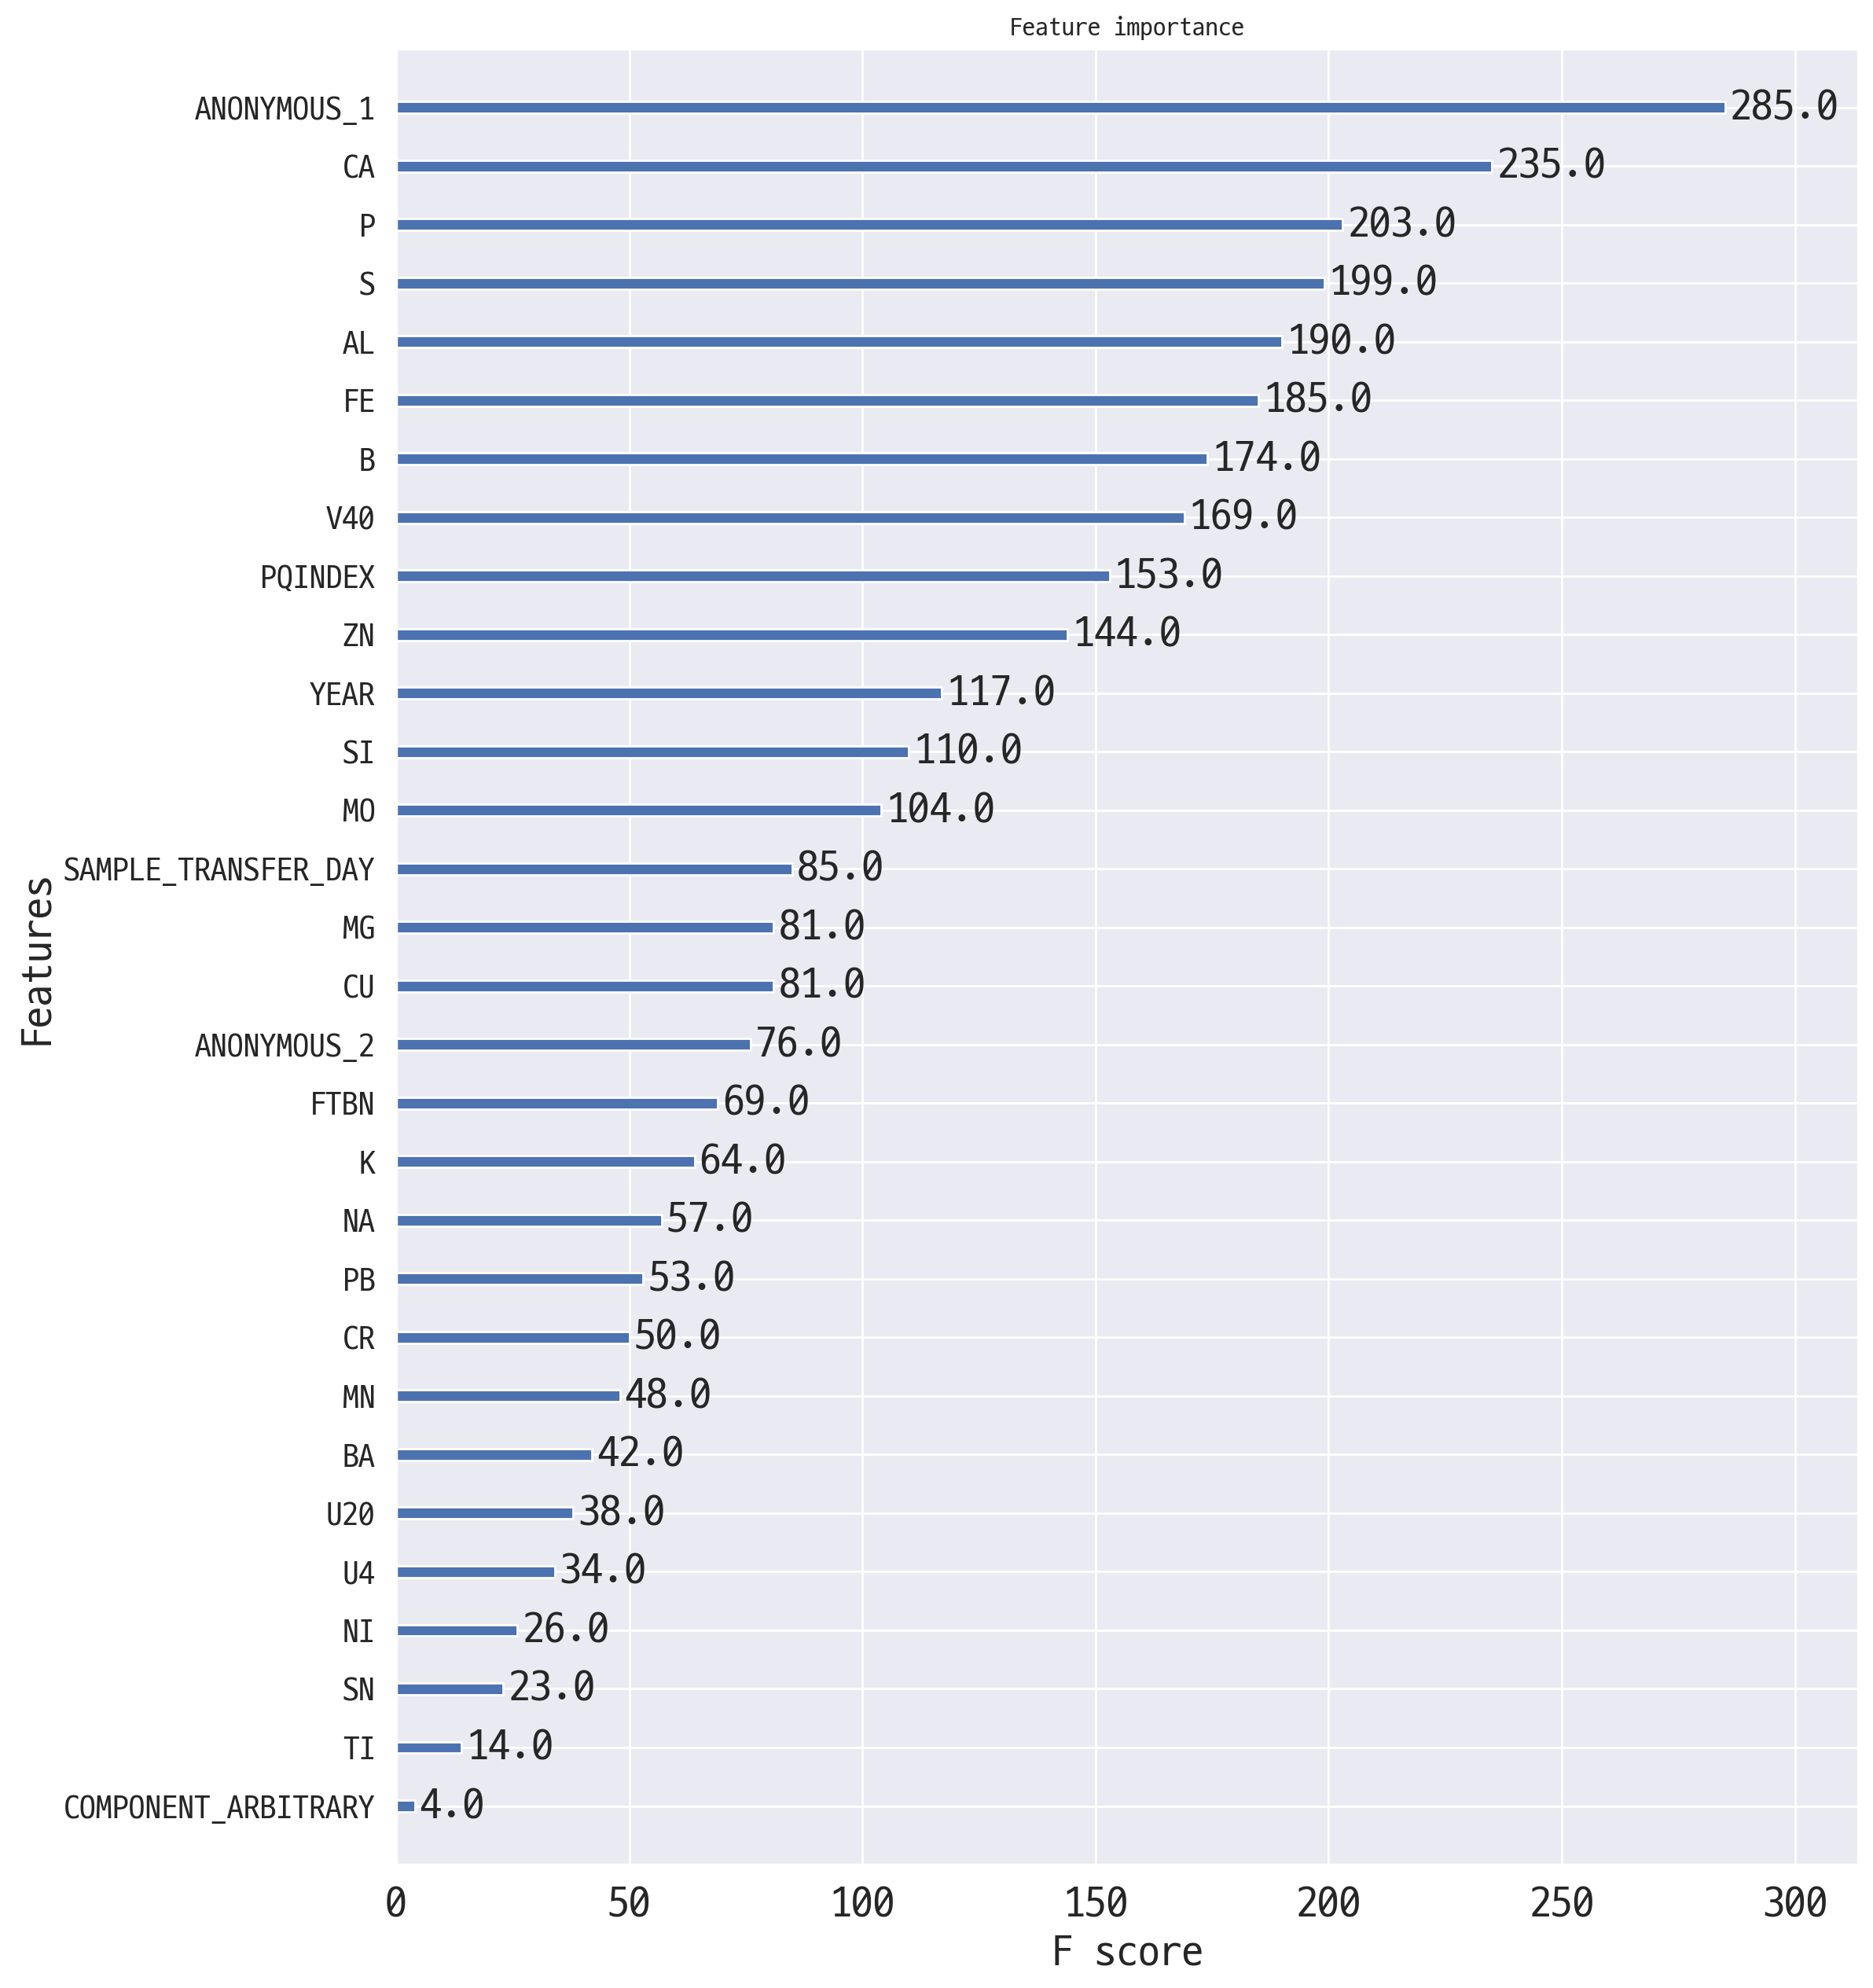

In [89]:
#feature 중요도도 그려볼 수 있다. 
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(12, 15))

# 사이킷런 래퍼 클래스를 입력해도 무방. 
plot_importance(min_XGB, ax=ax)
plt.rc('font', size=20)        # 기본 폰트 크기
plt.rc('axes', labelsize=20)   # x,y축 label 폰트 크기
plt.rc('xtick', labelsize=20)  # x축 눈금 폰트 크기 
plt.rc('ytick', labelsize=20)  # y축 눈금 폰트 크기
plt.rc('legend', fontsize = 30)
plt.show()

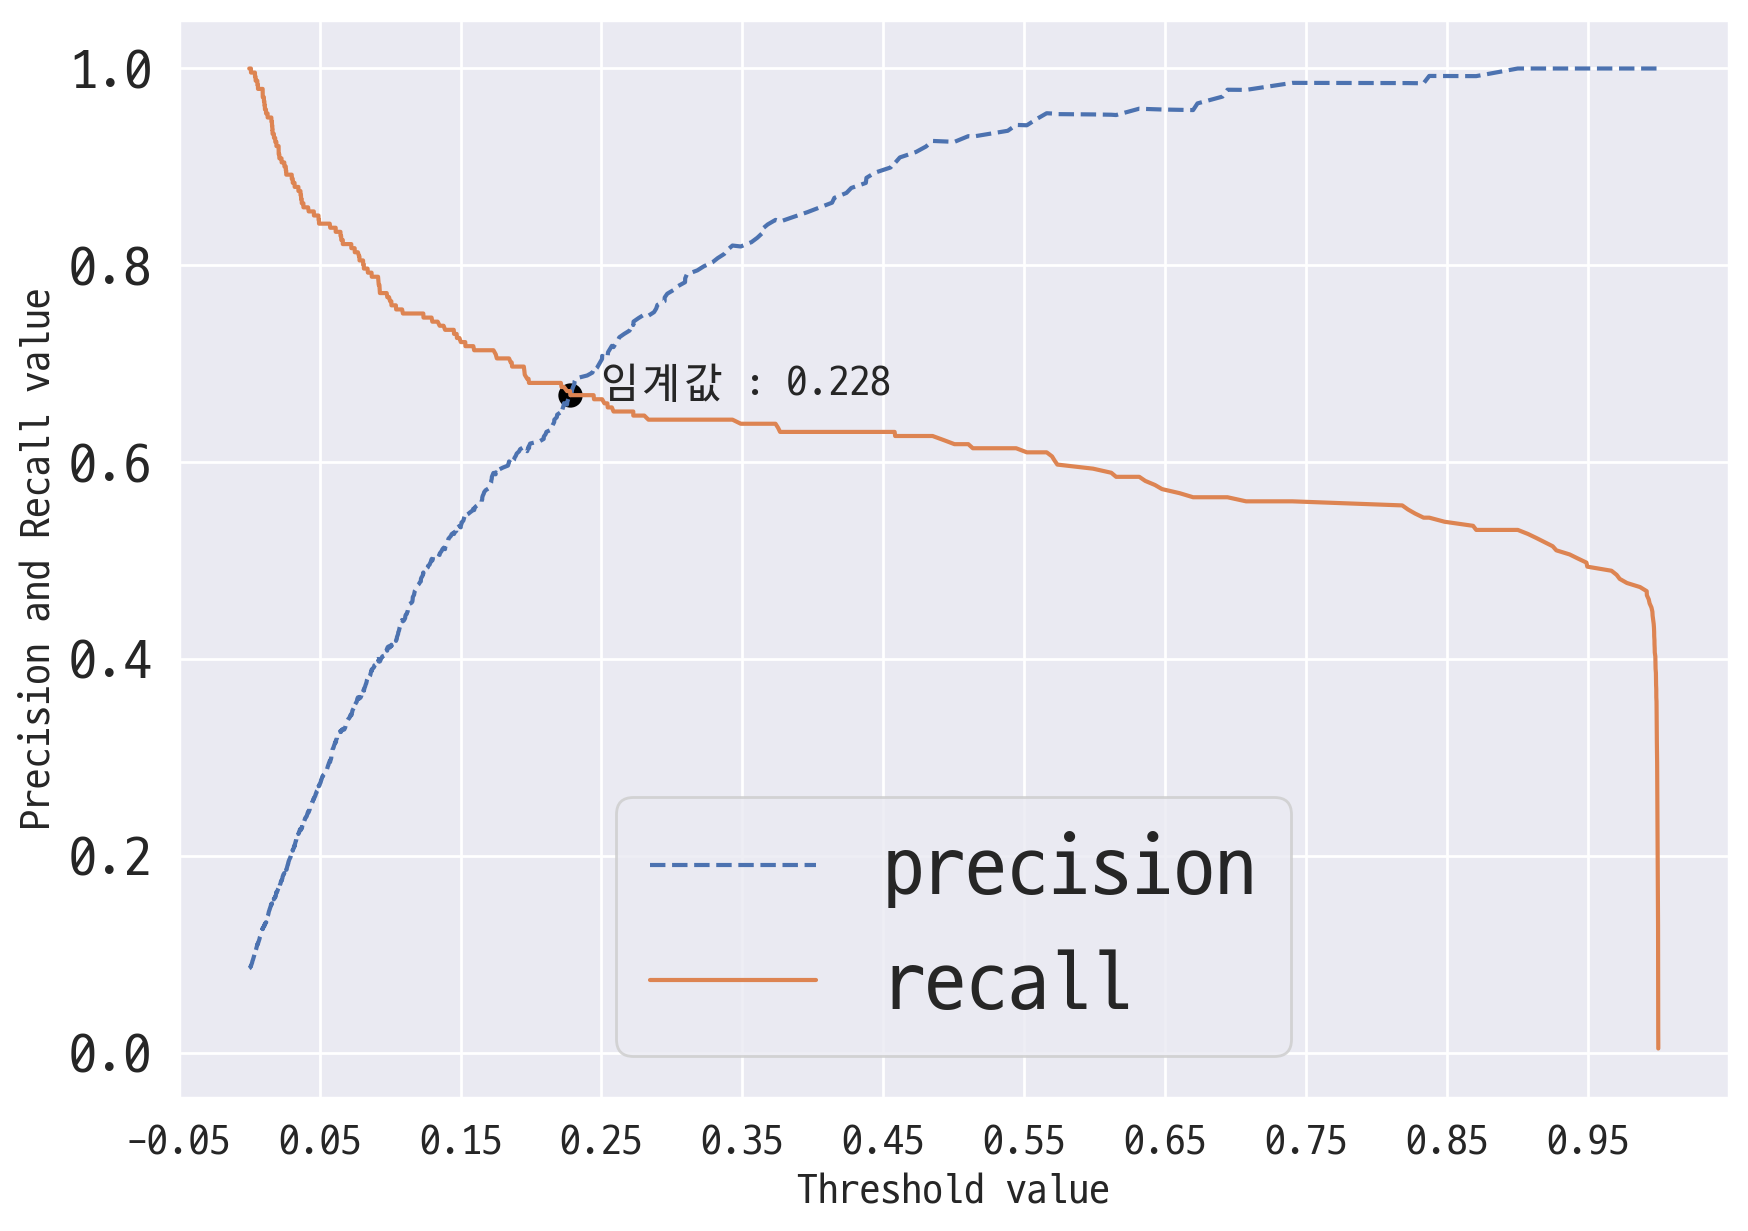

In [83]:
precision_recall_curve_plot(y_test, pred_proba)

In [85]:
binarizer = Binarizer(threshold = 0.228)
thres_pred = binarizer.fit_transform(pred_proba.reshape(-1,1))

get_clf_eval(y_test, thres_pred, pred_proba.reshape(-1,1))

print('Micro f1 socre : ', f1_score(y_test, thres_pred, average='micro'))

오차 행렬
[[2499   79]
 [  80  161]]
정확도 : 0.9436, 정밀도 : 0.6708, 재현율 : 0.6680, F1 : 0.6694, AUC : 0.9097
Macro f1 socre :  0.8193033952196256
Micro f1 socre :  0.9435970202199362


#### step 3

In [ ]:
from xgboost import XGBClassifier 

model = XGBClassifier(random_state=2022, subsample=0.9)

parameters={'max_depth':        [1,2,3,4,5],
            'n_estimators':     [500],
            'learning_rate':    [0.2, 0.5, 0.8],
            'eta':              [0.01, 0.02],
            'min_split_loss':   [2],
            'scale_pos_weight': [1, 3, 5],
            'gamma':            [0, 0.25, 1.0],
           }

grid_search = GridSearchCV(model, parameters, scoring='f1_macro', cv=3, n_jobs=-1) 
grid_search.fit(X_train, y_train) 
grid_search.best_params_

print('교차건증 交叉验证：\n', grid_search.best_score_)
print('최우선 점수 最优选项：\n', grid_search.best_params_)

In [ ]:
min_XGB = XGBClassifier(random_state=2022,
                        eta = 0.01,
                        gamma = 0,
                        learning_rate= 0.2, 
                        max_depth = 4, 
                        min_split_loss = 2,
                        n_estimators = 500,
                        scale_pos_weight = 1)
                        
                        
min_XGB.fit(X_train, y_train) 
min_xgb_pred = min_XGB.predict(X_test)

In [ ]:
pred_X = min_XGB.predict(X_train)
pred_Y = min_XGB.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, min_xgb_pred, average='macro'))

In [ ]:
pred = min_XGB.predict(X_test)
pred_proba = min_XGB.predict_proba(X_test)[:, 1]
get_clf_eval(y_test, pred, pred_proba)

## LightBGM

In [90]:
from lightgbm import LGBMClassifier

In [103]:
evals = [(X_test, y_test)]

lgbm = LGBMClassifier(n_estimators = 2022) # 4천번 
lgbm.fit(X_train, y_train, early_stopping_rounds = 100, #100번 돌림
         eval_metric='auc', eval_set=evals, verbose=True)

lgbm_pred = lgbm.predict(X_test)


parameters={'max_depth': [1,2,3,4,5],
            'n_estimators': [500],
            'learning_rate': [0.2, 0.5, 0.8]}

grid_search = GridSearchCV(model, parameters, scoring='f1_macro', cv=5, n_jobs=-1) 
grid_search.fit(X_train, y_train) 
grid_search.best_params_

print('교차건증：\n', grid_search.best_score_)
print('최우선 점수 ：\n', grid_search.best_params_)

[1]	valid_0's auc: 0.881146	valid_0's binary_logloss: 0.239436
Training until validation scores don't improve for 100 rounds
[2]	valid_0's auc: 0.886549	valid_0's binary_logloss: 0.219977
[3]	valid_0's auc: 0.887153	valid_0's binary_logloss: 0.206344
[4]	valid_0's auc: 0.890715	valid_0's binary_logloss: 0.195854
[5]	valid_0's auc: 0.891058	valid_0's binary_logloss: 0.187624
[6]	valid_0's auc: 0.890548	valid_0's binary_logloss: 0.180504
[7]	valid_0's auc: 0.890426	valid_0's binary_logloss: 0.174475
[8]	valid_0's auc: 0.89094	valid_0's binary_logloss: 0.169529
[9]	valid_0's auc: 0.891625	valid_0's binary_logloss: 0.165257
[10]	valid_0's auc: 0.904525	valid_0's binary_logloss: 0.161021
[11]	valid_0's auc: 0.905426	valid_0's binary_logloss: 0.157788
[12]	valid_0's auc: 0.902977	valid_0's binary_logloss: 0.1551
[13]	valid_0's auc: 0.905961	valid_0's binary_logloss: 0.152274
[14]	valid_0's auc: 0.908387	valid_0's binary_logloss: 0.149821
[15]	valid_0's auc: 0.909606	valid_0's binary_logloss:

[135]	valid_0's auc: 0.918506	valid_0's binary_logloss: 0.13458
[136]	valid_0's auc: 0.918889	valid_0's binary_logloss: 0.134519
[137]	valid_0's auc: 0.9192	valid_0's binary_logloss: 0.134559
[138]	valid_0's auc: 0.91919	valid_0's binary_logloss: 0.13477
[139]	valid_0's auc: 0.919234	valid_0's binary_logloss: 0.134872
[140]	valid_0's auc: 0.919329	valid_0's binary_logloss: 0.135057
[141]	valid_0's auc: 0.919443	valid_0's binary_logloss: 0.134999
[142]	valid_0's auc: 0.919916	valid_0's binary_logloss: 0.13489
[143]	valid_0's auc: 0.920188	valid_0's binary_logloss: 0.134818
[144]	valid_0's auc: 0.920006	valid_0's binary_logloss: 0.134895
[145]	valid_0's auc: 0.919895	valid_0's binary_logloss: 0.134991
[146]	valid_0's auc: 0.919992	valid_0's binary_logloss: 0.135119
[147]	valid_0's auc: 0.919776	valid_0's binary_logloss: 0.135262
[148]	valid_0's auc: 0.919803	valid_0's binary_logloss: 0.13539
[149]	valid_0's auc: 0.91963	valid_0's binary_logloss: 0.135443
[150]	valid_0's auc: 0.919716	val

In [104]:
pred_X = lgbm.predict(X_train)
pred_Y = lgbm.predict(X_test)
pred_proba_Y = lgbm.predict_proba(X_test)[:, 1]

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Micro f1 socre : ', f1_score(y_test, lgbm_pred, average='macro'))
print()
#print(lgbm.score(y_test, pred_Y))


train accuracy score : 0.9739269244412913
test accuracy score : 0.9620432777580702
Micro f1 socre :  0.857025982305583



In [105]:
get_clf_eval(y_test, pred_Y, pred_proba_Y)

오차 행렬
[[2564   14]
 [  93  148]]
정확도 : 0.9620, 정밀도 : 0.9136, 재현율 : 0.6141, F1 : 0.7345, AUC : 0.9282
Macro f1 socre :  0.857025982305583


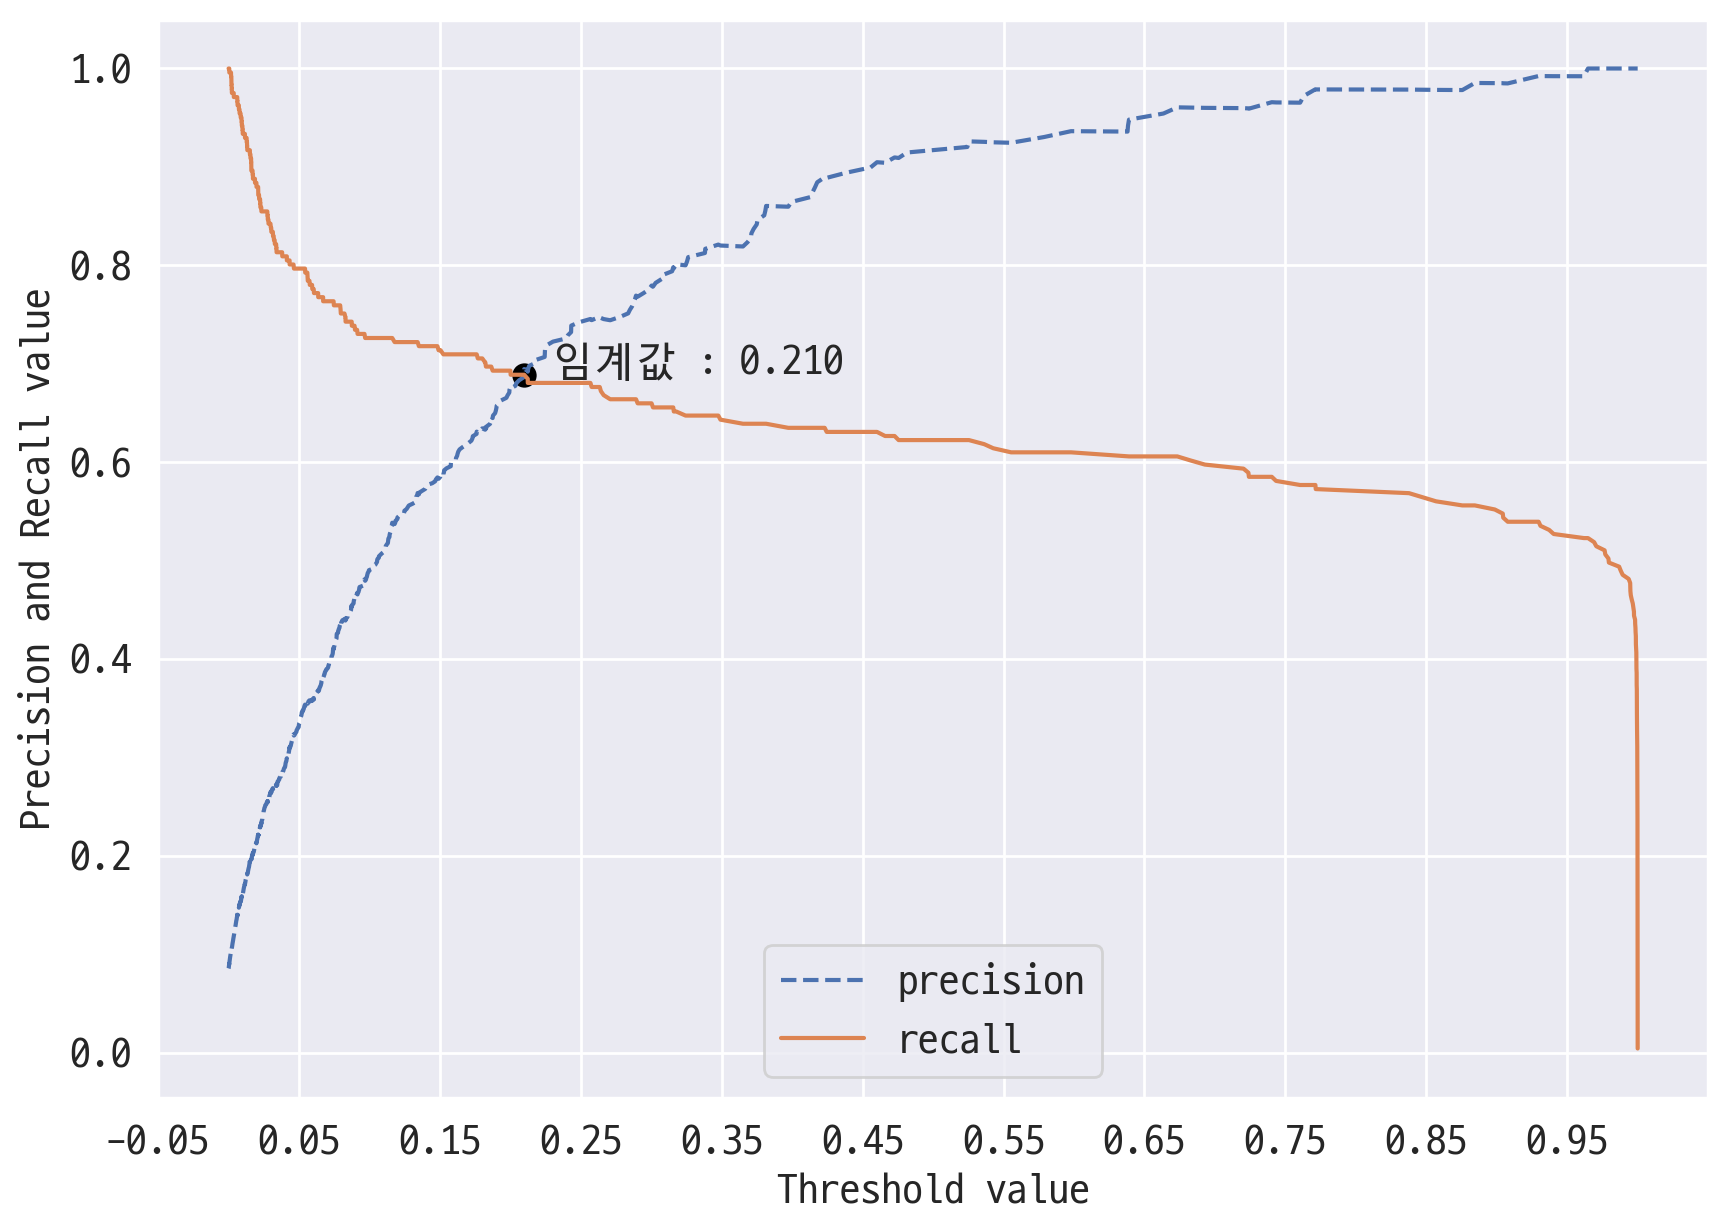

In [106]:
precision_recall_curve_plot(y_test, pred_proba)

In [107]:
for i in np.arange(0, 1, 0.01):
    print('임계값 : ',i)
    binarizer = Binarizer(threshold = i)
    thres_pred = binarizer.fit_transform(pred_proba.reshape(-1,1))

    get_clf_eval(y_test, thres_pred, pred_proba.reshape(-1,1))
    print('\n')

임계값 :  0.0
오차 행렬
[[   0 2578]
 [   0  241]]
정확도 : 0.0855, 정밀도 : 0.0855, 재현율 : 1.0000, F1 : 0.1575, AUC : 0.9100
Macro f1 socre :  0.07875816993464052


임계값 :  0.01
오차 행렬
[[1404 1174]
 [  15  226]]
정확도 : 0.5782, 정밀도 : 0.1614, 재현율 : 0.9378, F1 : 0.2754, AUC : 0.9100
Macro f1 socre :  0.4889843494747812


임계값 :  0.02
오차 행렬
[[1803  775]
 [  29  212]]
정확도 : 0.7148, 정밀도 : 0.2148, 재현율 : 0.8797, F1 : 0.3453, AUC : 0.9100
Macro f1 socre :  0.5814819738970507


임계값 :  0.03
오차 행렬
[[2016  562]
 [  39  202]]
정확도 : 0.7868, 정밀도 : 0.2644, 재현율 : 0.8382, F1 : 0.4020, AUC : 0.9100
Macro f1 socre :  0.6361342435244455


임계값 :  0.04
오차 행렬
[[2101  477]
 [  46  195]]
정확도 : 0.8145, 정밀도 : 0.2902, 재현율 : 0.8091, F1 : 0.4272, AUC : 0.9100
Macro f1 socre :  0.6582376837798525


임계값 :  0.05
오차 행렬
[[2195  383]
 [  49  192]]
정확도 : 0.8468, 정밀도 : 0.3339, 재현율 : 0.7967, F1 : 0.4706, AUC : 0.9100
Macro f1 socre :  0.6904994266474735


임계값 :  0.06
오차 행렬
[[2244  334]
 [  54  187]]
정확도 : 0.8624, 정밀도 : 0.3589, 재현율 : 0.7759, F

오차 행렬
[[2573    5]
 [ 102  139]]
정확도 : 0.9620, 정밀도 : 0.9653, 재현율 : 0.5768, F1 : 0.7221, AUC : 0.9100
Macro f1 socre :  0.8508543046521344


임계값 :  0.77
오차 행렬
[[2575    3]
 [ 102  139]]
정확도 : 0.9628, 정밀도 : 0.9789, 재현율 : 0.5768, F1 : 0.7258, AUC : 0.9100
Macro f1 socre :  0.8529337967321935


임계값 :  0.78
오차 행렬
[[2575    3]
 [ 104  137]]
정확도 : 0.9620, 정밀도 : 0.9786, 재현율 : 0.5685, F1 : 0.7192, AUC : 0.9100
Macro f1 socre :  0.8494031455122704


임계값 :  0.79
오차 행렬
[[2575    3]
 [ 104  137]]
정확도 : 0.9620, 정밀도 : 0.9786, 재현율 : 0.5685, F1 : 0.7192, AUC : 0.9100
Macro f1 socre :  0.8494031455122704


임계값 :  0.8
오차 행렬
[[2575    3]
 [ 104  137]]
정확도 : 0.9620, 정밀도 : 0.9786, 재현율 : 0.5685, F1 : 0.7192, AUC : 0.9100
Macro f1 socre :  0.8494031455122704


임계값 :  0.81
오차 행렬
[[2575    3]
 [ 104  137]]
정확도 : 0.9620, 정밀도 : 0.9786, 재현율 : 0.5685, F1 : 0.7192, AUC : 0.9100
Macro f1 socre :  0.8494031455122704


임계값 :  0.8200000000000001
오차 행렬
[[2575    3]
 [ 104  137]]
정확도 : 0.9620, 정밀도 : 0.9786, 재현율 : 0.5685, 

In [102]:
# 튜닝
parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
             'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]} #Define the scoring


clf = GridSearchCV(lgbm, parameters, scoring='accuracy', cv = 5)
clf.fit(X_train_over, y_train_over)

lgbm_pred = clf.predict(X_test)

KeyboardInterrupt: 

In [ ]:
print(clf.score(X_train_over, y_train_over))
print(clf.score(X_test, y_test))
print('Macro f1 socre : ', f1_score(y_test, lgbm_pred, average='macro'))

## 의사결정 트리

In [97]:
from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier(random_state = 2022)
dtree.fit(X_train_over, y_train_over)

DecisionTreeClassifier(random_state=2022)

In [98]:
tree_model = DecisionTreeClassifier(max_depth = 10, min_samples_leaf = 6, random_state = 2022)
tree_model.fit(X_train, y_train)

tree_pred = tree_model.predict(X_test)

pred_X = tree_model.predict(X_train)
pred_Y = tree_model.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, tree_pred, average='macro'))

train accuracy score : 0.9597374955658035
test accuracy score : 0.9574317133735367
Macro f1 socre :  0.8428878757816592


## GridSearchCV

In [99]:
from sklearn.model_selection import GridSearchCV

tree_model = DecisionTreeClassifier(random_state = 2022)

params = {
    'max_depth':[2, 3, 4, 5, 6, 7, 8, 9, None],
    'min_samples_leaf':[9, 10, 11, 12, 13],
    'min_samples_split':[2, 3, 4, 5]
}
#                                                      #돌림        코어제어(시스템모든 코어 사용함) : 이유 느리기때문에
tree_gs = GridSearchCV(tree_model, param_grid = params, cv = 5, refit = True, n_jobs=-1)
tree_gs.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=2022),
             n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, None],
                         'min_samples_leaf': [9, 10, 11, 12, 13],
                         'min_samples_split': [2, 3, 4, 5]})

In [100]:
tree_gs_num = tree_gs.best_params_
tree_gs_num

{'max_depth': 3, 'min_samples_leaf': 9, 'min_samples_split': 2}

In [101]:
tree_gsCV_pree = tree_gs.predict(X_test)

In [102]:
print('Macro f1 socre : ', f1_score(y_test, tree_gsCV_pree, average='macro'))

Macro f1 socre :  0.8514946860790473


In [103]:
tree_model = DecisionTreeClassifier(max_depth = 3, min_samples_leaf =9, min_samples_split= 2, random_state = 2022)
tree_model.fit(X_train, y_train)
tree_gsCV_pred = tree_model.predict(X_test)

pred_X = tree_model.predict(X_train)
pred_Y = tree_model.predict(X_test)

print('train accuracy score :', accuracy_score(y_train, pred_X))
print('test accuracy score :', accuracy_score(y_test, pred_Y))
print('Macro f1 socre : ', f1_score(y_test, tree_gsCV_pred, average='macro'))

train accuracy score : 0.9531748847108904
test accuracy score : 0.9627527492018446
Macro f1 socre :  0.8514946860790473


## Voting

In [104]:
# 부팅 분류기 Voting
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

f1_list = []

#
lg = LogisticRegression()
knn = KNeighborsClassifier(n_neighbors = 2)


voting_model = VotingClassifier(estimators = [('lg', lg), ('knn',knn)], voting = 'soft')

voting_model.fit(X_train, y_train)
pred = voting_model.predict(X_test)


#각 모델 에측과 평가
models = [lg, knn]
for model in models :
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    model_name = model.__class__.__name__
    
    pred_X = model.predict(X_train)
    pred_Y = model.predict(X_test)

    print('train accuracy score :', accuracy_score(y_train, pred_X))
    print('test accuracy score :', accuracy_score(y_test, pred_Y))
    print('Macro f1 socre : ', f1_score(y_test, pred, average='macro'))
    print()

train accuracy score : 0.951135154310039
test accuracy score : 0.961688542036183
Macro f1 socre :  0.8483647708527575

train accuracy score : 0.9417346576800284
test accuracy score : 0.9326002128414331
Macro f1 socre :  0.6815166564392372



# 딥러닝 : 분류

## 경사하강법

In [105]:
from sklearn.linear_model import SGDClassifier 

In [106]:
sc = SGDClassifier(loss = 'log', max_iter=25, tol = None, random_state=2022) # 이진분류
sc.fit(X_train, y_train)

SGDClassifier(loss='log', max_iter=25, random_state=2022, tol=None)

In [107]:
print(sc.score(X_train, y_train))
print(sc.score(X_test, y_test))

0.9501596310748492
0.9595601277048599


In [108]:
sc.partial_fit(X_train, y_train)
print(sc.score(X_train, y_train))
print(sc.score(X_test, y_test))

0.9482972685349415
0.9584959205391983


In [109]:
# sc.predict(y_test)

In [110]:
params = {
    'max_iter':[20, 30]
}

sc_gs = GridSearchCV(sc, param_grid = params, cv = 5, refit = True, n_jobs=-1, )
sc_gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=SGDClassifier(loss='log', max_iter=25, random_state=2022,
                                     tol=None),
             n_jobs=-1, param_grid={'max_iter': [20, 30]})

In [111]:
#y_test_np = y_test.to_numpy()
#y_test_np.reshape(-1, 1)
# sc_gs.predict(y_test)

### 애포크 찾기

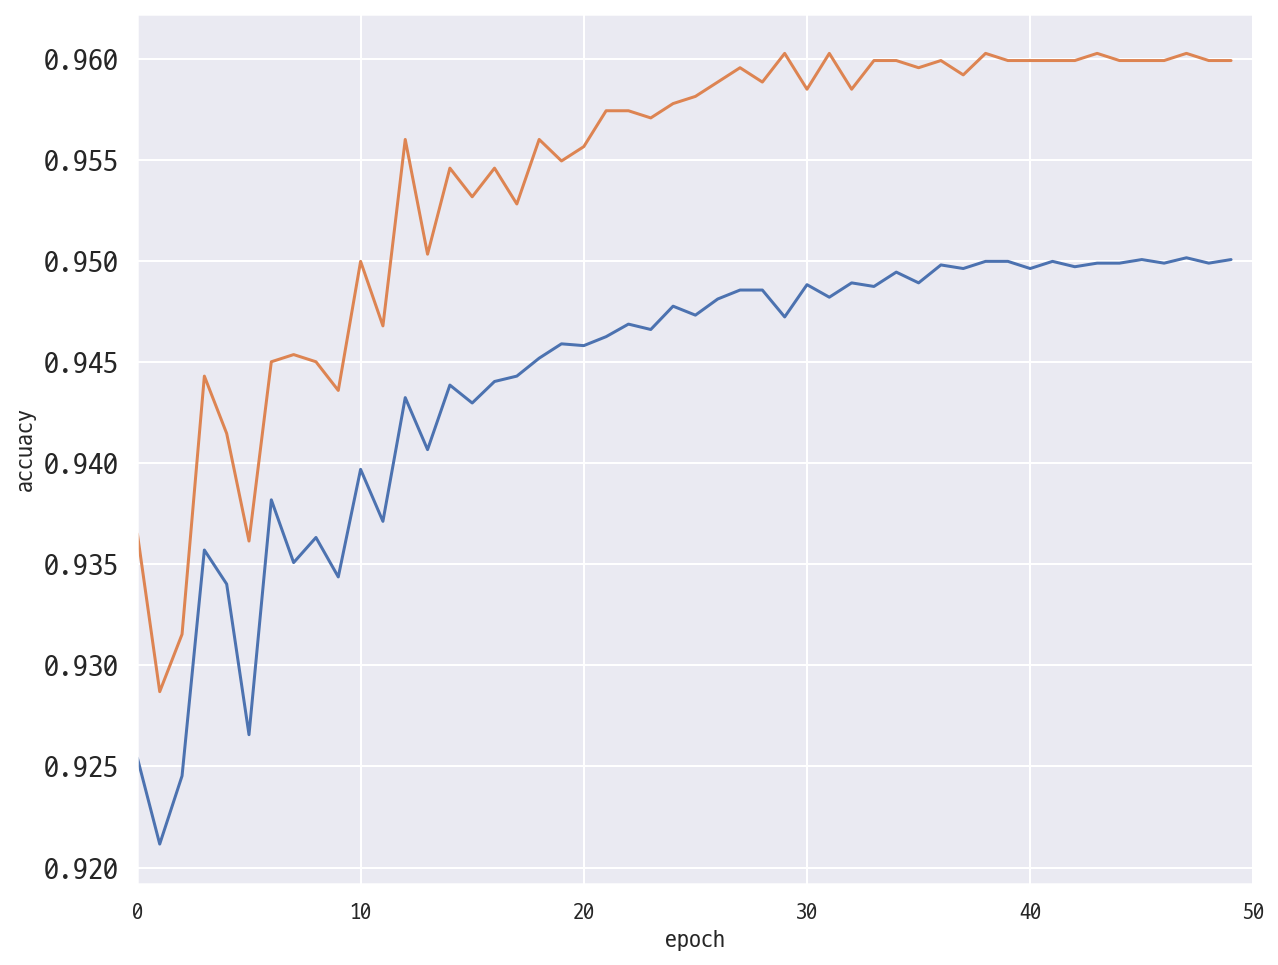

In [112]:
sc = SGDClassifier(loss = 'log', random_state=2022)

train_score = []
test_score = []


classes = np.unique(y_train)


for _ in range(0, 50) :
    sc.partial_fit(X_train, y_train, classes = classes)
    train_score.append(sc.score(X_train, y_train))
    test_score.append(sc.score(X_test, y_test))
    
plt.plot(train_score)
plt.plot(test_score)
plt.xlabel('epoch')
plt.ylabel('accuacy')
plt.xlim(0, 50)
plt.show()

## PCA

In [113]:
from sklearn.decomposition import PCA

In [114]:
X_train.shape

(11276, 43)

In [115]:
pca = PCA(n_components = 0.95, whiten = True)
pca_data = pca.fit_transform(X_train)
pca_data.shape

(11276, 32)

In [116]:
# pca_data = pd.DataFrame(pca_data, columns = ['pca_x','pca_y'])

In [117]:
# 변동성
pca.explained_variance_ratio_.sum()

0.9500237817412925

## K-means

In [118]:
from sklearn.cluster import KMeans 

In [119]:
# target_t = target_t.to_numpy()

In [120]:
kmeans = KMeans(n_clusters=2, init='k-means++', max_iter=25, random_state=2022)
kmeans.fit(X_train)
cluster = kmeans.predict(X_test)

In [121]:
print(kmeans.score(X_train, y_train))
print(kmeans.score(X_test, y_test))
print('Macro f1 socre : ', f1_score(y_test, cluster, average='macro'))

-451397.7877995277
-88856.39837340018
Macro f1 socre :  0.30157275991971205


In [122]:
k_means_df = pd.DataFrame()
k_means_df['target'] = y_test
k_means_df['cluster'] = cluster

In [123]:
k_means_df

,target,cluster
3651,0,1
4471,0,0
13638,0,0
7171,0,0
12190,0,1
...,...,...
7889,0,0
12788,0,1
11153,0,0
1541,0,1


In [124]:
#pca_sample_df = pd.concat([pca_data,k_means_df], axis=1)
#center = kmeans.cluster_centers_

In [125]:
# center

In [127]:
# plt.scatter(pca_sample_df['pca_x'], pca_sample_df['pca_y'], c=pca_sample_df['cluster'], cmap='YlGnBu')
# plt.scatter(center[:,0], center[:, 1], c='red', marker='D')
# plt.ylim(0, 20)
# plt.show()

In [ ]:
# from sklearn.cluster import DBSCAN # 引入DBSCAN模块
# dbscan = DBSCAN(eps=0.05, min_samples=9).fit(X_train)
# label_pred = dbscan.labels_ 
# pd.DataFrame(label_pred).value_counts()

In [ ]:

# y_pred=DBSCAN(eps=0.05,min_samples=10).fit_predict(X_test)
# plt.subplot(122)
# plt.scatter(X_test[:, 0], X_test[:, 1],c=y_pred)
# plt.title('DBSCAN Cluster Result')
# if flag:
#     plt.savefig('circleData.png')
# else:
#     plt.savefig('blobData.png')


## DBSCAN

In [128]:
from sklearn.cluster import DBSCAN

In [129]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.6, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X_train)

df = pd.DataFrame()

df['dbscan_cluster'] = dbscan_labels
df['target'] = y_train

df_result = df.groupby(['target'])['dbscan_cluster'].value_counts()
print(df_result)

target  dbscan_cluster
0.0     -1                7636
         0                 297
         2                  83
         4                  33
         6                  25
         3                  17
         8                  14
         14                 14
         9                  13
         11                 13
         12                 13
         5                  12
         1                  11
         7                  11
         15                 10
         13                  8
         16                  8
         17                  7
         10                  5
         18                  4
1.0     -1                 725
         0                  26
         2                  14
         6                   5
         4                   3
         10                  2
         16                  2
         3                   1
         5                   1
         7                   1
         11                  1
         12     

In [130]:
### 클러스터 결과를 담은 DataFrame과 사이킷런의 Cluster 객체등을 인자로 받아 클러스터링 결과를 시각화하는 함수  
def visualize_cluster_plot(clusterobj, dataframe, label_name, iscenter=True):
    if iscenter :
        centers = clusterobj.cluster_centers_
        
    unique_labels = np.unique(dataframe[label_name].values)
    markers=['o', 's', '^', 'x', '*']
    isNoise=False

    for label in unique_labels:
        label_cluster = dataframe[dataframe[label_name]==label]
        if label == -1:
            cluster_legend = 'Noise'
            isNoise=True
        else :
            cluster_legend = 'Cluster '+str(label)
        
        plt.scatter(x=label_cluster['ftr1'], y=label_cluster['ftr2'], s=70,\
                    edgecolor='k', marker=markers[label], label=cluster_legend)
        
        if iscenter:
            center_x_y = centers[label]
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=250, color='white',
                        alpha=0.9, edgecolor='k', marker=markers[label])
            
            plt.scatter(x=center_x_y[0], y=center_x_y[1], s=70, color='k',\
                        edgecolor='k', marker='$%d$' % label)
    if isNoise:
        legend_loc='upper center'
    else: legend_loc='upper right'
    
    plt.legend(loc=legend_loc)
    plt.show()

In [131]:
from sklearn.decomposition import PCA


# 2차원으로 시각화하기 위해 PCA n_componets=2로 피처 데이터 세트 변환
pca = PCA(n_components=2, random_state=2022)
pca_transformed = pca.fit_transform(X_train)


# visualize_cluster_2d( ) 함수는 ftr1, ftr2 컬럼을 좌표에 표현하므로 PCA 변환값을 해당 컬럼으로 생성
df['ftr1'] = pca_transformed[:, 0]
df['ftr2'] = pca_transformed[:, 1]

# visualize_cluster_plot(dbscan, df, 'dbscan_cluster', iscenter=False)

In [132]:
# visualize_cluster_plot(dbscan, df, 'dbscan_cluster', iscenter=False)

In [133]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.8, min_samples=8, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X_train)

df['dbscan_cluster'] = dbscan_labels
df['target'] = y_train

df_result = df.groupby(['target'])['dbscan_cluster'].value_counts()
print(df_result)

#visualize_cluster_plot(dbscan, df, 'dbscan_cluster', iscenter=False)

target  dbscan_cluster
0.0     -1                6521
         0                 648
         2                 267
         3                 229
         5                 115
         1                 100
         4                  69
         9                  43
         6                  39
         8                  37
         13                 29
         10                 19
         11                 15
         14                 13
         21                 12
         12                 11
         7                  10
         16                  9
         18                  8
         20                  8
         22                  7
         24                  7
         17                  6
         19                  6
         15                  3
         23                  3
1.0     -1                 619
         0                  67
         2                  35
         3                  29
         5                   6
         1      

target  dbscan_cluster
0.0     -1                7924
         0                 244
         1                  41
         3                  15
         2                  10
1.0     -1                 751
         0                  23
         1                   8
         2                   1
         3                   1
Name: dbscan_cluster, dtype: int64


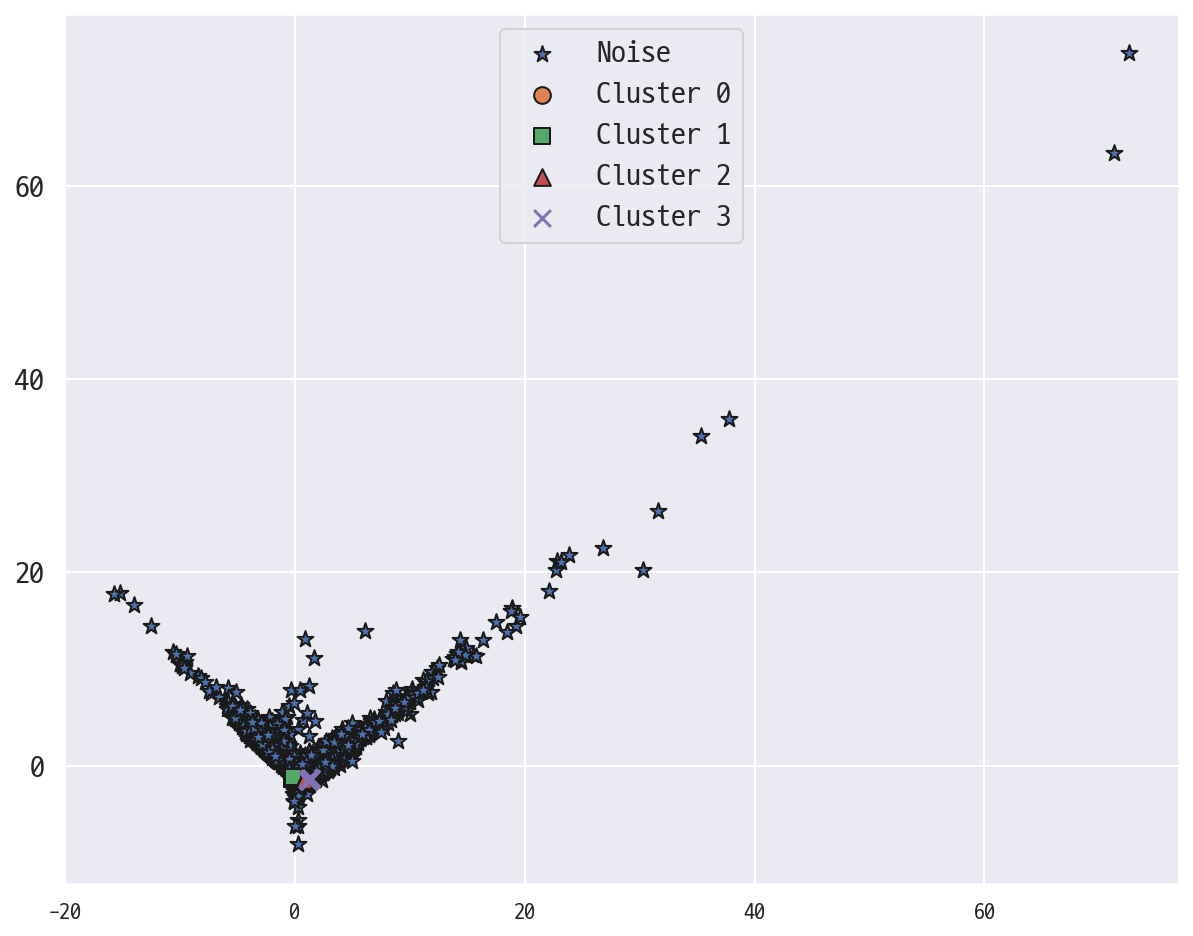

In [134]:
dbscan = DBSCAN(eps=0.6, min_samples=16, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X_train)

df['dbscan_cluster'] = dbscan_labels
df['target'] = y_train

df_result = df.groupby(['target'])['dbscan_cluster'].value_counts()
print(df_result)
visualize_cluster_plot(dbscan, df, 'dbscan_cluster', iscenter=False)

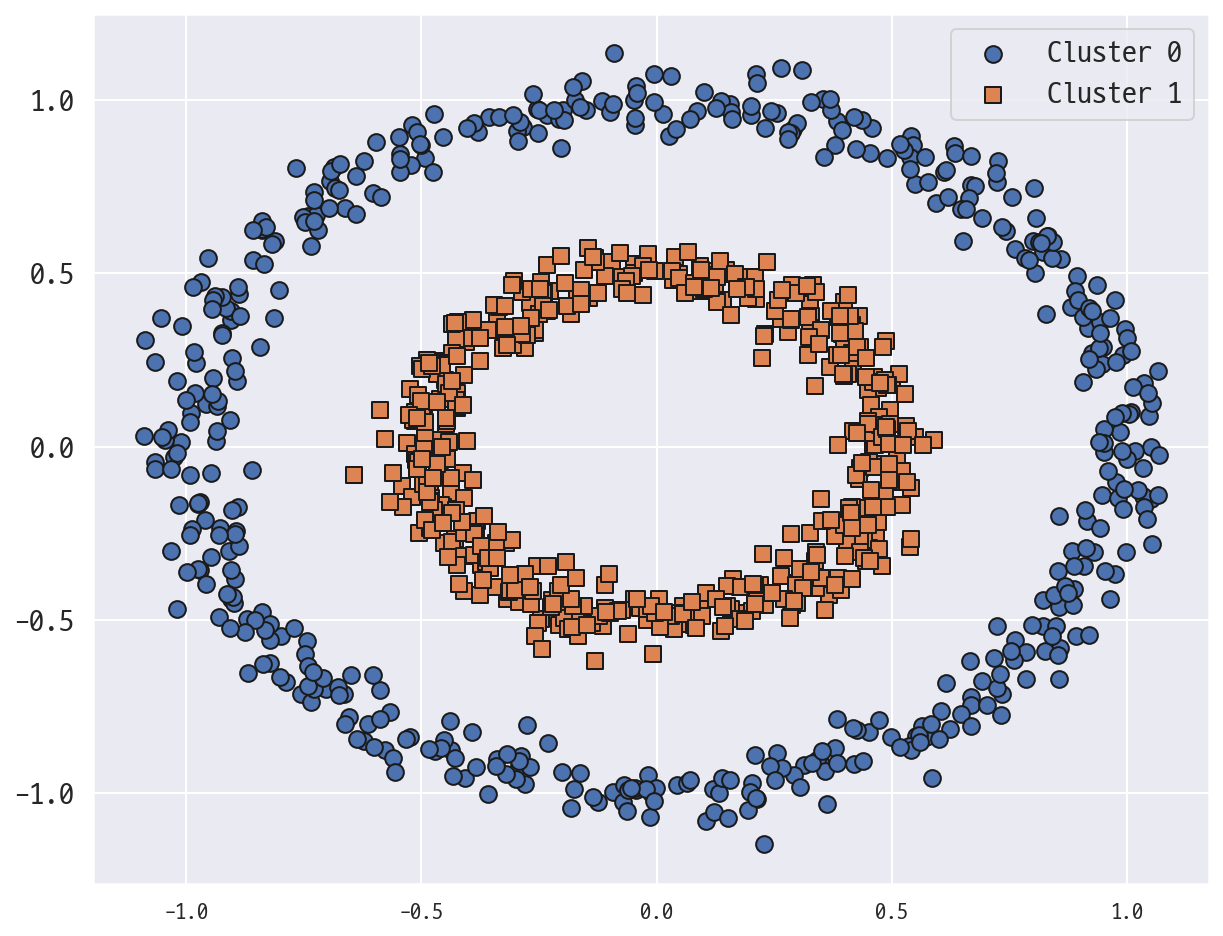

In [135]:
from sklearn.datasets import make_circles

X, y = make_circles(n_samples=1000, shuffle=True, noise=0.05, random_state=2022, factor=0.5)
clusterDF = pd.DataFrame(data=X, columns=['ftr1', 'ftr2'])
clusterDF['target'] = y

visualize_cluster_plot(None, clusterDF, 'target', iscenter=False)

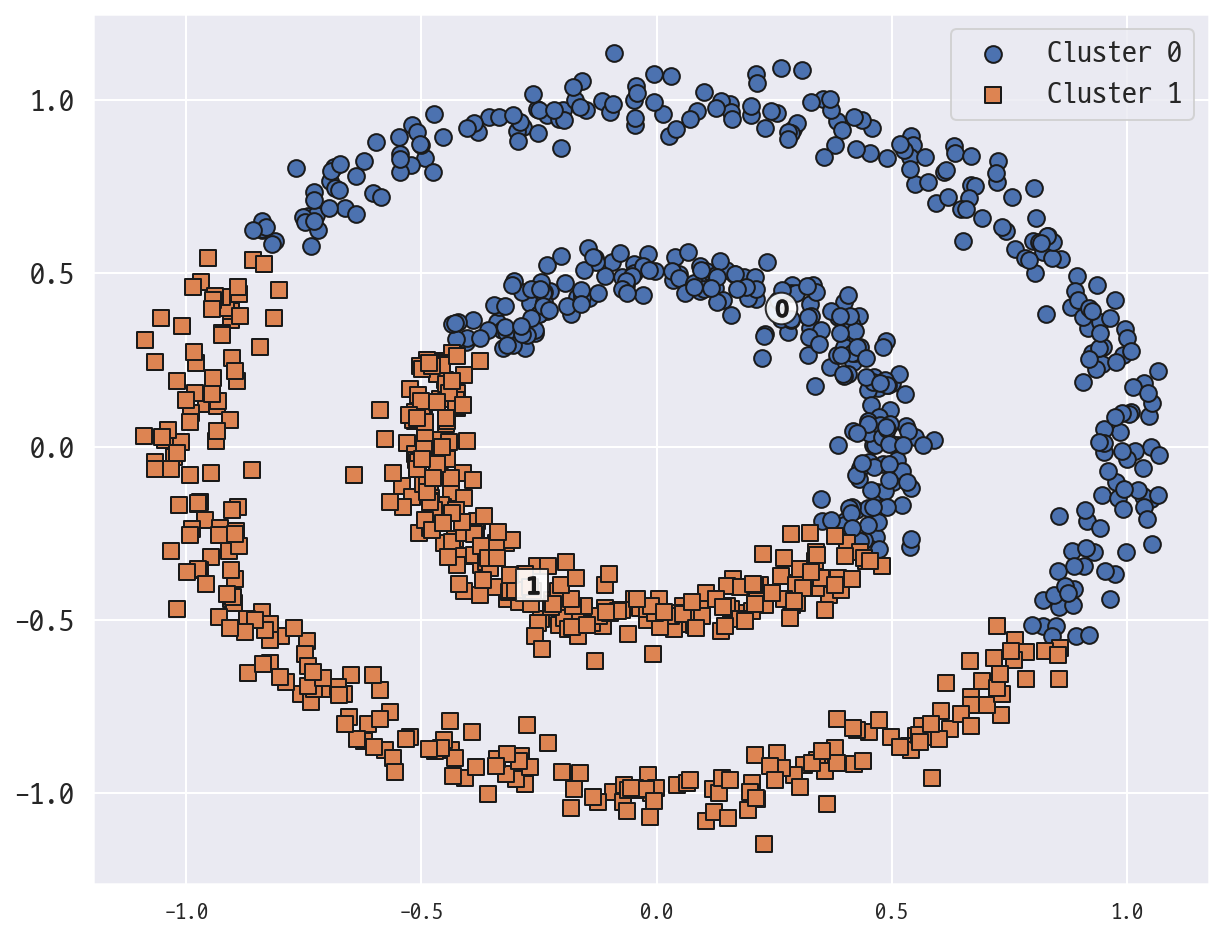

In [136]:
# KMeans로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2, max_iter=1000, random_state=0)
kmeans_labels = kmeans.fit_predict(X)
clusterDF['kmeans_cluster'] = kmeans_labels

visualize_cluster_plot(kmeans, clusterDF, 'kmeans_cluster', iscenter=True)

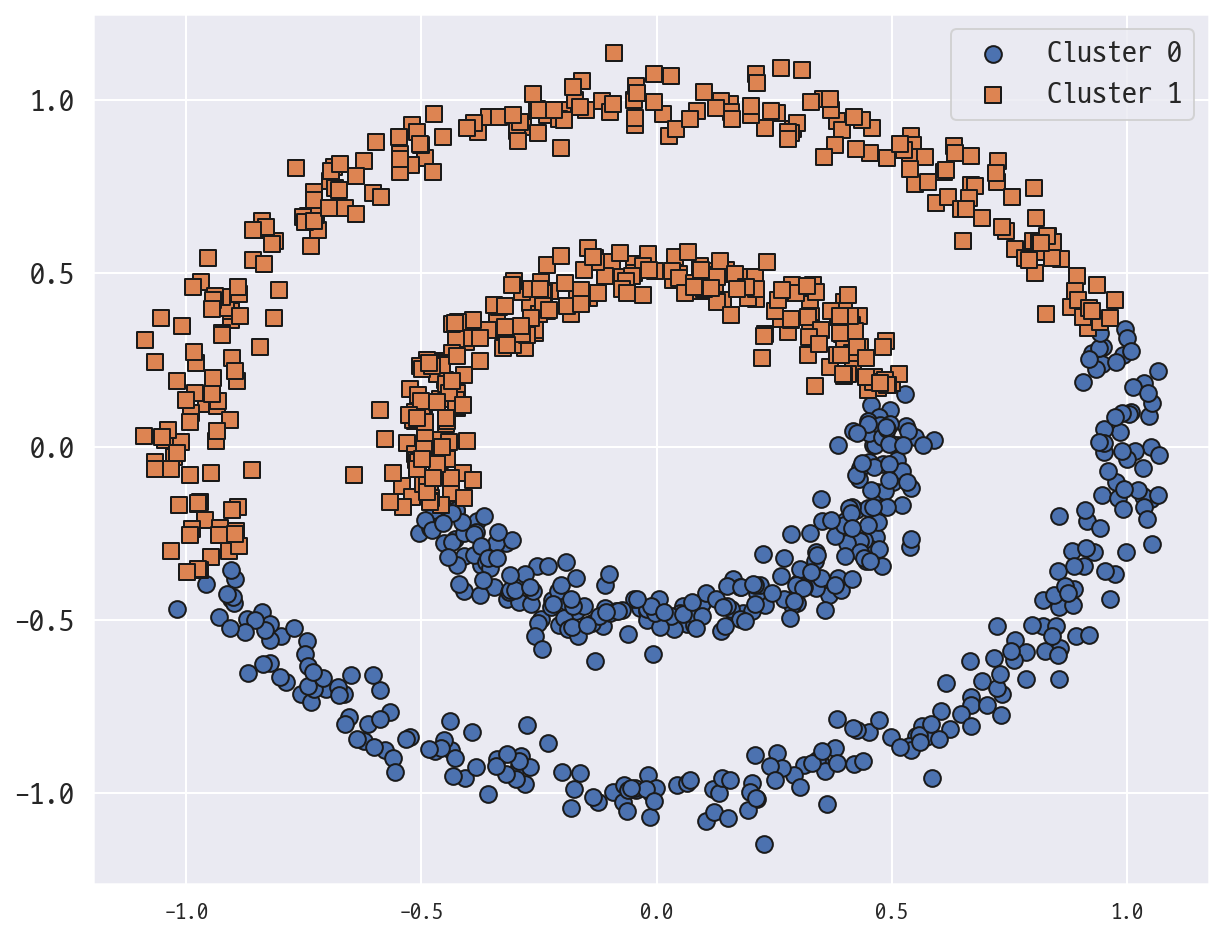

Macro f1 socre :  0.505950595059506


In [137]:
# GMM으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=2, random_state=0)
gmm_label = gmm.fit(X).predict(X)
clusterDF['gmm_cluster'] = gmm_label

visualize_cluster_plot(gmm, clusterDF, 'gmm_cluster', iscenter=False)

get_f1_score(y, gmm_label)

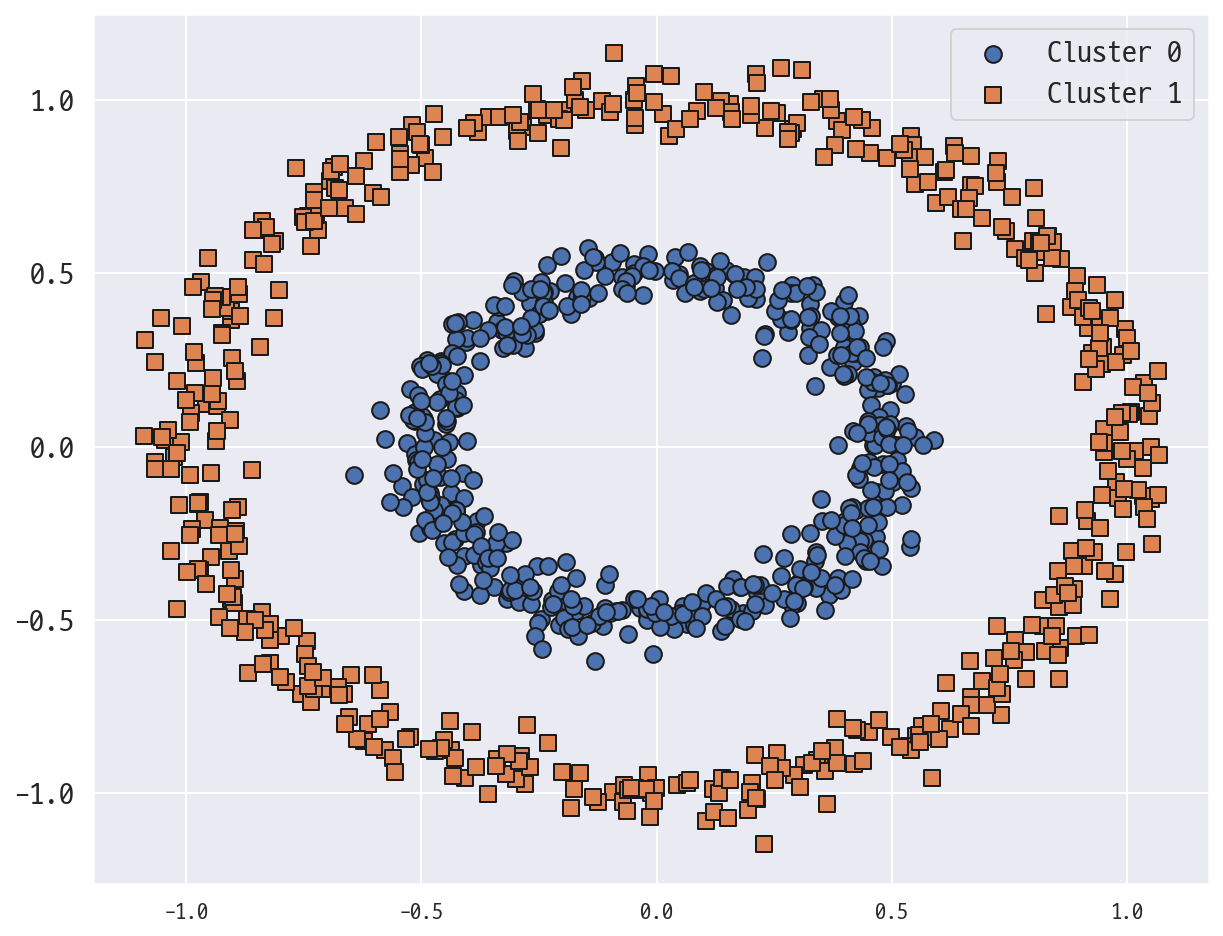

Macro f1 socre :  0.0


In [138]:
# DBSCAN으로 make_circles( ) 데이터 셋을 클러스터링 수행. 
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(eps=0.2, min_samples=10, metric='euclidean')
dbscan_labels = dbscan.fit_predict(X)
clusterDF['dbscan_cluster'] = dbscan_labels

visualize_cluster_plot(dbscan, clusterDF, 'dbscan_cluster', iscenter=False)
get_f1_score(y, dbscan_labels)

## Staking Model

### 데이터 Numpy로 세팅

In [139]:
nX_train = X_train.to_numpy()
nX_test = X_test.to_numpy()

### 개별 모델 생성

In [140]:
from sklearn.ensemble import AdaBoostClassifier

knn_clf = KNeighborsClassifier(n_neighbors=4)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=2022)
dt_clf = DecisionTreeClassifier()
ada_clf = AdaBoostClassifier(n_estimators=100)

lr_final = LogisticRegression()

### 모델 개별 학습

In [141]:
knn_clf.fit(nX_train, y_train)
rf_clf.fit(nX_train, y_train)
dt_clf.fit(nX_train, y_train)
ada_clf.fit(nX_train, y_train)

# knn_clf.fit(X_train_voer, y_train_over)
# rf_clf.fit(X_train_voer, y_train_over)
# dt_clf.fit(X_train_voer, y_train_over)
# aba_clf.fit(X_train_voer, y_train_over)

AdaBoostClassifier(n_estimators=100)

### 개별 모델 예측

In [142]:
# 삭습된 개별 모델들이 각자 반환하는 예측 데이터 세트를 생성하고 개별 모델의 정확도 측정

knn_pred = knn_clf.predict(nX_test)
rf_pred = rf_clf.predict(nX_test)
dt_pred = dt_clf.predict(nX_test)
ada_pred = ada_clf.predict(nX_test)
#gbm_pred = gbm_clf.predict(X_test)

### 개별 모델 정확도 확인

In [143]:
print('Knn 정확도 : %.4f' %(accuracy_score(y_test, knn_pred)))
print('RandomForst 정확도 : %.4f' %(accuracy_score(y_test, rf_pred)))
print('결정 트리 정확도 : %.4f' %(accuracy_score(y_test, dt_pred)))
print('ada부스트 정확도 : %.4f' %(accuracy_score(y_test, ada_pred)))
print()

models = [knn_pred , rf_pred, dt_pred, ada_pred]
name = ['knn', 'RandomForst', '결정 트리', 'ada부스트']


for i in range(len(name)):
    get_f1(name[i], y_test, models[i])

Knn 정확도 : 0.9344
RandomForst 정확도 : 0.9628
결정 트리 정확도 : 0.9301
ada부스트 정확도 : 0.9610

knn Macro f1 socre :  0.6813457271921286
RandomForst Macro f1 socre :  0.8529337967321935
결정 트리 Macro f1 socre :  0.788772690533923
ada부스트 Macro f1 socre :  0.8477712322042218


### 로지스틱 - 예측값을 피처값으로, 로지스틱 회귀에 재사용

In [144]:
pred = np.array([knn_pred, rf_pred, dt_pred, ada_pred])
print(pred.shape)

# transpose를 이용해 행과 열의 위치 교환. 칼럼 레벨로 각 알고리즘의 예측결과를 피처로 만듦
pred = np.transpose(pred)
print(pred.shape)

(4, 2819)
(2819, 4)


In [145]:
pred

array([[0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       ...,
       [0, 0, 0, 0],
       [0, 0, 0, 0],
       [0, 0, 0, 0]], dtype=int64)

### LogisticRegression

In [146]:
lr_final.fit(pred, y_test)
final = lr_final.predict(pred)

print('최종 메타 모델의 이측 정확도 : %.4f' %(accuracy_score(y_test, final)))
get_f1('LogisticRegression', y_test, final)

최종 메타 모델의 이측 정확도 : 0.9624
LogisticRegression Macro f1 socre :  0.8511728306517805


In [147]:
print(X_train.shape)
print(y_train.shape)

(11276, 43)
(11276,)


In [181]:
nX_train

array([[-0.33873415, -0.47945085, -0.3407601 , ..., -0.1065502 ,
        -0.24300876,  1.62180439],
       [-0.27848662, -0.3938433 , -0.3407601 , ..., -0.1065502 ,
         0.38387316, -1.05251271],
       [-0.4649219 , -0.22262821, -0.00257617, ..., -0.1065502 ,
        -0.98881683,  1.27011852],
       ...,
       [-0.32331647,  0.03419443, -0.3407601 , ..., -0.1065502 ,
         0.49473652, -1.05251271],
       [-0.41843167, -0.30823576, -0.3407601 , ..., -0.1065502 ,
        -1.327454  ,  0.05144238],
       [-0.26733845, -0.13702066, -0.3407601 , ..., -0.1065502 ,
         0.93617427, -1.08448415]])

### 스텝 1

In [149]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

# 메타 모델을 위한 학습 및 테스트 데이터 만들기
def get_stacking_base_datasets(model, X_train_n, y_train_n, X_test_n, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False)
    # 빈 배열 생성
    train_fold_pred = np.zeros((X_train_n.shape[0],1))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train_n)):
        print('폴드 세트 : ', folder_counter, ' 시작')
        X_tr = X_train_n[train_index]
        y_tr = y_train_n[train_index]
        X_te = X_train_n[valid_index] 
        
        # 폴드 내 모델 학습
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1) # y_train 예측, 폴드 끝나면 concat해야함
        test_pred[:, folder_counter] = model.predict(X_test_n) # y_test 예측, 폴드 끝나면 평균 낼거임
        
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean # 하나의 모델에 대한 학습데이터, 테스트 데이터 생성

In [150]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression # 메타 모델

X_train_n = X_train.reset_index(drop=True).values
X_test_n = X_test.reset_index(drop=True).values
y_train_n = y_train.reset_index(drop=True).values

knn_train, knn_test = get_stacking_base_datasets(knn_clf, X_train_n, y_train_n, X_test_n, 7)
rf_train, rf_test = get_stacking_base_datasets(rf_clf, X_train_n, y_train_n, X_test_n, 7)
dt_train, dt_test = get_stacking_base_datasets(dt_clf, X_train_n, y_train_n, X_test_n,  7)    
ada_train, ada_test = get_stacking_base_datasets(ada_clf, X_train_n, y_train_n, X_test_n, 7)

폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  5  시작
폴드 세트 :  6  시작
폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  5  시작
폴드 세트 :  6  시작
폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  5  시작
폴드 세트 :  6  시작
폴드 세트 :  0  시작
폴드 세트 :  1  시작
폴드 세트 :  2  시작
폴드 세트 :  3  시작
폴드 세트 :  4  시작
폴드 세트 :  5  시작
폴드 세트 :  6  시작


### 스텝 2

In [151]:
Stack_final_X_train = np.concatenate((knn_train, rf_train, dt_train, ada_train), axis=1)
Stack_final_X_test = np.concatenate((knn_test, rf_test, dt_test, ada_test), axis=1)
print('원본 학습 피처 데이터 Shape:',X_train.shape, '원본 테스트 피처 Shape:',X_test.shape)
print('스태킹 학습 피처 데이터 Shape:', Stack_final_X_train.shape,
      '스태킹 테스트 피처 데이터 Shape:',Stack_final_X_test.shape)

원본 학습 피처 데이터 Shape: (11276, 43) 원본 테스트 피처 Shape: (2819, 43)
스태킹 학습 피처 데이터 Shape: (11276, 4) 스태킹 테스트 피처 데이터 Shape: (2819, 4)


In [152]:
lr_final.fit(Stack_final_X_train, y_train)
stack_final = lr_final.predict(Stack_final_X_test)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(accuracy_score(y_test, stack_final)))



최종 메타 모델의 예측 정확도: 0.9628


In [153]:
print('Macro f1 socre : ', f1_score(y_test, stack_final, average='macro'))
print('Micro f1 socre : ', f1_score(y_test, stack_final, average='micro'))

Macro f1 socre :  0.8522180399886765
Micro f1 socre :  0.9627527492018446


# End Test

In [ ]:
sub = pd.read_csv('sample_submission.csv')
sub['Y_LABEL'] = pred
sub.head(3)

In [ ]:
sub.to_csv('sample_submission.csv', index=False)